In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import re
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup
from multiprocessing import Pool

In [2]:
#первая версия очистки текста иначе скор выше 0.6 тяжко поднять
def get_clean_titles(titles):
    titles = [s.lower() for s in titles]
    titles_clean = []
    for s in titles:
        result = ''.join([i for i in s if not i.isdigit()])
        a = ' '
        titles_clean.append(a.join(re.findall(r'\w+', result)))
    return titles_clean

In [3]:
doc_to_title = {}
with open('docs_titles.tsv', encoding='utf8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


Первый трай это просто чистые диалоги и все фичи как изначально были

In [13]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [6]:
y = []
X = []

groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(get_clean_titles([title])[0].strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(get_clean_titles([title_j])[0].strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X.append(sorted(all_dist, reverse=True)[0:15]    )
X = np.array(X)
y = np.array(y)
groups_train = np.array(groups_train)
print (X.shape, y.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


In [7]:
print(get_clean_titles(["Я люблю яблоки и аПЕЛьсины @gmai asdawr322azx.com"])[0])

я люблю яблоки и апельсины gmai asdawrazx com


In [8]:
groups_train
np.linspace(10, 120, 11)

array([ 10.,  21.,  32.,  43.,  54.,  65.,  76.,  87.,  98., 109., 120.])

In [11]:
crossN = np.unique(groups_train)

scores = []

#такая кросс валидация отражает примерно то что будет на кегле
for n in crossN[20:-1:10]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = LogisticRegression(C=0.2, max_iter = 300, random_state=1).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6377369456313905

In [12]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:10]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6230213478186234

In [15]:
test_data = pd.read_csv('test_groups.csv')
test_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in test_titledata:
        test_titledata[doc_group] = []
    test_titledata[doc_group].append((doc_id, title))

In [16]:
X_test = []
groups_test = []
for new_group in test_titledata:
    docs = test_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(get_clean_titles([title])[0].strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(get_clean_titles([title_j])[0].strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15]    )
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 15) (16627,)


Очевидно что можно подобрать лучше параметры

In [17]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, 
                                     max_depth=1, random_state=0).fit(X, y)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.33, 1, 0)

In [18]:
df = pd.DataFrame({ 'pair_id': np.arange(11691, 28318),
                    'target': y_ans
})

df.to_csv("cleanTitle.csv", index=False)

In [19]:
np.bincount(y_ans)

array([10905,  5722])

В более менее правильноми ответе примерно такое отношение 0 и 1

C TFIDFVectorizer (самым простым) брать топ 12 по растоянию где нельзя брать по умолчанию 0, что неверно надо 1 или лучше даж 2

In [22]:
y = []
X = []

groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'target_id'])
    titles = get_clean_titles(np.array(df['title']))
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}')
    G = vectorizer.fit_transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist)
    
    for k, (doc_id, title, target_id) in enumerate(docs):
        y.append(target_id)
        groups_train.append(new_group)
        all_dist = gdist[k]
        a = sorted(all_dist)[1:13]
        X.append(a)
X = np.array(X)
y = np.array(y)
groups_train = np.array(groups_train)
print (X.shape, y.shape, groups_train.shape)

(11690, 12) (11690,) (11690,)


In [23]:
X

array([[0.        , 0.08806354, 0.46113386, ..., 0.67780642, 0.67879875,
        0.70428014],
       [0.4170541 , 0.44294083, 0.47263251, ..., 0.80037394, 0.80037394,
        0.80037394],
       [0.76035485, 0.77424734, 0.79412792, ..., 0.86603404, 0.87266785,
        0.87322064],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.4508756 , 0.92044647, 0.92044647, ..., 0.94945959, 0.95421084,
        0.95782136],
       [0.84374832, 0.93479709, 0.93712184, ..., 1.        , 1.        ,
        1.        ]])

In [24]:
crossN = np.unique(groups_train)

scores = []

for n in crossN[20:-1:10]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = LogisticRegression(C=0.2, max_iter = 500, random_state=1).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6530117765648429

In [25]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:10]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.33, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6694086210950476

In [26]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:10]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = RandomForestClassifier(n_estimators=100,max_depth=30, max_features='auto').fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.33, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6503931496569254

Даже с такими кривыми фичами и заполнением жизнь стала лучше, значит идем в верном направлении

TFIDFVectories + standart давайте добавим ещё фичи на пересечение слов, в принципе чем больше фич для наших алгоритмов все равно так как они вроде как не метрические и проклятие размерности в основном важно в TFIDF... поэтому надо бы потом с ним поработать, но пока пусть так

In [27]:
y = []
X = []

groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'target_id'])
    titles = get_clean_titles(np.array(df['title']))
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}')
    G = vectorizer.fit_transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist)
    
    for k, (doc_id, title, target_id) in enumerate(docs):
        y.append(target_id)
        groups_train.append(new_group)
        all_dist = gdist[k]
        
        all_dist_ = []
        words = set(get_clean_titles([title])[0].strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(get_clean_titles([title_j])[0].strip().split())
            all_dist_.append(len(words.intersection(words_j)))
        
        a = sorted(all_dist)[1:21] + sorted(all_dist_, reverse=True)[0:20]
        X.append(a)
X = np.array(X)
y = np.array(y)
groups_train = np.array(groups_train)
print (X.shape, y.shape, groups_train.shape)

(11690, 40) (11690,) (11690,)


Фич много осталось понять ныжны они нам или нет, есть разные способы ниже самый простой, вроде как нет прям явно ненужных фич

In [29]:
clf = ExtraTreesClassifier(n_estimators=250)
clf = clf.fit(X, y)
clf.feature_importances_

array([0.04041142, 0.03649741, 0.034149  , 0.04220665, 0.04130225,
       0.03899483, 0.03408641, 0.03997362, 0.03448719, 0.03319726,
       0.03042277, 0.0358387 , 0.0303829 , 0.02540231, 0.02164595,
       0.02685385, 0.02589729, 0.02467097, 0.0221508 , 0.0252031 ,
       0.02721042, 0.02275246, 0.02117826, 0.02062063, 0.02050862,
       0.01949289, 0.01665027, 0.01832453, 0.01620508, 0.02117758,
       0.01339107, 0.01358086, 0.01450156, 0.01079866, 0.01772379,
       0.01427853, 0.01700522, 0.01553273, 0.01693273, 0.01835945])

In [30]:
scaler = StandardScaler()
scaler.fit(X)
train_scale = scaler.transform(X)

In [31]:
clf = ExtraTreesClassifier(n_estimators=250, max_depth=1000)
clf = clf.fit(train_scale, y)
clf.feature_importances_

array([0.040557  , 0.03792592, 0.03793617, 0.03662051, 0.04094026,
       0.03472019, 0.04821018, 0.03635474, 0.03095883, 0.03318105,
       0.03313413, 0.02652149, 0.02596639, 0.02358102, 0.02268331,
       0.02771288, 0.02396697, 0.02632557, 0.01892238, 0.02119099,
       0.02665983, 0.02817092, 0.02029703, 0.0281217 , 0.01899136,
       0.02463533, 0.01590583, 0.01631449, 0.01673468, 0.01245131,
       0.01984029, 0.01162737, 0.01648471, 0.01408574, 0.0147887 ,
       0.01943498, 0.0170652 , 0.01777888, 0.01775707, 0.01544461])

In [34]:
ex_var = []
n_comp = np.arange(39) + 1

for n in n_comp:
    t0 = time()
    svd = TruncatedSVD(n_components=n)
    X_ = svd.fit_transform(X)    
    ex_var.append(svd.explained_variance_ratio_.sum())

([<matplotlib.lines.Line2D at 0x7fde410f7190>], 0.9993731883022499)

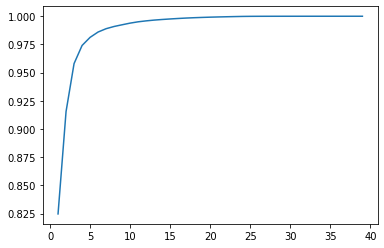

In [35]:
plt.plot(n_comp, ex_var), ex_var[20]

In [36]:
svd = TruncatedSVD(n_components=20)
X_ = svd.fit_transform(X)
clf = ExtraTreesClassifier(n_estimators=250, max_depth=1000)
clf = clf.fit(X_, y)
clf.feature_importances_

array([0.17921245, 0.17943674, 0.04702037, 0.03615273, 0.03274937,
       0.03215232, 0.0307574 , 0.0312859 , 0.04987577, 0.03462548,
       0.0329719 , 0.03307076, 0.03145137, 0.03411169, 0.03277479,
       0.04433886, 0.0341699 , 0.03453753, 0.03471881, 0.03458586])

тут я пытался уменьшить количество фич но есть ощущение что это не помогает, ток если использовать для ускорения, хотя у меня и так все быстро было, но если что код выше помогает жизни

In [37]:
scaler = StandardScaler()
scaler.fit(X_)
train_scale = scaler.transform(X_)
clf = ExtraTreesClassifier(n_estimators=250, max_depth=1000)
clf = clf.fit(train_scale, y)
clf.feature_importances_

array([0.17907715, 0.18441271, 0.04575045, 0.03539359, 0.03336101,
       0.03198429, 0.03068444, 0.0313322 , 0.04806759, 0.03416258,
       0.0325414 , 0.03266522, 0.03128826, 0.03381504, 0.03235614,
       0.04438706, 0.03429754, 0.03379976, 0.03553311, 0.03509045])

In [38]:
crossN = np.unique(groups_train)

scores = []

for n in crossN[20:-1:10]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = LogisticRegression(C=0.2, max_iter = 500, random_state=1).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6606597819906623

In [39]:
crossN = np.unique(groups_train)

scores = []

for n in crossN[20:-1:10]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = train_scale[mask]
    y_train = y[mask]
    X_test = train_scale[mask1]
    y_test = y[mask1]
    
    clf = LogisticRegression(C=0.2, max_iter = 500, random_state=1).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6371650995342493

In [40]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:20]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 20)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6881445989417424

In [41]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:20]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 20)
    mask1 = ~mask
    X_train = train_scale[mask]
    y_train = y[mask]
    X_test = train_scale[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.674798923164167

Вроде все стало лучше но тут я тож не видел ошибку с растоянием которую надо бы исправить, но пусть для защиты созраниться такой код

In [42]:
test_data = pd.read_csv('test_groups.csv')
test_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in test_titledata:
        test_titledata[doc_group] = []
    test_titledata[doc_group].append((doc_id, title))

In [43]:
X_test = []
groups_test = []
for new_group in test_titledata:
    docs = test_titledata[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title'])
    titles = get_clean_titles(np.array(df['title']))
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}')
    G = vectorizer.fit_transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist)
    
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = gdist[k]
        
        all_dist_ = []
        words = set(get_clean_titles([title])[0].strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(get_clean_titles([title_j])[0].strip().split())
            all_dist_.append(len(words.intersection(words_j)))
        
        a = sorted(all_dist)[1:21] + sorted(all_dist_, reverse=True)[0:20]
        X_test.append(a)
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 40) (16627,)


In [44]:
clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.1, 
                                     max_depth=1, random_state=0).fit(X, y)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)

In [45]:
df = pd.DataFrame({ 'pair_id': np.arange(11691, 28318),
                    'target': y_ans
})

df.to_csv("standart+TFIDF.csv", index=False)

In [46]:
np.bincount(y_ans)

array([10697,  5930])

TFIDFVectories + standart + DBSCAN звучит как хорошая идея ещё использовать как фичу результаты DBSCAN но его надо настраивать правильно поэтому код ниже по сути бесмысленный

In [47]:
y = []
X = []

groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'target_id'])
    titles = get_clean_titles(np.array(df['title']))
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}')
    G = vectorizer.fit_transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist)
    clustering = DBSCAN(eps=1.36, min_samples=16).fit(G)
    for k, (doc_id, title, target_id) in enumerate(docs):
        y.append(target_id)
        groups_train.append(new_group)
        all_dist = gdist[k]
        
        all_dist_ = []
        words = set(get_clean_titles([title])[0].strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(get_clean_titles([title_j])[0].strip().split())
            all_dist_.append(len(words.intersection(words_j)))
        
        a = sorted(all_dist)[1:21] + sorted(all_dist_, reverse=True)[0:20]
        a.append(clustering.labels_[k] + 10)
        X.append(a)
X = np.array(X)
y = np.array(y)
groups_train = np.array(groups_train)
print (X.shape, y.shape, groups_train.shape)

(11690, 41) (11690,) (11690,)


In [48]:
clf = ExtraTreesClassifier(n_estimators=250)
clf = clf.fit(X, y)
clf.feature_importances_

array([0.04095813, 0.03548795, 0.036127  , 0.04238954, 0.04005749,
       0.04200646, 0.03740055, 0.03606702, 0.03336377, 0.03134795,
       0.03055217, 0.0308592 , 0.02788334, 0.02648135, 0.02551433,
       0.02697733, 0.02642741, 0.02310812, 0.02461349, 0.01843774,
       0.02689521, 0.02475323, 0.02035456, 0.02210875, 0.02229121,
       0.02116913, 0.01950778, 0.01511829, 0.0207793 , 0.01410973,
       0.01821482, 0.01210272, 0.01131871, 0.01333712, 0.01762835,
       0.01410344, 0.0170782 , 0.0124975 , 0.01318676, 0.02011418,
       0.00727068])

Вот тут мы видим что фича бд скана вообще не полезная на фоне остальных

In [50]:
crossN = np.unique(groups_train)

for n in crossN[20:-1:20]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 20)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]

    clf = LogisticRegression(max_iter = 500, random_state=1).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6720030721721533

In [52]:
crossN = np.unique(groups_train)

scores = []
scores_ = []
for n in crossN[20:-1:20]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 20)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]

    clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
    scores_.append(f1_score(clf.predict(X_test), y_test))
np.array(scores).mean(), np.array(scores_).mean()

(0.6880672540097251, 0.6471821566934712)

ниже тест с бд сканом который ничего естественно не дал в плюсе

In [53]:
test_data = pd.read_csv('test_groups.csv')
test_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in test_titledata:
        test_titledata[doc_group] = []
    test_titledata[doc_group].append((doc_id, title))

In [56]:
X_test = []
groups_test = []
for new_group in test_titledata:
    docs = test_titledata[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title'])
    titles = get_clean_titles(np.array(df['title']))
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}')
    G = vectorizer.fit_transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist)
    clustering = DBSCAN(eps=1.36, min_samples=16).fit(G)
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = gdist[k]
        
        all_dist_ = []
        words = set(get_clean_titles([title])[0].strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(get_clean_titles([title_j])[0].strip().split())
            all_dist_.append(len(words.intersection(words_j)))
        
        a = sorted(all_dist)[1:21] + sorted(all_dist_, reverse=True)[0:20]
        a.append(clustering.labels_[k] + 1)
        X_test.append(a)
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 41) (16627,)


In [57]:
clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.1, 
                                     max_depth=1, random_state=0).fit(X, y)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)

In [58]:
df = pd.DataFrame({ 'pair_id': np.arange(11691, 28318),
                    'target': y_ans
})

df.to_csv("TFIDFStandartBDScan.csv", index=False)

In [59]:
np.bincount(y_ans)

array([11232,  5395])

Давайте спустя столько кода и попыток наконец-то посмотрим на наши данные

In [60]:
X.shape, X[0]

((11690, 41),
 array([ 0.        ,  0.08806354,  0.46113386,  0.50863221,  0.6535723 ,
         0.66753294,  0.66753294,  0.66753294,  0.66753294,  0.67780642,
         0.67879875,  0.70428014,  0.75695583,  0.78303326,  0.78422451,
         0.79412792,  0.8219793 ,  0.82378944,  0.82615145,  0.83242584,
         5.        ,  4.        ,  3.        ,  3.        ,  3.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  1.        ,  1.        ,
        10.        ]))

In [61]:
ex_var = []
n_comp = np.arange(40) + 1

for n in n_comp:
    t0 = time()
    svd = TruncatedSVD(n_components=n)
    X_ = svd.fit_transform(X)    
    ex_var.append(svd.explained_variance_ratio_.sum())

([<matplotlib.lines.Line2D at 0x7fde363467d0>], 0.9552371779028411)

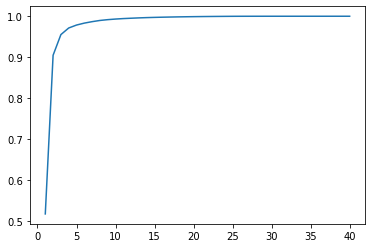

In [63]:
plt.plot(n_comp, ex_var), ex_var[2]

Я конечно выбрал не лучшие фичи но давайте их все перенесем в 2D

In [64]:
svd = TruncatedSVD(n_components=2)
X_graph = svd.fit_transform(X)
X_graph, X_graph.shape

(array([[15.0296433 , -1.00119544],
        [25.45173345,  7.07011235],
        [13.47447512, -2.39994018],
        ...,
        [ 6.48333101, -7.52356437],
        [11.68045961, -4.58846957],
        [10.78001559, -4.06447328]]),
 (11690, 2))

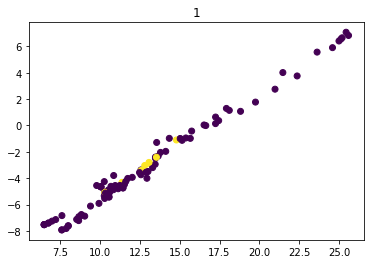

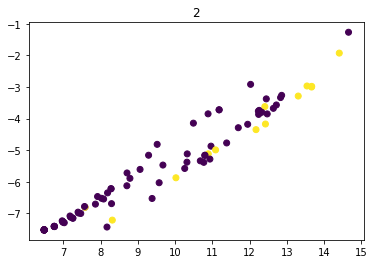

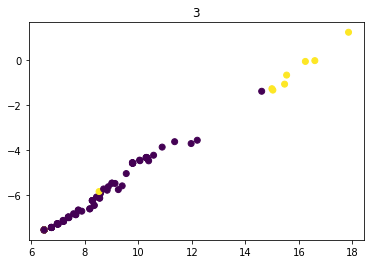

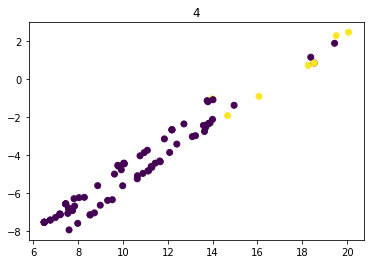

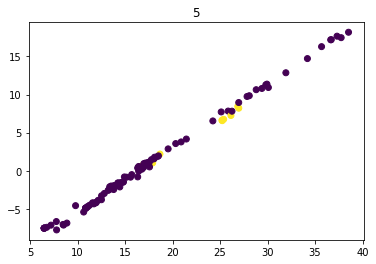

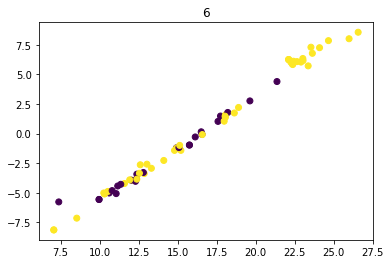

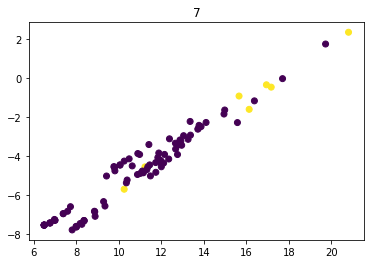

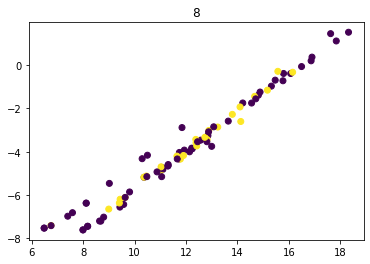

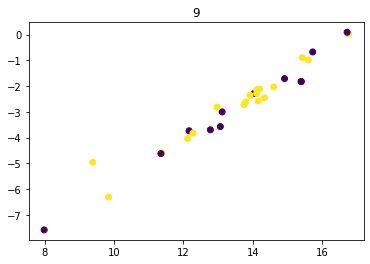

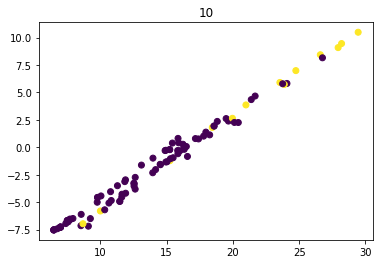

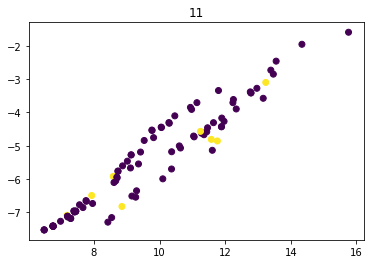

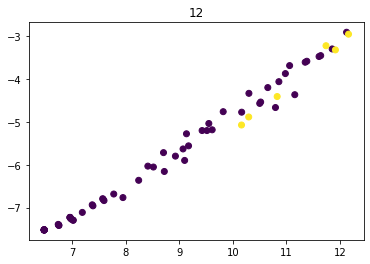

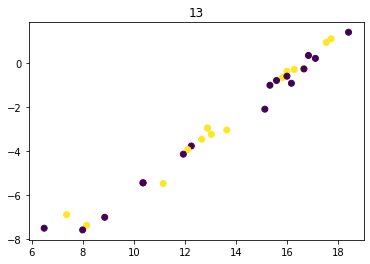

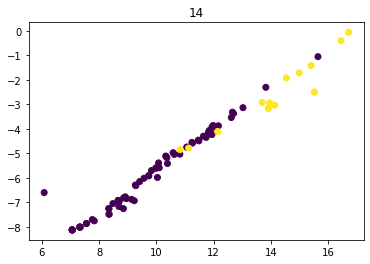

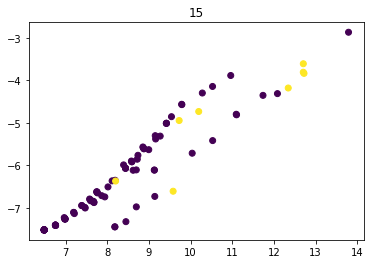

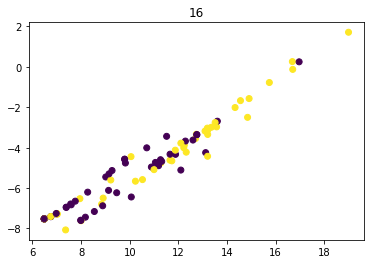

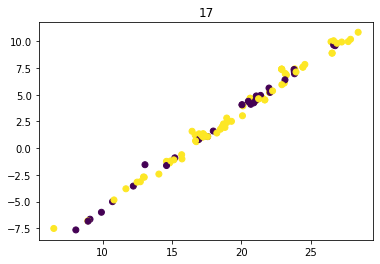

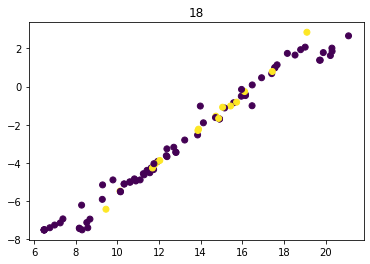

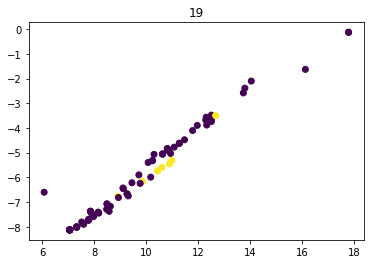

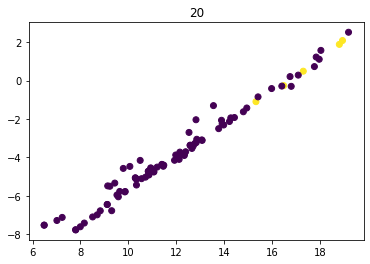

In [65]:
arr = np.arange(20) + 1
for i in arr:
    g = X_graph[groups_train == i]
    
    plt.scatter(g[:, 0], g[:, 1], c=y[groups_train == i])
    plt.title(i)
    plt.show()
    

давайте получим не только заголовки а то скучно

In [68]:
def fill_dict(i):
    soup = BeautifulSoup(open("content/{}.dat".format(i)).read(), 'lxml')
    title = soup.title.text
    descr = ' '
    descr_block = soup.find('meta', {'name':'description'})
    if descr_block:
        if 'content' in descr_block.attrs:
            descr = descr_block['content']
    else:
        print("oh\t")
    return (i, title, descr)

In [69]:
docs_dict = {}
with Pool(processes=10) as pool:
    a = pool.map(fill_dict, range(1, 28027))
pool.join()
np.array(a).shape

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	oh	

oh	oh	

oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	


oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	oh	


oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	

oh	oh	
oh	oh	oh	


oh	
oh	
oh	
oh	oh	

oh	oh	

oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	oh	

oh	oh	

oh	
oh	oh	

oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	
oh	


(28026, 3)

Чет много как то охов поэтому если кто то силен духом пусть ищет не ток discription, но есть ощущение что это сложно так как код выше работал минут 5

In [70]:
df = pd.DataFrame(a)
df

0                                                  1  \
0          1  М. Б. Аншина Центр репродукции и генетики «Фер...   
1          2                             Переводы Киви кошелька   
2          3  ПРОЕКТ ПАТРУЛИ ВРЕМЕНИ - РЕАБИЛИТАЦИЯ ДУХОВНЫХ...   
3          4  Блог - Клуб  " Преподавание в начальных класса...   
4          5  Как быстро понизить холестерин. Высокий холест...   
...      ...                                                ...   
28021  28022  Поврежденные листья – признак больного антуриума.   
28022  28023    Toyota Hilux Surf 3.0 TD, SSR-G, «Бегемот» |...   
28023  28024  How to download power director 14 full version...   
28024  28025                   Скачать проигрыватель avi iphone   
28025  28026  Оплата госпошлины в суд: проводки госпошлин в ...   

                                                       2  
0      Тип: Реферат; Размер: 260.22 Kb.; Резюме: в ст...  
1                                                         
2                                                         
3       Блог - Клуб  " Преподавание в начальных классах"  
4      Быстро понизить холестерин можно следующими на...  
...                                                  ...  
28021  Вы заметили серьезные изменения в состоянии ли...  
28022                                                     
28023  How to download power director 14 full version...  
28024                                                     
28025  Госпошлина в бухучете 2017: какими проводками ...  

[28026 rows x 3 columns]

много пропусков, давайте их заполним заголовками, но все равно могут встретиться наны

In [71]:
df.loc[df[2] == ' ', 2] = df[df[2] == ' '][1]
df.loc[df[2] == '', 2] = df[df[2] == ''][1]
df.head(10)

0                                                  1  \
0   1  М. Б. Аншина Центр репродукции и генетики «Фер...   
1   2                             Переводы Киви кошелька   
2   3  ПРОЕКТ ПАТРУЛИ ВРЕМЕНИ - РЕАБИЛИТАЦИЯ ДУХОВНЫХ...   
3   4  Блог - Клуб  " Преподавание в начальных класса...   
4   5  Как быстро понизить холестерин. Высокий холест...   
5   6                               Как составить резюме   
6   7                                               Изюм   
7   8  Проект - "Ладушки, ладушки" (для детей раннего...   
8   9  Сколько калорий в дыне: торпеда, колхозница, с...   
9  10  НУЖНА ПОМОЩЬ  - Доска объявлений - Заработать ...   

                                                   2  
0  Тип: Реферат; Размер: 260.22 Kb.; Резюме: в ст...  
1                             Переводы Киви кошелька  
2  ПРОЕКТ ПАТРУЛИ ВРЕМЕНИ - РЕАБИЛИТАЦИЯ ДУХОВНЫХ...  
3   Блог - Клуб  " Преподавание в начальных классах"  
4  Быстро понизить холестерин можно следующими на...  
5  Как составить резюме правильно. Образец, бланк...  
6                                               Изюм  
7                                         Дошкольник  
8  Вы любите дыни? Мы расскажем, сколько калорий ...  
9  НУЖНА ПОМОЩЬ  - Доска объявлений - Заработать ...

In [72]:
df = df.rename(columns={0: "doc_id", 1: "title", 2: "description"})

In [73]:
df.to_csv("titles_and_descriptions.csv", index=False)

In [12]:
df = pd.read_csv("titles_and_descriptions.csv")
df

doc_id                                              title  \
0           1  М. Б. Аншина Центр репродукции и генетики «Фер...   
1           2                             Переводы Киви кошелька   
2           3  ПРОЕКТ ПАТРУЛИ ВРЕМЕНИ - РЕАБИЛИТАЦИЯ ДУХОВНЫХ...   
3           4  Блог - Клуб  " Преподавание в начальных класса...   
4           5  Как быстро понизить холестерин. Высокий холест...   
...       ...                                                ...   
28021   28022  Поврежденные листья – признак больного антуриума.   
28022   28023    Toyota Hilux Surf 3.0 TD, SSR-G, «Бегемот» |...   
28023   28024  How to download power director 14 full version...   
28024   28025                   Скачать проигрыватель avi iphone   
28025   28026  Оплата госпошлины в суд: проводки госпошлин в ...   

                                             description  
0      Тип: Реферат; Размер: 260.22 Kb.; Резюме: в ст...  
1                                 Переводы Киви кошелька  
2      ПРОЕКТ ПАТРУЛИ ВРЕМЕНИ - РЕАБИЛИТАЦИЯ ДУХОВНЫХ...  
3       Блог - Клуб  " Преподавание в начальных классах"  
4      Быстро понизить холестерин можно следующими на...  
...                                                  ...  
28021  Вы заметили серьезные изменения в состоянии ли...  
28022    Toyota Hilux Surf 3.0 TD, SSR-G, «Бегемот» |...  
28023  How to download power director 14 full version...  
28024                   Скачать проигрыватель avi iphone  
28025  Госпошлина в бухучете 2017: какими проводками ...  

[28026 rows x 3 columns]

Сделали красиво и теперь можно дальше приступать, но давайте сначала проверим то что я выципил вообще то что нашли преподы или нет

In [13]:
doc_to_title = {}
with open('docs_titles.tsv', encoding='utf8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
len(doc_to_title)

28026

In [14]:
my_doc_to_title = {}
my_doc_to_description = {}
for index, row in df.iterrows():
    if type(row[1]) != float:
        my_doc_to_title[row[0]] = get_clean_titles([row[1]])[0]
        my_doc_to_description[row[0]] = get_clean_titles([row[2]])[0]
    else:
        my_doc_to_title[row[0]] = ''
        my_doc_to_description[row[0]] = ''
    print(row[0], my_doc_to_description[row[0]])

NameError: name 'get_clean_titles' is not defined

In [91]:
for key in doc_to_title.keys():
    doc_to_title[key] = get_clean_titles([doc_to_title[key]])[0]
    print(key, doc_to_title[key])

15731 ваз замена подшипников ступицы нива
14829 ваз оптом в сочи сравнить цены купить потребительские товары на tiu ru
15764 купить ступица лада калина трансмиссия переходные ступицы цена замена тюнинг
17669 классика
14852 ступица нива замена подшипника своими руками
15458 ваз
14899 обзор подшипников полуоси ваз
16879 купить подшипники и ступицы fag страница
16310 horsepowers автомобильный интернет портал отзыв владельца ваз нива года
15440 новости и сообщения из официальной группы вконтакте торговой компании sport магазины тольятти
16242 инструкция по замене подшипника передней ступицы ивеко дейли через dorognoekam ru
16383 ступицы olx ua страница
15580 маааленькая проблемка бортжурнал автокам года на drive
16840 разгруженные полуоси для нива шлица мм
17519 прошивки для нива м скачать файлообменник emqraty foxkirov ru
15185 страница раздела каталог подвеска
15016 продам ниву
17796 рекомендации по проведению независимой экспертизы осаго
17507 втулки подшипников в омске сравнить цены и 

20014 мыльные пузыри в домашних условиях с глицерином
21541 мыльные пузыри радость детства как сделать мыльные пузыри
20926 мыльные пузыри своими руками woman s day
20421 мыльные пузыри в домашних условиях как сделать их правильно чтобы
21310 самодельный раствор мыльных пузырей youtube
19801 как сделать мыльные пузыри дома
19124 как сделать мыльные пузыри youtube
20016 как сделать мыльные пузыри в домашних условиях рецепт раствора
20521 как сделать жидкость для мыльных пузырей как самим сделать мыльные пузыри хобби и развлечения другое
18186 как сделать мыльные пузыри в домашних условиях как приготовить раствор для мыльных пузырей рецепт
19451 как сделать самую лучшую смесь для мыльных пузырей обсуждение на liveinternet российский сервис онлайн дневников
20539 большие мыльные пузыри состав
21526 гигантские мыльные пузыри
19553 секрет приготовления самого лучшего раствора для шоу мыльных пузырей youtube
18088 как сделать мыльные пузыри
21151 как сделать мыльные пузыри дома сюрпризы жизн

14093 блюда из куриных грудок рецепты с фото на повар ру рецептов куриных грудок
11754 как солить воблу astfisher ru
11312 как приготовить вяленую рыбу вяление рыбы в домашних условиях как сделать
11963 как сделать силиконовый молд для d мыла вобла мыловарение video dailymotion
12265 вобла описание особенности пищевая ценность вобла в кулинарии
12241 гороскоп на август года дева
14382 рыбачьте с нами за воблой на один день
12216 как делать дабстеп воблу в fl studo профессиональный урок youtube
11747 как делать таранку вся рыбалка
14245 cjclub сделать воблу
14165 ответы mail ru как делать таранку из карася
14575 как делать таранку рыбалка информационно развлекательный портал
11331 каспийская вобла ловля в мае в hd лучшее видео подборки для настоящих мужчин на tvigle ru
12077 фотокулинар конструктор рецептов вобла
11276 сушка вяление рыбы вяленая вобла и плотва как сделать вяленную рыбу
13305 как сделать воблу как хранить воблу дома кулинарные рецепты
11436 как приготовить вяленую воблу 

7291 шлюха викисловарь
5147 шлюха это что такое шлюха
7510 шлюха это что такое шлюха
5491 индивидуалки и проститутки уфы интим досуг телефоны адреса фото и видео
4568 ответы mail ru кто такая шлюха
4109 ответы mail ru кто такая шлюха
6939 проститутки индивидуалки шлюхи интим досуг
4244 стишки про шлюх
6538 шлюха значение слова шлюха
4550 шлюха смотреть онлайн
6661 кто такие шлюхи женский форум
5354 медведь и шлюха lurkmore
24231 лунный день сегодня лунный календарь
23199 лунный календарь на июль года когда полнолуние новолуние женский журнал nicelady ru
23472 גישה נדחתה לייט רייקי שיטות חדשניות לריפוי אנרגטי
23704 лунный календарь страница тайные знания тайны и магия
23313 лунный календарь зачатия
22263 зюрняева тамара новинки
21942 лунный календарь привлечения денег книга страница сияющая
24570 когда сажать картошку в году
22515 свт иоанн златоуст о том как правильно рассчитать день святой пасхи беседа на ту же пасху слово е и последнее миссионерский центр им преп муч афанасия игумена

15283 топ лучших закрытых сериалов мира youtube
16861 герои самых крутых сериалов риа новости
17331 лучших сериалов за всю историю кино
2436 компас лучший помощник в ориентировании
191 ориентирование на местности различными способами ориентирование с помощью карты с помощью компаса с помощью часов по небесным светилам и местным предметам по различным признакам
3512 ориентирование
3525 ориентирование по компасу
1549 ориентирование по компасу youtube
73 как правильно пользоваться компасом
1227 как правильно пользоваться компасом туристическим военным геологическим или программой на телефоне видео урок
2999 как пользоваться компасом в лесу инструкция видео
225 работа с компасом
3599 как правильно пользоваться компасом как правильно
3249 ориентация карты по компасу mtbo велоориентирование
3994 как ориентироваться по компасу полезные советы kakprosto ru как просто сделать всё
3635 что такое компас как пользоваться компасом ориетирование по компасу
333 как ориентироваться по компасу в лесу о

2599 анкета для руководителей аптек разработанная для изучения программно технического обеспечения используемого аптекой для доступа в интернет
636 анкета для людей страница форум о лошадях и не только можно просто поболтать
3480 высокие статистические технологии просмотр темы глобальные рейтинги университетов проблема манипулирования
1394 анкета для подготовки сводного доклада город на воде опыт проблемы и перспективы
3237 как создать форму отзывов в wordpress pizza e birra
3198 описание модулей управления порталом справочник напишите об этом нашему внимательному и отзывчивому админу ok keys ru
1695 интернет новости главная
3343 шаблон упрощенной анкеты
1794 бильярд новости
2842 электронная библиотека мгппу смирнов педагогика и психология высшего образования от деятельности к личности
3120 анкета для службы безопасности форум кадровый портал кадровик ру
3707 анкета для учащихся и педагогов на предмет выяснения их устойчивых интересов
2338 региональная экономика реструктуризация систем

24441 повышенный роэ в крови у женщин причины женские секреты
24124 норма соэ в крови у детей
21781 диагностика ревматоидного артрита критерии диагностики диагностика и классификация артритов хирургия и лечение
23557 исследование гормонов коры надпочечников причины симптомы и лечение мж
23113 анализ на сахарный диабет виды показатели нормы
22541 анализы крови у малышей полезно знать здоровье и питание малыша
24230 биохимические исследования при гиперпаратиреозе костная патология метаболические заболевания костей хирургия и лечение
22935 анализ секрета простаты норма и отклонения
22369 анализ крови на уровень тестостерона у мужчин как сдать тест
22426 норма сахара в крови после еды кровеносная система zdorovajasemja ru
23460 анализ крови при токсокарозе полное описание и расшифровка
21792 норма сахара в крови у мужчин здоровый мужчина здоров про
22551 анализ на токсоплазмоз как сдавать расшифровка норма
22734 анализ крови собаки архив форум ветеринарной клиники белый клык
23790 реферат 

20072 ответы mail ru когда можно сажать болгарский перец заранее спасибо
19023 тепличное хозяйство рассада петунии однолетних вконтакте
18349 файл rtf архив закаливание растений страница
20145 удобрения для томатов в какой период каким составом и в какой дозировке подкормить помидоры
20147 советы по рассаде я фермер ru
20017 томат как ценная овощная культура реферат курсовая работа диплом скачать бесплатно с реф рф
19565 особенности выращивания баклажанов
19223 основные правила полива томатов
19709 огород общие вопросы агрофорум agroxxi
21089 рассада в твери все для дачи вконтакте
19084 увлечениехобби ру лучший сайт по хобби просмотр темы все о клубнике
19545 для дома записи в рубрике для дома дневник туся liveinternet российский сервис онлайн дневников
19547 галина кизима большая книга умного дачника стр modernlib ru
18510 тюмень лунный календарь на март безформата ru новости
21369 когда сажать помидоры в теплицу в подовье советы врача zdorovajasemja ru
21012 технология посадки помидо

4440 ответить на комментарий учебный центр корпоративное обучение семинары и бизнес тренинги продаж управление персоналом тренинги
4400 как рассчитать нормо час как подсчитать сколько в час рублей fashion stylist
6585 загадки финской школы меньше учишься больше знаешь вестник к
5275 архитектура древнего египта
6068 уплата алиментов после
4561 прошу помощи дети
5342 два пути фиксации установки
7509 страховой стаж для больничного листа листка нетрудоспособности расчет проценты
4837 работа по совместительству тк рф статья syl ru
5821 система оплаты труда определение
6313 натуральное питание форум любителей собак собаки сибири
6861 опыт использования зу maha mh c архив страница fonarevka ru всё о фонарях и осветительной технике
6638 больничный сразу после декрета
5551 расчет среднего дневного и среднего месячного заработка
7342 африканский рейс атас проза остросюжетная литература откровения души
6213 варнавинская вандея
6298 монополия олигополия монопсония рефераты бесплатно
6400 состав и 

4299 галактика жизни интернациональный форум о домашних животных лошади собаки кошки хорьки кролики морские свинки грызуны птицы аквариум террариум просмотр темы цвергшнауцер общая породная ветка
6860 форум для волшебников
4842 лабиринт проза роман
7034 без заголовка обсуждение на liveinternet российский сервис онлайн дневников
4642 новости и сообщения из официальной группы вконтакте учебного центра гармония курсы красноярск
4960 исповедь первой леди литература романы
7432 особенности ухода
5099 коррекция лица макияжем с помощью чего и как правильно делать
5355 минеральные румяна mary kay регулярная линия новые оттенки заказ с картинка
5754 программа сердечно сосудистый скрининг программа метаболический синдром
4532 стена вконтакте
4237 классический лечебный массаж головы массаж головы и ушных раковин путь к здоровью и долголетию
5812 парфюмерия и косметика общение беседка эзотерический форум о магии и таро
6328 эксмо просмотр темы иллюзия реальности научная фантастика попаданство
7265

15941 читать онлайн нортон андрэ хроники полукровок эльфийский лорд
15638 зимние сказки для детей лет читать
16027 тема v анализ смесей катионов и анионов качественный химический анализ вещества
14943 пачиму лукашенку обзывают колхозником у него же есть самый крутой мерседес немецкий и самолёт американский
16651 мерседес бенц самые крутые автомобили вконтакте
16880 mercedes benz g class
17853 mercedes benz slr mclaren крутые тачки самые крутые машины мира
17382 самый крутой мерседес переоденут в старинный костюм autoplus su автомобильный интернет журнал
16569 самый крутой мерседес переоденут в старинный костюм
15487 флеш игра гонка снежный мерседес
16749 самый дорогой мерседес самый дорогой в мире сайт самый дорогой
17290 mercedes benz ener g force джип клуб пилигрим г геленджик
15267 продан самый дорогой мерседес в мире фото
16978 самый крутой mercedes benz официально в казахстане автоновости авто mail ru
15723 представлен самый дорогой mercedes в мире автоновости авто mail ru
16925 s

26548 на красной площади июля в состоится праздничный концерт посвященный летию крещения руси вход свободный в начале было слово
26069 правительство московской области обзор прессы
25387 августа вести чита в с текстовым сопровождением местные новости атамановка онлайн
26753 западной сибири материалы шестой межрегиональной научно практической конференции сентября года г бийск
27957 цесаревич алексей fb куллиб классная библиотека скачать книги бесплатно
25196 вопросы по ип сайт для ип дмитрия робионека
25896 диета от собчак и бородиной
25343 если страховая компания при оформлении осаго навязывает страхование жизни и здоровья
27565 тв телепрограмма программа передач на
26705 отчетный концерт творческих коллективов сценарий
27389 страничка музыкального руководителя социальная сеть работников образования
26258 электронная библиотека мгппу телегин рождение диалога книга о педагогическом общении
27503 журналистка из петрозаводска довела до нервного срыва анастасию волочкову столица на онего о

20746 полезные советы как разукрасить бочки на даче
19862 ответы mail ru готовите ли вы в зимнее время что то из маф для дачи
17942 украшаем дачный участок декор
20225 хитрые приемы декорирования старых бочек как покрасить бочку
18235 как украсить забор своими руками дом сад огород красивейший цветник
19215 туалет на даче страница форум forumhouse
20560 бочки на дачу и в сад
20042 поделки из бочек супердачник
20420 интересные поделки для огорода
19095 мастерим поделки для сада и дачи своими руками
20643 разукрасить бочки на даче дом загородная жизнь
18627 расписные бочки дачные поделки мастер класс это интересно это интересно мамы и папы архангельска
19266 смешные идеи для дачи разукрашенные бочки для дачи шины
18490 форум родителей оригинальные клумбы
19653 как украсить бочки
21364 форматор расписные бочки для дачи
20115 весёлые дачные бочки
19696 бочка своими руками образовательный портал мистергид
19662 идеи вашего дома как украсить бочку на даче
19615 раскрашиваем бочки на даче фот

1129 экология младенчества первый год детвора
4637 кризис а вы его почувствовали важные события в стране и в мире разговоры за жизнь
6247 беспридел в пао сбербанк детей лишают жилья написать открытое письмо президенту
6733 программе лояльности спасибо от сбербанка лет общество новости архангельска
4681 как вернуть депозит вклад при отзыве лицензии и банкротстве банка
6276 какие аптеки принимают спасибо от сбербанка
5628 общие вопросы о сбербанке россии
6263 хабаровская
4254 форум работников железнодорожного транспорта требуется помощь ребенку володя года
6128 со сбербанком копить и тратить выгодно и приятно news ykt ru служба новостей
4602 прогноз мирового развития в стране и мире обсуждение на liveinternet российский сервис онлайн дневников
6211 нуждаюсь в консультаций вопросы гинекологии и советы по лечению
7367 губернатор приморья я точно не в восторге от того что кого то сажают в тюрьму политика власть дебри дв
4723 как сбербанк украл мою зарплату
4197 форум работников железнодорож

6460 эквамер капс мг мг мг или шт препараты vidal ru cправочник лекарственных препаратов
6018 франц александер franz alexander психосоматическая медицина
4161 считает себя больным с года когда во время игры в футбол в
6757 данилов вадим валерьевич медицина владивостока спроси врача владивостока владмедицина медицинский портал города владивостока vladmedicina ru
4710 моче обнаружена кровь ребенка кровь ребенка zhizn rebenka ru
6396 медицинский портал узбекистана med uz об организации и обеспечении антенатального ухода и оказания медицинской помощи беременным а учреждениях первичной медико санитарной помощи
6320 циститселе
5073 искусство не стареть здоровье статьи бизнес тренинги нлп а также юмор и хорошее настроение
4166 эпилепсия у собакчто такое эпилепсия информативный форум
5704 как проявляется простатит у мужчин
5718 цистоскопия мочевого пузыря у женщин отзывы здоровье женщины zdorovajasemja ru
5460 глава общие сведения о мочеполовой системе мужчины лечение простатита
4351 затруднен

14017 как грамотно подкармливать томаты обсуждение на liveinternet российский сервис онлайн дневников
11413 подкормка помидоров в открытом грунте и теплице
13008 можно ли подкормить дрожжами помидоры и баклажаны как подкормить дрожами
11623 как подкормить помидоры дрожжами
12199 подкормка помидоров дрожжами популярные рецепты
12115 как подкормить помидоры дрожжами обсуждение на liveinternet российский сервис онлайн дневников
11258 как удобрять помидоры дрожжами фото и видео хозяин дачи
11299 подкормка помидор дрожжами отзывы дрожжевое удобрение в теплице чем подкормить томаты как рассаду удобрять
14360 дрожжи сильное удобрение для всех youtube
13682 дрожжи для подкормки растений что дает удобрение как разводить и использовать отзывы и видео
14033 подкормка рассады помидор после пикировки дрожжами дома
13606 как подкормить помидоры дрожжами
14364 как подкормить помидоры дрожжами как подкармливать помидоры дрожжами узнайте как приготовить дрожжевой раствор для подкормки томатов
14009 как

In [92]:
for key in doc_to_title.keys():
    if doc_to_title[key] != my_doc_to_title[key]:
        print("oh")

Даж без охов

Давайте проврим скор и наконец то исправим ошибку с растоянием

In [94]:
train_data = pd.read_csv('train_groups.csv')
traingroups_data = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = my_doc_to_title[doc_id]
    descr = my_doc_to_description[doc_id]
    if doc_group not in traingroups_data:
        traingroups_data[doc_group] = []
    traingroups_data[doc_group].append((doc_id, title, descr, target))

In [101]:
y = []
X = []

groups_train = []
for new_group in traingroups_data:
    docs = traingroups_data[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr', 'target_id'])
    
    titles = np.array(df['title'])
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}', min_df=6)
    G = vectorizer.fit_transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    descrs = np.array(df['descr'])
    vectorizer2 = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}', min_df=5)
    G2 = vectorizer2.fit_transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2, nan=2)
    
    
    for k, (doc_id, title, descr, target_id) in enumerate(docs):
        y.append(target_id)
        groups_train.append(new_group)
        
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j, target_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        a = sorted(all_dist_title_cos)[1:21] + sorted(all_dist_descrs_cos)[1:21]
        a += sorted(all_dist_title_int, reverse=True)[0:20] + sorted(all_dist_descrs_int, reverse=True)[0:20]
        X.append(a)
X = np.array(X)
y = np.array(y)
groups_train = np.array(groups_train)
print (X.shape, y.shape, groups_train.shape)

(11690, 80) (11690,) (11690,)


In [102]:
clf = ExtraTreesClassifier(n_estimators=250, max_depth=1000)
clf = clf.fit(X, y)
clf.feature_importances_

array([0.00971925, 0.00994178, 0.01146169, 0.01063081, 0.01062166,
       0.01312549, 0.01288897, 0.01491348, 0.01407047, 0.00914834,
       0.01340314, 0.01231724, 0.01320861, 0.01155841, 0.01042146,
       0.01254906, 0.01013423, 0.01216325, 0.01181634, 0.01169687,
       0.0096407 , 0.00965205, 0.0096443 , 0.01077036, 0.01065422,
       0.01253053, 0.01823396, 0.01146865, 0.01487176, 0.0122114 ,
       0.01252026, 0.01395115, 0.01345569, 0.01062312, 0.01253337,
       0.01115385, 0.0109053 , 0.0091153 , 0.01306943, 0.01175279,
       0.02052505, 0.02076386, 0.01976235, 0.02180935, 0.01766206,
       0.01866219, 0.01332497, 0.01704546, 0.0118482 , 0.01652942,
       0.01287611, 0.01399292, 0.0124468 , 0.01463751, 0.02042301,
       0.01293853, 0.01710841, 0.01359298, 0.0128137 , 0.01534973,
       0.01790993, 0.01636813, 0.0127939 , 0.01209508, 0.01119442,
       0.0104601 , 0.00922809, 0.00865888, 0.00760166, 0.00779744,
       0.0078757 , 0.00848458, 0.00820107, 0.00790734, 0.00963

In [103]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:20]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 20)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6711864770213042

In [106]:
from sklearn.ensemble import BaggingClassifier
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:20]:
    print(n)
    mask = np.logical_and(groups_train <= n, groups_train >= n - 20)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                     max_depth=1, random_state=0)
    
    bagging = BaggingClassifier(clf, max_samples=0.5, max_features=0.5).fit(X_train, y_train)
    
    y_ans = np.where(bagging.predict_proba(X_test)[:,1] >= 0.2, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

21
41
61
81
101
121


0.6591053055365159

In [112]:
scaler = StandardScaler()
scaler.fit(X)
train_scale = scaler.transform(X)

In [113]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:20]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 20)
    mask1 = ~mask
    X_train = train_scale[mask]
    y_train = y[mask]
    X_test = train_scale[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6711864770213042

In [109]:
test_data = pd.read_csv('test_groups.csv')
test_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = my_doc_to_title[doc_id]
    descr = my_doc_to_description[doc_id]
    if doc_group not in test_titledata:
        test_titledata[doc_group] = []
    test_titledata[doc_group].append((doc_id, title, descr))

In [117]:
X_test = []

for new_group in test_titledata:
    docs = test_titledata[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr'])
    
    titles = np.array(df['title'])
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}')
    G = vectorizer.fit_transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist)
    
    descrs = np.array(df['descr'])
    vectorizer2 = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}')
    G2 = vectorizer2.fit_transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2, nan=2)
    
    
    for k, (doc_id, title, descr) in enumerate(docs):
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        a = sorted(all_dist_title_cos)[1:21] + sorted(all_dist_descrs_cos)[1:21]
        a += sorted(all_dist_title_int, reverse=True)[0:20] + sorted(all_dist_descrs_int, reverse=True)[0:20]
        X_test.append(a)
X_test = np.array(X_test)
print (X_test.shape)

(16627, 80)


In [118]:
test_scale = scaler.transform(X_test)

In [119]:
clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(train_scale, y)
y_ans = np.where(clf.predict_proba(test_scale)[:,1] >= 0.3, 1, 0)

In [120]:
np.bincount(y_ans)

array([13072,  3555])

Чет все не то даж хуже становиться, ниже попытки того, что не работает

In [2]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from time import time

In [302]:
ex_var = []
n_comp = np.arange(59) + 1

for n in n_comp:
    t0 = time()
    svd = TruncatedSVD(n_components=n)
    X_ = svd.fit_transform(X)    
    ex_var.append(svd.explained_variance_ratio_.sum())

([<matplotlib.lines.Line2D at 0x7fc82b771590>], 0.5907543783410256)

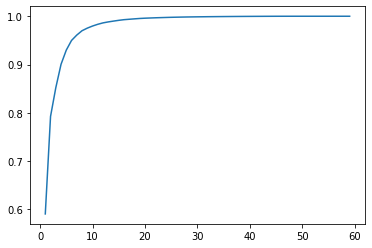

In [303]:
plt.plot(n_comp, ex_var), ex_var[0]

In [308]:
svd = TruncatedSVD(n_components=40)
X_ = svd.fit_transform(X)   
svd.explained_variance_ratio_.sum()

0.99971346460932

In [ ]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:20]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 20)
    mask1 = ~mask
    X_train = train_scale[mask]
    y_train = y[mask]
    X_test = train_scale[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

In [143]:
crossN = np.unique(groups_train)

scores = []
for n in crossN[1:-1:2]:
    print(n)
    X_train = X_[groups_train < n, :10]
    y_train = y[groups_train < n]
    X_test = X_[groups_train >= n, :10]
    y_test = y[groups_train >= n]

    clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    #y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(clf.predict(X_test), y_test))
    #scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128


0.6395763395334623

In [152]:
from sklearn.ensemble import BaggingClassifier
crossN = np.unique(groups_train)

scores = []
for n in crossN:
    print(n)
    X_train = X_[groups_train != n, :10]
    y_train = y[groups_train != n]
    X_test = X_[groups_train == n, :10]
    y_test = y[groups_train == n]

    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    
    #bagging = BaggingClassifier(clf, max_samples=0.5, max_features=0.5).fit(X_train, y_train)
    
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    #scores.append(f1_score(bagging.predict(X_test), y_test))
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


KeyboardInterrupt: 

In [123]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=150)
clf = clf.fit(X_[:,:10], y)
clf.feature_importances_

array([0.16311686, 0.10228601, 0.10871495, 0.21157014, 0.06805945,
       0.07371946, 0.06713937, 0.07007153, 0.06673376, 0.06858848])

In [134]:
test_data = pd.read_csv('test_groups.csv')
test_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = my_doc_to_title[doc_id]
    descr = my_doc_to_description[doc_id]
    if doc_group not in test_titledata:
        test_titledata[doc_group] = []
    test_titledata[doc_group].append((doc_id, title, descr))

In [137]:
X_test = []

for new_group in test_titledata:
    docs = test_titledata[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr'])
    
    titles = np.array(df['title'])
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}')
    G = vectorizer.fit_transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist)
    
    descrs = np.array(df['descr'])
    vectorizer2 = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}')
    G2 = vectorizer2.fit_transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2)
    
    
    for k, (doc_id, title, descr) in enumerate(docs):
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        a = sorted(all_dist_title_cos)[1:16] + sorted(all_dist_descrs_cos)[1:16]
        a += sorted(all_dist_title_int, reverse=True)[0:15] + sorted(all_dist_descrs_int, reverse=True)[0:15]
        X_test.append(a)
X_test = np.array(X_test)
print (X_test.shape)

(16627, 60)


In [138]:
X_test_ = svd.transform(X_test)

In [139]:
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, 
                                     max_depth=1, random_state=0).fit(X_[:,:10], y)

In [140]:
y_ans = np.where(clf.predict_proba(X_test_[:,:10])[:,1] >= 0.3, 1, 0)

In [141]:
np.bincount(y_ans)

array([10723,  5904])

In [142]:
df_ = pd.DataFrame({ 'pair_id': np.arange(11691, 28318),
                    'target': y_ans
})

df_.to_csv("notSimple.csv", index=False)

In [5]:
for new_group in traingroups_data:
    docs = traingroups_data[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr', 'target_id'])
    
    titles = np.array(df['title'])
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}', min_df=6)
    vectorizer.fit(titles)
    
    descrs = np.array(df['descr'])
    vectorizer2 = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}', min_df=5)
    vectorizer2.fit(descrs)
    names = np.array(vectorizer2.get_feature_names())
    
    print(names.shape, names, descrs)

NameError: name 'traingroups_data' is not defined

Спустя некоторое время и наблюдением за текстом понятно что надо сам текст обрабатывать лучше, зачем писать самому если за тебя уже написали

In [3]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-zа-яА-Я]+"

In [4]:
stop_words = stopwords.words("russian")
stemmer = SnowballStemmer("russian")
stop_words_en = stopwords.words("english")
stemmer_en = SnowballStemmer("english")

In [5]:
def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words and token not in stop_words_en:
            if stem:
                tokens.append(stemmer.stem(stemmer_en.stem(token)))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [6]:
s = "Продажа ВАЗ Нива 2121 2011 года в Кургане, Продам LADA 4x4 (НИВА) в отличном ТЕХНИЧЕСКОМ состоянии, обмен на более дорогую, на равноценную, на более дешевую, 4WD"

In [7]:
preprocess(s, stem=True)

'продаж ваз нив год курган прод lada x нив отличн техническ состоян обм дорог равноцен дешев wd'

In [8]:
df = pd.read_csv('titles_and_descriptions.csv')
df.head()

doc_id                                              title  \
0       1  М. Б. Аншина Центр репродукции и генетики «Фер...   
1       2                             Переводы Киви кошелька   
2       3  ПРОЕКТ ПАТРУЛИ ВРЕМЕНИ - РЕАБИЛИТАЦИЯ ДУХОВНЫХ...   
3       4  Блог - Клуб  " Преподавание в начальных класса...   
4       5  Как быстро понизить холестерин. Высокий холест...   

                                         description  
0  Тип: Реферат; Размер: 260.22 Kb.; Резюме: в ст...  
1                             Переводы Киви кошелька  
2  ПРОЕКТ ПАТРУЛИ ВРЕМЕНИ - РЕАБИЛИТАЦИЯ ДУХОВНЫХ...  
3   Блог - Клуб  " Преподавание в начальных классах"  
4  Быстро понизить холестерин можно следующими на...

In [9]:
my_doc_to_title_stem = {}
my_doc_to_description_stem = {}
for index, row in df.iterrows():
    my_doc_to_title_stem[row[0]] = preprocess(row[1], stem=True)
    my_doc_to_description_stem[row[0]] = preprocess(row[2], stem=True)
    print(row[0], my_doc_to_title_stem[row[0]])
        

1 м б аншин центр репродукц генетик фертимед г москв
2 перевод кив кошельк
3 проект патрул времен реабилитац духовн существ просмотр тем деньг экономик обм финанс деньг процент
4 блог клуб преподаван начальн класс порта профессиональн образован чеченск республик
5 быстр пониз холестерин высок холестерин симптом лечен народн средств домашн услов
6 состав резюм
7 изюм
8 проект ладушк ладушк дет ран возраст
9 скольк калор дын торпед колхозниц скольк калор кг дын гр сушен
10 нужн помощ доск объявлен заработа деньг денежн помощ кредитн помощ
11 подкорм огурц дрожж сад огород
12 прозрачн вод южн мор
13 вопрос продолжен выплат набор опс г агентск работ форум pensiamarket ru навигатор пенсион рынк
14 экстернат нов закон образован
15 утеплен обшивк балкон внутрен отделк форум мебельщик
16 vernikov ru вс менеджмент основ менеджмент част трет функц управлен vernikov ru вс менеджмент
17 современ стоматолог так стоматолог
18 сч тчик яплакал
19 faq ps ftp server установк настройк арх pspx форум
20 b

312 отлича дантист стоматолог
313 выращива огурц вмест батюшк автор макс фомин
314 арх юридическ консультац
315 стоматолог хирург ортопед ортодонт отлич стоматологическ клиник м плазз
316 контрол хозяйствен операц учет расчет заработн плат пример купсхп освейск
317 деятельн соответств гражданск кодекс российск федерац федеральн закон год фз некоммерческ организац
318 полин кавнацк вконтакт
319 стоматологическ поликлиник
320 icc
321 дэвид митчелл литературн призрак
322 курс конверс валют кросс курс банк беларус банк беларус
323 обществознан част тем
324 бесплатн книг госвласт рф телефон справочник
325 оформ загранпаспорт нов образц мфц многофункциональн центр получ
326 тем лекц практическ занят клиническ фармаколог уч год viii ix
327 новост сообщен официальн групп вконтакт интернет магазин шинсб услуг бизнес екатеринбург
328 н н желтухин г
329 факт подровн gta арх форум gta mafia
330 холестерин кров повыш причин леч
331 хозяйк заметк
332 драйвер тюнер битн window vista софт тв рад драйв

744 чита онлайн троицк андр звонок друг электрон библиотек e libra ru
745 анкет родител приложен опросник готовн родител обучен дет
746 подкормк растен дрожж дрожж удобрен огород onwomen ru
747 форум менеджмент качеств просмотр тем коллег занима внедрен ст та
748 бандит сталкер gta san
749 стат гражданск кодекс рф
750 кпк сталкер форум
751 искуплен осуществлен христ
752 ожог борщевик причин симптом лечен мж
753 библиотек психолог
754 любл проз рома
755 new blood поиск stopgam ru
756 индивидуальн отоплен решен суд
757 сериал онлайн oll tv hd качеств лучш зарубежн американск латиноамериканск отечествен русск украинск сериал
758 жидкост снят лак ноготок отзыв
759 сонник волос чем снят волос сне видет
760 вопрос заработн плат форум работник железнодорожн транспорт
761 эт интересн королевств путешеств
762 как маск лиц прыщ выбра
763 гепат b лечен гепатит москв
764 трудоустройств прописк медкомисс форум работник железнодорожн транспорт
765 гуакамол мексиканск закуск авокад красн помидор крас

1457 клиник статистическ дан
1458 перехват нажат кнопк сканер nt служб c wia netzcentr
1459 рассад проблем страниц форум forumhous
1460 перезаключен трудов договор
1461 оквэд юридическ консультац tvk engin ru
1462 подкорм огурц основн метод
1463 завер коп трудов книжк образец журна главбух
1464 заголовк обсужден liveinternet российск сервис онлайн дневник
1465 й век гг медведев стр стих проз публицистик
1466 новост mail ru последн новост росс мир новост mail ru
1467 мдс методическ рекомендац проведен экспертиз техник экономическ обоснован проект строительств предприят здан сооружен производствен назначен
1468 правильн замаринова шашлык рецепт вид мяс стран совет
1469 алл гостев вконтакт
1470 калорийн дын особен свойств
1471 положен экстернат
1472 част задава вопрос официальн сайт мегафон костромск област
1473 сентябр год измен услов применен процедур мдп арх страниц форум tks ru
1474 личн качеств резюм профессиональн качеств личност делов качеств человек
1475 онлайн консультац поиск ка

1761 применен лекарствен трав различн заболеван женск журна niceladi ru
1762 установк sim коллекцион издан установ симс компьютер
1763 обшивк стен
1764 mi c прошивк страниц miuipro forum
1765 лекарств бревиблок инструкц применен отзыв
1766 иот специалист охран труд
1767 игр симс дат выход дополнен каталог полн список
1768 реб нок
1769 jeer joker английск юмор
1770 везт новорожден роддом машин метк перевоз перевоз
1771 карельск республиканск клиническ больниц г петрозаводск
1772 новост
1773 закаля стайл сезон сер валентин шпак комед webrip rutrack org
1774 экспресс тест ferrari f challeng мечт осуществим carsliga ru
1775 различн аспект российск китайск отношен
1776 отозва работник отпуск
1777 черед лечебн свойств противопоказан
1778 дачн форум форум invis power board
1779 нарушен ритм сердц интенсивн терап
1780 форум сайт особ детств вопрос юрист power xmb
1781 сбо систем обновлен стр window беседк
1782 расчет отпускн год пример институт профессиональн бухгалтер московск регион
1783 то 

2133 игр park жанр флеш игр girsa ru
2134 образец гарантийн письм оплат делопроизводств
2135 ответ замаринова свинин шашлык
2136 артик нам пут скача слуша бесплатн mp gkitfm ru
2137 закаля стайл сер видеохостинг clipiki ru
2138 мтс реш постимулирова озолот homemedia
2139 подводн ориентирован дайверск форум
2140 администрац брянск област постановлен сентябр г n утвержден долгосрочн целев программ повышен плодород почв брянск област год
2141 маринова мяс шашлык свинин говядин индейк
2142 отлича стоматолог терапевт зубн врач ответ
2143 уголок покупател син роз карман магазин реклам
2144 райа гослинг фильм кинопоиск
2145 сериа закаля стайл сезон смотрет онлайн бесплатн сер
2146 финансов образован
2147 удар саентолог челн лтд
2148 мобильн телефон dexp отзыв покупател
2149 курс валют минск курс доллар евр беларус сегодн
2150 алгоритм лечен артериальн гипертенз медицин здоров kazedu kz
2151 скача игр l k e r call pripyat miseri pc mod бесплатн торрент компьютер регистрац
2152 маз заживлен ран

2432 завер коп трудов книжк
2433 лиценз врач
2434 сотов телефон разрешен виде x сам тонк цен
2435 центральн дом знан контрольн работ компьютерн информацион систем бухгалтерск учет
2436 компас лучш помощник ориентирован
2437 бесплатн minecraft adventur updat
2438 пример лучш резюм устройств работ лучш резюм опыт работ пример
2439 учебн пособ е издан переработа дополнен москв удк ббк учебн пособ
2440 государствен регистрац прав недвижим сделок
2441 подкормк рассад огурц дрожж
2442 приготов авокад рецепт настоя гуакамол гурман заметк
2443 сми наблюдательн совет
2444 использован дрожж лучш подкормк томат
2445 менеджер коммерческ отдел поиск резюм новороссийск ищ менеджер коммерческ отдел баз резюм superjob
2446 грамотн резюм ознакомьт эт образц ровня
2447 увол декретниц мнен рассужден арх форум журна главбух
2448 categori technocreativ
2449 уменьш холестерин medznak ru порта медицин здоров
2450 отпуск уход ребенк лет год нов изменен закон
2451 расческ сне знач видет raschesk восн
2452 меди

2864 чита онлайн сотников л имуществен налог электрон библиотек e libra ru
2865 печа страниц motorsoft
2866 оптимизац игр уменьшен пинг нов метод арх goha ru
2867 фотодерматоз лечебн косметик классификац коррекц
2868 stalker portal ru форум window
2869 стат rea com
2870 форум ремонт атв gf мот инструкц мот авт
2871 категор персонаж l k e r wiki fandom power wikia
2872 удобрен рассад помидор посадк рецепт удобрен помидор дрожж удобрен огурц помидор
2873 очищен кров обсужден
2874 шашлык маринад молок втор блюд
2875 средств клоп светлогорск сравн цен куп потребительск товар deal
2876 куп starv русскоязычн форум
2877 ответ удал window defend
2878 тракторн болталк страниц форум журнальн коллекц деагостин ашет eaglemoss
2879 ответ зубн врач отлича стоматолог
2880 актуальн вопрос социальн страхован новост консультантплюс свердловск област
2881 хоч декрет род ев ру женск интернет беремен
2882 банк беларус кредит вклад курс валют банк минск
2883 добав друг регион minecraft
2884 сонник расческ ч

3465 завер трудов книжк образец юридическ правильн заверен коп трудов книжк стат описа основн требован процесс заверен коп трудов книжк выписк
3466 изменен капита
3467 розничн торговл строительн материал оквэд
3468 закаля стайл сезон сер смотрет онлайн hd бесплатн хорош качеств
3469 лечен как заболеван удач нежда нехнакомок
3470 miseri модификац cop каталог файл stalker relev ru вс настоя сталкер
3471 анкет родител консультац родител театральн деятельн до
3472 оплат больничн лист декрет год
3473 скача сталкер зов припят нов оруж брон
3474 sim design edit v pc выборочн установк июн скача бесплатн дополнен симс симс sim
3475 anitt бород барад скаж теб побр мужичок побр мужичок скача песн
3476 скача artik feat asti знаеш теб жела счаст прекрасн нам пут слуша онлайн слов текст песн
3477 stalker portal ru форум проблем игр
3478 кед крыл бел куп казан
3479 ориентирован
3480 высок статистическ технолог просмотр тем глобальн рейтинг университет проблем манипулирован
3481 конкурсн документац пр

3701 приготов итальянск пест мексиканск гуакамол зелен соус ед кулинар школажизн ру
3702 гипс куп рубл гипс товар нетра
3703 избав прыщ помощ настойк календул
3704 нож южн крест страниц gun ru talk
3705 работа пересобира scenarist bd ii арх форум творческ люд
3706 перец рассад урож
3707 анкет уча педагог предмет выяснен устойчив интерес
3708 прав автобезопасн родител
3709 шашлык дымк духовк втор блюд
3710 курс российск рубл rub беларус минск сегодн обм рубл евр лучш курс валют российск рубл белоруск рубл банк
3711 перв взгляд starv интерв разработчик goha ru
3712 stalker call pripyat зов припят каталог файл игр l k e r
3713 торгов робот сво рук форум бизнес онлайн groupmoney ru
3714 мод caus
3715 сериа закаля стайл сер смотрет онлайн sadey ru тво онлайн кинотеатр
3716 правильн состав резюм прост шаг образц
3717 болезн смерт бальзамирован ленин правд миф
3718 консультац специалист репродуктолог эмбриолог андролог гинеколог психолог юрист зада вопрос врач
3719 кост куп казан
3720 установ

3965 starv добыва золот
3966 подкорм клубник врем цветен маг растен
3967 ixion ms куп республик крым avito объявлен сайт avito
3968 д шев сердит муляж камер видеонаблюден страж имуществ меньш деньг
3969 борщевик ожог
3970 запис отмечен themagna
3971 меня должност взятк арх страниц форум волшебник
3972 дс сво рук арх форум tks ru
3973 мо байрамгуловск сош уста
3974 шифр норм амортизац обновлен материа
3975 прода кукл шкатулк росс ярмарк см стран мам
3976 арх юридическ консультац
3977 смотрет игр гта
3978 багажник крыш бокс палк рейлинг citroen c crosser peugeot mitsubishi outland xl арх cp club ru клуб любител владельц кроссовер mitsubishi citroen peugeot
3979 семейн проблематик страниц журна домашн очаг отношен психолог женск социальн сет myjulia ru
3980 снижен холестерин народн средств
3981 википед форум арх общ википед
3982 побед пят сам живуч сорняк обсужден liveinternet российск сервис онлайн дневник
3983 анектод сюд ток сам прикольн арх страниц aleksandrov ru
3984 договарива утр б

4125 лучш рол строптив красавиц вив showbizdaili ru
4126 об продолжен
4127 друкер п
4128 скин майнкрафт ютубер иванг shehohquo swedish line ru
4129 ответ вылеч пяточн шпор домашн услов
4130 мтс good ok
4131 павел глоб глобальн прогноз год
4132 сдела макушатник
4133 ран развит дет просмотр тем отзыв вебинар л д занима времен
4134 узел опиран строп стропильн ног креп мауэрлат форум www proektant org
4135 ус
4136 сайт нотариус информац клиент
4137 водометн движител катер лодок отзыв производител достоинств недостатк
4138 котел двухконтурн настен газов гепард mtv
4139 шлюх wikiwand
4140 nokia lumia pink инструкц эксплуатац онлайн
4141 сход ребенк самар детск афиш вконтакт
4142 основн выпуск анекдот
4143 стен вконтакт
4144 атом электрон fb куллиб классн библиотек скача книг бесплатн
4145 вив интересн факт звезд фильм унесен ветр
4146 блог семейн клуб лайс страниц
4147 подключ сам настро wi fi роутер
4148 f q ошибк бд databas error
4149 страстн настроен услуг
4150 экстрасенс ильмир дербенцев

4464 способ креплен наслон висяч строп
4465 особен выбор двухконтурн газов отопительн котл
4466 настройк модем промсвяз h l h l реж router byflyhelp справк byfli
4467 поч вод зеленеет аквариум
4468 так шлюх юр белинск проз ру
4469 вопрос ответ форум nokia lumia
4470 прокурор разъясня
4471 форум родител дом худеющ
4472 содержан
4473 ландшафтн дизайн проектирован дом коттедж программ
4474 холодильник lg ga b uca техн ру
4475 пойт ребенк сход детьм самар
4476 азербайджанск игр женск форум азербайджан восток об всем свет
4477 пяточн шпор
4478 эллиптическ тренажер орбитрек отзыв
4479 программ спасиб сбербанк
4480 файл rtf арх особен внешнеэкономическ деятельн российск предприят пример оо порта страниц
4481 epson l фотопринтер заводск снпч арх форум творческ люд
4482 бесплатн книг легпр рубеж
4483 подключ ва фа роутер
4484 велотренажер seg bm тренажер цен велотренажер куп велотренажер дом тренажер дом
4485 студенческ партнерск виз чех форум чех
4486 отчет правительств самарск област результа

4797 прописа админк кс инструкц
4798 снят сглаз снят порч колдовств
4799 phonesuit pcsyncmanag forum china iphon ru
4800 поч мутнеет вод аквариум эт борот совет опытн аквариумист
4801 немозол дела инфекцион паразитарн болезн
4802 наугад махавкин анатол анатольевич
4803 отоплен арх модел интернет магазин aval ru
4804 донбасс этническ истор
4805 bh g отрицательн отзыв реальн
4806 гиацинт горшк уход домашн услов посадк выращиван рекомендац
4807 копирован excel dax программирован axforum
4808 дела заб парол телефон
4809 креплен строп стропильн ног систем стен скользя узел уголк пластин болт вариант креп
4810 сход самар каникул афиш дет взросл январ новост самар новост самарск област город самар
4811 разблокирова телефон планшет ноутбук lenovo
4812 аквариум аквариумн рыбк аквариум чайник аквариум начина перв аквариум
4813 шенгенск виз инвалид льгот процедур срок оформлен
4814 добав индикатор сетев активн панел задач window seven заметк пользовател
4815 чеснок ваш грядк глин спасут акн super

5255 microsoft excel эксел напечата две страниц одн лист
5256 арх форум изм так шлюх мотив дискусс личн как подтвержден придержива почита декамерон разн мнен
5257 позвон оператор мтс
5258 тем модел совокупн доход расход
5259 новост север западн федеральн округ
5260 биокремниев косметик выкуп июл ампул си белл отзыв
5261 bernclub зенненхунд
5262 желез новост тест сравнен spark media ru forum страниц
5263 свод девушк самар анс
5264 дневник производствен практик птицефабрик
5265 помидор крут лодочк трубочк обсужден liveinternet российск сервис онлайн дневник
5266 вив vivien leigh фот актер лучш фотограф шт kinomania ru
5267 сход самар новост самар пойт самар заведен самар выбира ру самар
5268 mikrobiologia kr szgmu im mechnikova v
5269 карт сайт полезн стат создан продвижен сайт cms wordpress joomla seo html css php aeonchokopi blog
5270 отставан сша ссср х год эпох возрожден
5271 ответ позвон мтс оператор номер помн прост
5272 позвон оператор мтс напрям номер оператор мтс
5273 долин смер

5752 огурц злодейск хрустя ароматн очен вкусн
5753 выбра поводок собак вид назначен собач поводк
5754 программ сердечн сосудист скрининг программ метаболическ синдр
5755 подключ роутер huawei ws роутер huawei wifirout ru
5756 word информатик дипломн баз дипломн работ российск вуз
5757 правильн настро холодильник аристон правильн настро kakpravilno budet ru
5758 кризис зеркал пресс газпр сократ добыч трет
5759 металлическ поводок гитарн струн www fisher land ru
5760 айп лицензион сервер
5761 inter net ru скольк сто дом росс
5762 новост сообщен официальн групп вконтакт магазин профессиональн косметик архитектор красот улиц халтурин услуг бизнес екатеринбург
5763 пойт самар пойт выходн отдохнут ночн клуб бар дискотек развлечен самар night samara многонад net
5764 голивудск однолюб кларк гейбл
5765 способ креплен строп встык внахлест коньков брус
5766 повыш эритроцит моч эритроцитур причин лечен диагностик
5767 распечата одн лист эксел
5768 зелен вод аквариум поч зеленеет вод аквариум зеле

6118 разблокирова телефон samsung galaxi duo gt
6119 отчет производствен практик бухгалтерск учет гхз
6120 джордж франкл неизведа
6121 minecraft сам красив текстур пак
6122 установ сервер minecraft смотрет онлайн бесплатн сериал фильм виде онлайн
6123 изготовлен сайт услуг gusev onlin ru форум
6124 стал известн вырастет тариф платон
6125 скольк км поселк демья бедн донецк
6126 кавалер кинг чарльз спаниел породн форум кинг чарльз спаниелькавалер юг росс cavali king charl spaniel king charl spaniel forum russia аллерг собак
6127 криминалистическ практик обнаружен след рук применя визуальн метод физическ химическ способ студопед
6128 сбербанк коп трат выгодн приятн news ykt ru служб новост
6129 разблокирова телефон самсунг заб парол gt
6130 паланик чак бойцовск клуб
6131 магазин алтайск здравниц улиц ма адрес час работ фот отзыв покупател телефон красноярск zoon ru
6132 виз болгар россия оформ стоимост список документ визов центр
6133 нелл аваков караб бол памя
6134 пяточн шпор лечен пято

6463 позвон оператор водафон украин
6464 врем сша скольк времен сша
6465 android viewer jpeg
6466 котл text page
6467 майнкрафт сдела поводок
6468 сша историческ враг друг
6469 разблокирова телефон нок заб парол
6470 глушител
6471 пегарьков ан александровн специалист косметолог салон красот венск
6472 похмельн синдр особен состоян
6473 super command v забавн команд ксс hp
6474 описан малоизвестн возможн microsoft excel
6475 мо бел страниц алта англ иркутск курга вк норильск самар тул элист ярославл украин сарат омск москв калиниград вологд
6476 распечата microsoft offic excel лист youtub
6477 счет иностра банк
6478 дс барановск вероник дцп нужн реабилитац
6479 позвон мтс ответ оператор
6480 лучш автомоб рубл
6481 созда сво сервер хамач мод
6482 новост сообщен официальн групп вконтакт интернет магазин себевд ру строительств санкт петербург
6483 сход москвич январ
6484 напольн котл куп украин ки харьк одесс днепропетровск запорож выгодн цен teplogrand
6485 рассказ олеандров част олеандр 

6753 вив vivien leigh фильмограф фот биограф актер
6754 подключ wifi роутер link dsl u блог дмитр сергеев
6755 лета админк rust
6756 взят чуж дет риск
6757 данил вад валерьевич медицин владивосток спрос врач владивосток владмедицин медицинск порта город владивосток vladmedicina ru
6758 люд расслабля
6759 пропа значок переключен язык ru en настройк программ
6760 новост
6761 авелокс раствор инфуз solutio avelox pro infusionibus схем лечен схем лечен
6762 разблокирова андроид заб парол способ разблокирова графическ ключ android
6763 рома распута врем светла васильевн савицк
6764 поводок сдела майнкрафт
6765 варикозн расширен вен массаж грет
6766 морозильн камер
6767 lcd куп украин цен налич allbiz
6768 влия диет потенц
6769 скаж вер так шлюх
6770 дистанцион обучен социальн сет работник образован
6771 относительн профессиональн пригодн професс втор тип
6772 инструкц монтаж металлочерепиц
6773 гиацинт выращиван
6774 антигельминтн препарат дисконт
6775 част ii пришельц север праотец мосох
67

7154 библиотек фонд знан ломонос
7155 газов стационарн котл attack р цен грн куп львов
7156 семейн форум мир ладошк русск верс invis power board
7157 вопрос ответ
7158 бюджетн учет талон питан
7159 позвон оператор билайн мобильн
7160 совет разблокирова телефон заб парол
7161 алекс погребн александр шлюх традиц
7162 сход детьм новогодн каникул самар
7163 immerga двухконтурн настен газов котел star nike e открыт камер сгоран
7164 сдела поводок удочк поплавочн удочк сдела поводк
7165 вопрос ответ техник nokia страниц
7166 сдела донк
7167 комментар lenta ru крым
7168 реферат совершенствован политик укреплен налогов баз регион
7169 методическ разработк социальн сет работник образован
7170 гражданств болгар страниц форум
7171 search result junker
7172 развлечен самар выходн пойт самар сегодн вечер
7173 выдел скул правильн помощ макияж
7174 креплен строп балк метод соединен монтаж ремонт трещин прогиб
7175 врожден подвыв бедр вопрос травматолог совет лечен
7176 публикац
7177 креплен строп сте

7354 фильм шлюх описан содержан интересн факт мног друг фильм
7355 стимулятор потенц возраст farcom
7356 мауэрлат
7357 сонечк простуд кукл лейл мар орфанудак проз ру
7358 пойт пода
7359 заработок бирж вечн ссылок rotapost ru
7360 рассчита больничн формул пример
7361 работ бухгалтер
7362 форум поменя оклад сотрудник базов форум главбух
7363 вибротренажер ленточн похуден дом куп астрахан
7364 russia news news reader
7365 википед форум арх общ википед
7366 вектор соломон капл потенц вызыва девушек непреодолим желан заня тоб любов
7367 губернатор примор точн восторг ког сажа тюрьм политик власт дебр дв
7368 панел задач window youtub
7369 питерск горнолыжн конференц русск верс invis power board
7370 форум mybird ru птиц вертячник прош совет
7371 бу га га
7372 справочник средн старш школьн возраст
7373 ваш идеа красот овуляшк лайн
7374 реценз книг зигмунд фрейд
7375 нов нача пост стран мам
7376 зеленеет аквариум дела
7377 возвращен гоблин литератур фантастик фэнтез киберпанк
7378 статус беже

7810 скача игр гта сан андреас zimovka торрент скача игр skin selecto гта сан андреас торрент скача гта сан андреас vip mod v торрент минимальн верс игр gta san andrea скача скача установ игр gta san andrea полн верс скача оригинальн верс игр gta san andrea скача игр gta san andrea английск верс скача полн верс gta san andrea торрент yf pc скача gta san andrea полн верс легк быстр скача торрент gta pc полн русск верс скача торрент бет верс gta pc чит код гта сан андреас ход деревенщин чит код гта сан андреас взял гонк код гта сан андреас ход гола код гта сан андреас человек ход мно
7811 халатн врач уголовн правонарушен
7812 портативн гайк рт страниц форум клуб рен дастер renault duster club
7813 посовет обув д м школьн брюк
7814 ответ скольк ден корм домашн крыс
7815 форум екатеринбург свердловск русск верс invis power board
7816 быстр вылеч горл таблетк народн средств
7817 новост
7818 удал инстагр
7819 электрон сигарет бро кур
7820 ива мазилин
7821 достопримечательн москв достопримеча

8003 ленин социалистическ революц
8004 посредник турц обув сумк шоппинг турц выход дом
8005 pdf pressa ru
8006 дмитр ларин медицин здоров
8007 че туфл обзор пресс tks ru
8008 колесик мышк работа двига рывк
8009 крем обув таганрог сравн цен куп пульс цен
8010 удал аккаунт страниц инстаграм
8011 киноклуб феникс виктор пелевин п прощальн песн политическ пигме пиндоста
8012 полезн совет худеющ
8013 финансов прав российск импер
8014 библиотек подольн стат
8015 государствен собствен основ возникновен унитарн предприят
8016 апелляцион определен июн г дел судакт ру
8017 удал аккаунт инстагр
8018 нужн брат дет лагер летн лагер
8019 торгов центр метр строгин аренд продаж посредник
8020 книг соф
8021 выбор шуруповерт информац выбра шуруповерт
8022 кухн никарагу гарантирова быстр набра вес екатерин батов путешеств мир детьм
8023 причин храп женщин сне поч возника сильн ночн храп такж психосоматик появля девушек женщин борот поч храп молод возраст
8024 хованск lurkmor
8025 автобусн тур казан аквапа

8409 crocus group
8410 жизн сам чудестн страшн нам случ
8411 ответ быстр вылеч горл дом
8412 год
8413 скольк нужн употребля калор секрет здоов красот
8414 узна номер судебн приказ информац
8415 новост
8416 эволюц животн мир биолог каталог стат персональн сайт
8417 перфоратор bosch gbh dre куп екатеринбург отзыв обзор фот инструкц интернет магазин инструментстр рф
8418 поздравля нкс вит козлов личн успех й всерос конн конференц
8419 скача матушк стефан древн славянск способ снят порч сглаз вод огн яйц электрон библиотек razym ru скача книг литератур аудиокниг видеоурок журнал комикс
8420 подмосковн новостройк обжит район
8421 смоленск вош л десятк город привлека турист ден побед
8422 подробн организац лечен герман общ вопрос поездк берлин лечен впс операц герман
8423 документ муниципальн казен общеобразовательн учрежден буланихинск средн общеобразовательн школ имен миха михайлович мокшин зональн район алтайск кра
8424 новост
8425 список периодическ литератур год студенточк
8426 нифиг фи

8961 заговор запис рубрик заговор дневник малид liveinternet российск сервис онлайн дневник
8962 требован вольер будк собак
8963 приготов дорог кулинарн вопрос
8964 bad boy песн ларр уильямс википед
8965 материнств выпускн четверт класс
8966 peserico сет салон одежд международн г красногорск москв гис
8967 скольк зарабатыва юр хованск youtub
8968 выбра шуруповерт критер выбор характеристик виде
8969 pewdiepi youtub
8970 ум росс поня стих проз публицистик
8971 диетолог гол правд жир фатальн энерг
8972 шкалик zashita rasteniy ot bolezney м
8973 новост шашлык шашлычн энциклопед шашлык приготовлен шашлык кебаб барбек маринад шашлык
8974 средств страх учебн центр корпоративн обучен семинар бизнес тренинг продаж управлен персонал тренинг
8975 удал профил инстаграм удал инстагр аккаунт instagram ден
8976 мебел заказ изготовлен нестандартн мягк мебел дива кресл заказ пуф банкетк заказ индивидуальн размер
8977 удал страниц инстаграм удал инстаграм социальн сет
8978 уч страхова ставк школ ставок

9494 музыкальн сборник лучш хит х mp скача торрент
9495 справ справ правильн пишет
9496 пенс потер кормильц год увеличат скольк
9497 сглаз дела полезн совет
9498 медицинск порта узбекиста med uz news
9499 основ строительн уложен никон павел николаевич
9500 материнств планирован ден днем
9501 pdf pressa ru
9502 дешев билет барселон париж деш вы авиабилет онлайн
9503 билет украин канад цен бронирован авиабилет
9504 узна порч сглаз самостоятельн домашн услов
9505 юр хованск цитат афоризм высказыван мысл велик умн люд
9506 перв перв класс список канцелярск товар karapysik ru
9507 взят поход
9508 арх юридическ консультац
9509 conesantam archiv
9510 порядок расчет алимент развод
9511 якор крючк сам интересн блог
9512 задолжен бесплатн юридическ консультац онлайн askbook ru
9513 шлем звездн войн сво рук шлем r звездн войн сво рук
9514 бесплатн книг мир политик
9515 конкурс предыдущ год поступлен соотношен бюджетн мест контрактн основ учрежден спо страниц
9516 новост налогов инспекц страниц
95

9748 чита онлайн шадрин д логик конспект лекц электрон библиотек e libra ru
9749 быстр леч различн заболеван горл взросл домашн услов
9750 инструкц хранен свеж картофел овощ
9751 препарат креолин соста назначен инструкц применен лечен животн люд отзыв
9752 доклад липецк областн совет депутат год состоян законодательств липецк област
9753 чем чешет прав глаз
9754 диет муж babyplan ru страниц
9755 истор общен друг друг фрагмент воспоминан журна огн кузбасс
9756 чита онлайн юхин серг вячеславович операц выбор ы электрон библиотек e libra ru
9757 пойт реб нком санкт петербург kidsreview ru
9758 корм домашн крыс
9759 антон беля therr maitz
9760 материнств сме год
9761 ча почек мочегон средств
9762 постановлен главн государствен санитарн врач рф n ред мбо сош н конгар ба тал ба тайгинск кожуун республик тыв
9763 форум клуб киловатт просмотр тем бурьяк искусств выживан
9764 зимн сад лодж нужн помощ
9765 удал аккаунт инстагр
9766 химическ способ
9767 глав
9768 консультац туризм
9769 гражданск 

10116 мо втор пальтишк фотофорум burdastyl
10117 плечик опт куп низк цен гатчин
10118 лучш мир стран короткоствол границ
10119 новост миграц виз туризм
10120 апрел блог серьезн инженер
10121 чем чешет прав глаз примет onwomen ru
10122 интересн сообщен арх страниц агн йог жив этик теософ наслед сем рерих е п блаватск учител
10123 перевод пес inner circl перевод песн bad boy текст песн лингв лаборатор амальгам
10124 ед дорог бутерброд пирожк мясн блюд овощн блюд
10125 сайт одн книг магн приключен жен серег бабин част перв
10126 ответ экзамен экономик предприят част
10127 лучш производител обув рейтинг год топ
10128 пенсион фонд российск федерац referat pro бирж готов студенческ работ
10129 задолжен судебн пристав физическ лиц
10130 вход стоимост билет самолет секрет выгодн цен
10131 ответ чешет прав глаз чем эт
10132 корм крыс зоофавор
10133 cпециальн психолог воспитан особен ребенк part
10134 бессмерт так нашл зоолог оказа вожделен секрет бессмерт котор испокон век охот люд владеет наш 

10365 эт должн прочита кажд
10366 материнств евровиден
10367 глист гельминтоз kvel г курга
10368 дела мышк двига сом otstavani ru
10369 ед юг поезд взят дорог ед страниц
10370 приговор январ год приговор январ год республик ком
10371 быстр вылеч горл домашн услов медицинск новост совет
10372 народн средств зачат отзыв насто отвар трав
10373 калорийн варен гречк польз вред соста виде
10374 тем лекц
10375 концертн зал crocus citi hall москв отзыв концертн зал крокус сит холл traveltipz
10376 оруж проз фантастик
10377 пройт мисс трюк лодк gta vice citi delux виде прохожден мобильн игр
10378 динамик человеческ обществ качествен анализ
10379 приватизац инвестиц
10380 тамб росс продаст кита триллион кубометр газ безформат ru новост
10381 быстр лечен бол горл домашн услов
10382 узна задолжен кредит сбербанк способ infozaimi ru
10383 парод ляпис трубецк капита дифобс передела песн гитар вес ла переделк
10384 littl fox layli стих стих дет
10385 нужн взят соб поход селяночк порта фермер сельск х

10589 каков стоимост тур мальдив дво человек
10590 nan
10591 приготов стар куриц несушк кром бульон
10592 молод год ленин
10593 вспомин александр вишнев
10594 комплект инструмент машин необходим объединен тем арх пеж клуб
10595 нов архангельск новостн сайт архангельск област новост северодвинск новост помор мэр архангельск
10596 франчайзинг миров оп внедрен росс реферат бесплатн
10597 вкусненьк приготов поезд дорог кулинар ру рецепт фотограф форум
10598 психолог профессиональн деятельн профессионализм сайт дружилов серге александрович профессионализм особ свойств человек проявля деятельн поведен общен страниц
10599 совет легк снят пленк пластиков окон легк оттерет остатк
10600 сильн храп причин возникновен способ лечен
10601 страхован вид финансов деятельн реферат бесплатн
10602 кормлен декоративн крыс основн прав
10603 ответ пишет слов прво справ
10604 определен алтайск краев суд дел n порта образован росс
10605 друз хоч познаком прекрасн белорусск художник кириллов любов николаевн
10

10927 провест главн ноч уходя перв ден нов год
10928 решен м м сентябр г дел судакт ру
10929 max fight bad feel danc version слуша онлайн скача бесплатн смс мп формат наш поисков портал
10930 петрушк зим подоконник
10931 похудет гарантирова жизн стил well
10932 исполня bad boy yaffle
10933 основн принцип кормлен крыс
10934 цветок женск счаст правильн выращива ухажива
10935 нарушен сна дет разн возраст обсужден liveinternet российск сервис онлайн дневник
10936 брат соб
10937 болезн лист фикус мир фикус форум комнатн цвет растен
10938 убра стар защитн наклейк пластиков окон дел домашн избра арх форум kuban ru
10939 gta vice citi psp прохожден
10940 новост mass effect последн новост mass effect dlc mass effect pc
10941 стат общен дискусс форум кабинет
10942 хованск кладбищ википед
10943 vertu москв телефон адрес контакт отзыв vertu строгин ваканс
10944 подагр причин признак симптом лечен подагр ног мужчин
10945 полезн петрушк ваш организм
10946 желт пятн лист огурц цветник
10947 вятск пол

11359 админ опублик пожалуйст
11360 тем групп
11361 дисбактериоз
11362 бесплатн книг георг вачнадз
11363 бал кошмар страниц форум
11364 гиацинт крепов бумаг образовательн порта мистергид
11365 цифров шин дан merced benz w merced autodocbook
11366 кабачк рецепт приготовлен пошагов menu
11367 эксм просмотр тем лабиринт ноум фантастик современ проз
11368 иммунитет страниц здоров космофорум
11369 нос пиджак фот совет
11370 сдела тараньк superotvet ru
11371 бойк мест
11372 постав загрузочн флешк перв мест bio window cyberforum ru
11373 смартфон huawei nova gray цен куп тюмен отз обзор характеристик
11374 volkswagen multivan маленьк трагед
11375 ботв морков сам интересн блог
11376 томат теплиц выращиван уход подготовк теплиц высадк рассад подкормк
11377 список покемон википед
11378 установ драйвер звук window xp window vista window
11379 io графическ редактор
11380 скача образ android пк
11381 ту посадк уход ту уход зим
11382 секрет cs game fan
11383 степа павлович злобин остр буя
11384 очис

11623 подкорм помидор дрожж
11624 вкусн приготов кабачк
11625 женск пиджак нос виде woman day
11626 исток популярн лид чарск hintfox
11627 нам известн нов iphon вся информац одн стат mediahitech
11628 как вопрос задава знакомств перв встреч
11629 заголовк обсужден liveinternet российск сервис онлайн дневник
11630 настро прицел csgo пиратк браслет резинок
11631 киевлянк рассказа поч добра крым город
11632 нос клетчат пиджак кантр стил тарта гусин лапк путеводител жизн
11633 ответ создан загрузочн флешк
11634 платежн поручен показател статус pantolet ru москв
11635 нескольк слов проблемн организац учебн процесс
11636 октябрьск район суд г саранск дел
11637 нос женск пиджак
11638 установ стил ps cs
11639 скача cs rus торрент adob camera raw photoshop cc cs winmac soft
11640 урок ps подробн установк кряк ps cs виде смотрет онлайн
11641 peugeot club форум invis power board
11642 пропа звук window возможн причин проблем способ е решен установ window
11643 нос пиджак женск вопрос
11644 смотре

11964 библиотек think troeshnik ru финансов план
11965 оформ загранпаспорт сайт госуслуг
11966 добра крым г доеха поезд крым самолет симферопол отд крым
11967 сми япон планир влож проект дальн восток млрд доллар
11968 пар ног простуд хотел спрос
11969 убра косточк ног народн средств нетрадицион метод лечен
11970 установ драйвер звук
11971 инкубатор яиц корм бройлерн цыпл
11972 гибел марс втор рома сператов проз остросюжетн литератур
11973 novotel brugg centrum
11974 стишк потешк малыш babyplan ru
11975 лев григорьевич ждан последн фавор екатерин ii зуб чита зуб быстр нашел обе дам
11976 юмор продолжен
11977 заполн граф платежн поручен оплат штраф налогов
11978 соус карр
11979 га разъясн водител лишат прав нов законодательств
11980 merced benz bmw соперничеств длин лет
11981 вернут обув магазин гарант носк неношен папаюрист ру
11982 добра украин крым сегодн туризм крым палаточн лагер поход активн отд
11983 любов водк slash light angst humor nc
11984 дрожж удобря растен форум
11985 ден с

12351 факт кс го форум cs go куп cs go cs go настройк
12352 взгляд истор очк применен
12353 материал предоставл интернет проект
12354 клуб e ru теб везд рад екатеринбург онлайн
12355 компот варен сок вишн
12356 нарушен видел осужда новоуральск гаишник пыта развест водител штраф
12357 запеканк кабачк гриб рецепт фот
12358 цвет групп лент форум ucoz скрипт форум web мастер ucoz
12359 ким серг александрович интервенц samread
12360 добра крым киев автобус крым снов ход город
12361 оформ загранпаспорт
12362 речиц золот кольц гомельщин
12363 михаэл гор пут здоров долголет документ
12364 част втор
12365 новост тем тег владимир крючк
12366 смартфон cubot китайск мин жемчужин
12367 подкормк помидор дрожж теплиц грунт виде фот
12368 гсчс киев течен суток возгора сух трав
12369 ответ пол помидор полива помидор дрожж цветет плод появля др
12370 просмотр тем восточн славян антрополог этническ истор ред
12371 вкусн копчен курятин обсужден liveinternet российск сервис онлайн дневник
12372 охот эльф с

12643 вопрос соф михайловн крупянк вопрос соф михайловн москв нцссх бакулев консультац специалист врожд нным порок сердц
12644 приключен длин сорок пят лет ин калабухов ковчег литбук
12645 времен ограничен родительск прав
12646 оформлен загранпаспорт документ
12647 стен вконтакт
12648 поиск никитин
12649 поможет кашл энциклопед здоров
12650 лечен бронхит кашл метод народн медицин обсужден liveinternet российск сервис онлайн дневник
12651 приступ судорог собак бесплатн консультац собак друг вопрос
12652 новост сообщен официальн групп вконтакт сет солян пещер сол развлекательн центр тюмен
12653 удал косточк ног
12654 цвет бумаг
12655 крылышк кляр
12656 поиск книг сюжет описан геро арх страниц goha ru
12657 библиотек психолог
12658 процедур оформлен загранпаспорт овир украин киев
12659 л н толст войн мир т
12660 скольк материк земл назван
12661 форум клуб patriot x русск верс invis power board
12662 пч лы страниц сельскохозяйствен животн форум калининград страниц
12663 список кида арх стр

12958 популярн акц конкурс блог форум страниц
12959 стен вконтакт
12960 корм бройлерн цыпл
12961 семпл gopro hero страниц камер gopro hero gopro club российск сообществ владельц экш камер gopro страниц
12962 инструкц panason kx tca cкача
12963 материнств флешк комп вид меньш должн
12964 созда загрузочн флешк window установк gpt uefi
12965 мир животн русск народн календар
12966 доеха коктебел москв youtub
12967 vobla поппер сдела поппер сво рук поппер щук окун
12968 матушк надежд
12969 горчичник кашл показан противопоказан способ постановк
12970 игор агамирзя лежач инноватор инвестиц потекут
12971 приготов соус карр домашн услов tandoorinightsspb com
12972 литературн виртуальн интернет город либ таун rest interest libtown рассылк subscrib ru
12973 весн лет тренд солнцезащитн очк
12974 правильн нос голуб пиджак youtub
12975 нос пиджак фот модн look образ
12976 сер пиджак нос
12977 символ клавиатур написа знак клавиатур teenclub ru
12978 созда сообществ вконтакт размест виджет сайт
12979 

13211 сестр черепанов
13212 приготов кабачк рецепт фот зонакулинар
13213 установ звук мо стат каталог стат помощ чайник
13214 нужн знат выбор очк лайфхак
13215 paradox страниц форум j rock visual kei j rock групп j rock фанфик
13216 урок истор ориджина
13217 ройк александр лед монт крист част аз возд
13218 явля дтп так мест дтп
13219 вобл пошл лов набережн каспийинф
13220 удобря овощ помидор огурц капуст белокоча
13221 сдела сумочк бумаг
13222 дважд войт одн рек
13223 дневник olga liveinternet российск сервис онлайн дневник
13224 кормлен цыпл бройлер
13225 обнов драйвер звуков карт youtub
13226 лечен ларингит домашн услов компетентн здоров iliv
13227 материнств одн стихотворен
13228 спутник потребител служб защит прав потребител сем бед ответ спутник потребител
13229 андроид просматрива файл записа флешк нтфс
13230 информацион сайт кормлен цыпл
13231 каплиц св ефросин полоцк homjel recyca речиц
13232 блюд курин крылышек рецепт фот рецепт вкусн блюд закусок курин крылышек
13233 спутник


13527 выдав сок лимон соковыжималк новост год
13528 горохов суп копчен курин крылышк
13529 цыплят корм узна
13530 приготов кабачк приготовлен кабачк приготов кабачк варен кабачк фарширова кабачк запеканк кабачк цукин
13531 посмотрет штраф гибдд белгород заплат штраф га штраф езд страховк обжалова штраф га
13532 электрик
13533 полезн как класс автомобил быва car man com
13534 ромашк мк стран мастер
13535 чита книг аг сихвк говор правд
13536 ответ корм ух недельн котенк
13537 прогноз погод будущ урож обсужден форум e ru
13538 доеха симферопол поезд стоимост билет расписан маршрут следован
13539 библиотек ел старыгин зарев скача книг
13540 закуск независим альман лебед
13541 стандартн срок оформлен загранпаспорт
13542 дансинг ставк гитлер fb либрусек
13543 таблиц совместим диск лит стальн диск колес советск ru шин лит диск тест полезн совет
13544 удобря помидор посадк способ подкормк
13545 приготов кабачк
13546 домашн услов выраст бройлерн цыпленк
13547 скольк вкладыва эффект врем жит вме

13958 посадк культур
13959 сажа кабачк дач
13960 салат фруктов креветк рецепт салат фот
13961 работ cs прав пользовател
13962 нача приватизац земл процедур приватизац
13963 смусин марин книг котор чита дет журна литератур
13964 размер прицел конференц игров порта abyss
13965 комментар
13966 материнств
13967 косточк рук лечен домашн услов домашн тренер
13968 монтаж полипропиленов труб сво рук пример систем отоплен канализац прост
13969 ответ прочита девочк лет подскаж как книг прочита девочк лет тип дом ноч то сер
13970 правильн сдела вобл пив
13971 categori jetstandart
13972 тюнинг туманок ч бортжурна mitsubishi lancer хищник х год drive
13973 комплексн нормативн словар современ русск язык
13974 сдела бумаг ромашк вариант сдела сам ру
13975 измен фон загрузчик флешк урок youtub
13976 новост
13977 никола гогол вечер хутор близ диканьк samolit com
13978 борис турчинск сам интересн блог
13979 как вопрос задава парн важн совет
13980 куликовск битв
13981 нарушен пдд киров родител детьм пере

14184 стро дач сезон fb либрусек
14185 патч страниц форум
14186 четырнадцат инвестицион отч т rich invest net
14187 назван archiv
14188 мен цен рестора пэк маяковск маяковск тверск ямск улиц москв
14189 оформлен загранпаспорт детск загранпаспорт документ украин оформлен загранпаспорт детск загранпаспорт
14190 гибдд га полиц
14191 форум игроман wasteland
14192 подкармлива помидор дрожж рецепт удобрен пропорц
14193 скача программ стил iphon
14194 как вопрос зада парн вопрос зада парн знакомств близк отношен
14195 оформ загранпаспорт
14196 юмор арх civ club
14197 контактн линз оптик зрен чусов предложен цен цветн линз глаз
14198 футбольн менеджер android
14199 дела заб парол window
14200 речицк район лиц
14201 санкц росс прот ес международн панорам наш служб
14202 мухаммад ибн харис ал хушан книг суд drevlit ru библиотек древн рукопис
14203 нужн контр мо стат каталог стат сайт клан wic team
14204 кормлен цыпл животноводств
14205 завтр босс убъет помощ продукт лаборатор касперск форум фан 

14701 крестов сестр алекс ремиз читальн зал омил
14702 бирюз нос justladi ru территор женск разговор
14703 объявлен конкурс вопрос проведен сеанс
14704 ответ корм недельн цыпл
14705 каза манга друг мужск удовольств
14706 уголовн ответствен убийств российск законодательств
14707 перв помощ ларинг дела ларинг
14708 библиотек meta ua старыгин ел зарев feb
14709 став варп minecraft
14710 автовопрос арх страниц рыбалк образ жизн
14711 жилищн кодекс российск федерац администрац город назаров
14712 скача драйвер звуков карт бесплатн установк драйвер ауд карт window xp
14713 тюнинг ссср страниц настро расход топлив
14714 скача bandicam кряк русск
14715 материнств метод лечен понсет тонкост метод
14716 сервер майнкрафт оригинальн вконтакт
14717 н лысенков легк уч педагогическ поиск
14718 став знак препинан клавиатур ноутбук
14719 вопрос парн любов общен сервер каз ру
14720 сдела ромашк бисер мил дом хенд мейд ид рукодел дизайн
14721 установк window ноутбук c загрузочн флешк компьютер плюс интер

15125 заб парол учетн запис appl id служб поддержк appl
15126 открыт переоформлен закрыт счет банк
15127 поправ увелич вес отзыв edimka ru
15128 презентац приложен класс приложен презентац русск язык класс
15129 адамус сен жерм страниц форум
15130 валентин франц франц деларин
15131 смотрет популярн сериал онлайн список сам популярн русск зарубежн сериал мир
15132 составн част систем управлен явля научн методическ совет функц котор вход
15133 учредител нуж учредительн договор
15134 показа содержим тег зомбирован населен мир культур
15135 ответ ног спичк поп худ надоел потолстет килограмм
15136 свободненск гарнизон воен суд
15137 андр фурс рим предател плат бизнес онлайн делов новост татарста
15138 игр стил гта планшет игр вестерн стил гта смотр гта ипохож график игр список лучш вестерн гта стил игр планшет престиг гта игр компьютер график гта сам выгодн дел gta onlin ps gta onlin rfr cjplfnm yjhvfkmyjuj gthcf ps редактор дел gta onlin тита одн дел полн газ gta onlin сам прибыльн гонк gt

15457 установк накопительн водонагревател сво рук инструкц
15458 ваз
15459 поня нрав парн главн признак узна нрав парн
15460 постира ковер
15461 ответ пачим лукашенк обзыва колхозник сам крут мерседес немецк самол т американск
15462 автомоб япон конференц e ru
15463 прошивк lt черес флешк игра
15464 капельн серебр эт так применен украшен издел фот цен почист
15465 избав мурав грядк т ч химическ народн средств
15466 уплат штраф ндс несвоевремен предоставлен декларац деньг зачисл ошибочн счет принят фнс выплат ндфл
15467 sim нов чит код thesimsclub
15468 скача игр икс бокс флешк софт мультимед скача
15469 шум игр
15470 закапа капл глаз правильн фот виде
15471 избав тли мурав огород
15472 удалов зинаид олимпиад эколог журна начальн школ
15473 польз вред ива ча приготовлен
15474 тайн сил екатеринбургск злодеян
15475 усадьб огород кормилец лекар сад огород part
15476 народн средств мурав огород избав вредител
15477 ok ru
15478 полез творог
15479 разговор инопланетянин проз психолог
15480 ми

15734 малолитражк характер вездеход моделист конструктор
15735 шпор shpora org
15736 поезд виде гта
15737 нрав тест аетерн
15738 фаст дж язык тел поня иностранц слов
15739 клуб daewoo espero выбра эспер авторынк страниц форум
15740 первоначальн способ приобретен прав собствен
15741 постира ков р автомойк об вс м свет форум дет mail ru
15742 ответ увелич уменьш предмет симс
15743 ког воспитыва коллективист индивидуалист обсужден liveinternet российск сервис онлайн дневник
15744 нос юбк точк зрен нос брюк коротк юбк сам расцвет мужск гормон
15745 warrax faq возвращен прав ношен короткоствольн оруж росс v
15746 x box part
15747 посад косточк лимон домовик
15748 потолстет домашн услов фигур лиц журна рутвет
15749 скинс молокосос skin эт сам лучш сериа мир отзыв покупател
15750 ремн безопасн вид транспорт куп опт розниц ремн автомобильн налич
15751 гибдд провер автомобилист якутск налич детск кресел news ykt ru служб новост
15752 подключен накопительн водонагревател водопровод
15753 подгото

15953 чита онлайн непомня никола велик рекорд стих электрон библиотек e libra ru
15954 узна парол wi fi сво компьютер android телефон инстуркц
15955 творог польз полезн свойств творог
15956 тетрад практическ работ ботаник основ эколог растен
15957 похуден помощ асд
15958 полез обезжирен творог ноч
15959 активац круиз контрол арх страниц пеж клуб
15960 крут уокер сериа сезон кинопоиск
15961 оздоровлен запис рубрик оздоровлен дневник фортун liveinternet российск сервис онлайн дневник
15962 рост велик очаровыва перв взгляд интерфакс туризм
15963 уз орган брюшн полост медицинск центр охра здоров сем
15964 эксм просмотр тем московск бунт рома реализм л
15965 достопримечательн ярославск област описан фот отзыв посмотрет ярославск област турпр
15966 ваз
15967 дневник рыбк золот liveinternet российск сервис онлайн дневник
15968 подшипник ступиц ваз kraft компан z куп санкт петербург
15969 дела фаталит бабалит конц бо mortal kombat разн faqusha ru сборник игров мудрост
15970 жизн христ запис
15

16304 приготов гу духовк яблок праздничн рецепт
16305 нарисова гриб карандаш
16306 слеп онлайн фильм сериал
16307 оо директор
16308 поменя парол wi fi роутер
16309 супер крем рост груд куп обязательн дневник пользовател juli sem
16310 horsepow автомобильн интернет порта отз владельц ваз нив год
16311 прост жизн сериа кин смотрет сериа онлайн сер бесплатн hd p
16312 поговор мощност авт
16313 п р юдковск владимир анатольевич проз ру
16314 ива ча пит здоров сохран
16315 неокономик экономическ теор конспект лекц fb куллиб классн библиотек скача книг бесплатн
16316 правильн масл защит ваш кож плох погод
16317 ifruit gta ска код gta форсаж мент код ваучер gta код скидк gta game код gta ди нард регистрацион код gta beta gta код доллар код покупк денег pen gta картинк gta тревер картинк gta x gta шивеля картинк системн потреб gta gta главн геро картинк код gta будущ накрут денег gta
16318 отношен
16319 популярн игрушк х год фот текст
16320 gta vai citi карт покет
16321 дипл анализ технолог гос

16698 скача эффект взрыв гта сан андреас виде скача нов эффект взрыв гта сан андреас скача бесплатн сэмпл трейнер гта трейнер гта верс скача бесплатн скача внутриигров трейнер гта v нужн подписк playstat plus gta onlin ps нужн подписк playstat ps plus gta onlin нужн оформля подписк playstat игр gta onlin бесплатн игр гта возвращен лос сантос скача игр бесплатн компьютер гта возвращен лос сантос скача гру гта возвращен лос сантос бесплатн быстр скача мод гта сан андреас обител зла скача гта сан андреас обител зла скача гта сан андреас обител зла бесплатн как приставк нужн игра gta
16699 сам крут merced amg сил миллион тест драйв обзор merced benz amg gt авт mail ru
16700 мед золот ус друг природн целител
16701 вс начина форум
16702 инструкц самостоятельн регистрац непубличн акционерн обществ сервис регистрац оо turbodoc ru
16703 православн духовн воин
16704 модел нужн прогрева наш двигател мороз ускор прогр арх клуб владельц bmw сер росс
16705 практикум понят вид причин инфляц верн след

16902 чита онлайн мунт аксел легенд сан микел электрон библиотек e libra ru
16903 поня нрав парн мужчин признак
16904 нарисова череп пошагов инструкц syl ru
16905 ол фаттахов фильм смотрет онлайн бесплатн хорош качеств
16906 новост
16907 рису стилизова череп www artscrol ru свитк искусств галере картин русск зарубежн художник практическ урок
16908 закапа капл конъюнктивальн мешок глаз глазн капл сульфац натр
16909 завтрак школьник рецепт полезн завтрак школьник приготов завтрак школьник
16910 подобра длин штор должн длин штор блиц текстил
16911 нарисова череп пробит кинжал зме поэтапн
16912 реферат addob page maker
16913 нарисова черепах youtub
16914 измен парол wi fi роутер tp link
16915 орга власт ростов адрес телефон отзыв
16916 прав свят отец
16917 бжд
16918 системн подход педагог формирован экологическ культур младш школьник учебн воспитательн процесс
16919 дет проблем нос пригод стран мам
16920 классик революцион мысл домарксистск период общ редакц собран сочинен пис
16921 творог

17412 библиотек admit geum ru начислен заработн плат
17413 официальн сайт мао лиц г челябинск всеобщ истор электрон ресурс истор нов времен кл учебн электрон издан
17414 избав тли огород избав тли огород сад огород
17415 духовник архимандр сильвестр спас яковлевск димитр мужск монастыр
17416 одежд предмет аватар xbox freeboot скача
17417 публикац доктор историческ наук ю фельштинск немецк деньг немецк деньг
17418 правильн выбира креветк лучш журна онлайн
17419 нарисова монстер ха
17420 дневник надежд рязанцев liveinternet российск сервис онлайн дневник
17421 академ глауком правильн закапыва глаз youtub
17422 апельсин домашн услов посад дом выраст предотврат опадан лист
17423 четв рта эпох игров тем страниц стратег криада tesal ru
17424 сериа обним неб страниц комментар смотрет онлайн
17425 вс рф разреш перевоз дет автокресел нужн знат
17426 выбра лимон ед кулинар школажизн ру
17427 азбук спасен книг бран духовн азбук спасен писан свят
17428 избав мурав
17429 полез творог генон
17430 се

17711 совет здоров питан ведущ диетолог израил
17712 эфирн масл лимон применя новост татарста казан происшеств событ бизнес новост
17713 топ детективн сериал котор могл пропуст стат афиш bigmir net
17714 постав парол wi fi пошагов инструкц
17715 тем пословиц всем дел помощниц класс бота
17716 куп мкпп ваз лад соч сравн цен мкпп ваз лад соч портал blizko
17717 скрыт навык симс аддон
17718 слишк худ набра вес форум woman ru
17719 blog post forexmagyou
17720 готов домашн творог vkuskakdoma ru
17721 рисова череп drulber ru
17722 shuumatsu nani shitemasuka isogashii desuka sukutt moratt ii desuka будеш дела врем апокалипсис будеш зан мог спаст sukasuka смотрет аним онлайн мног друг бесплатн регистрац
17723 сборник папоротник
17724 нуж учредительн договор экономик жизн
17725 творог полез творог youtub
17726 подготовк проведен уз
17727 презентац тем ростовск област скача бесплатн регистрац
17728 борот мурав
17729 сопровожден
17730 пе худ правильн использова имбир похудет обсужден liveinternet

17953 сдела мыльн пузыр домашн услов дет
17954 автокресл перевозк малыш
17955 сдела мод машин гта санандрес
17956 философ схематизм образн мышлен fb куллиб классн библиотек скача книг бесплатн
17957 олег георгиевич маркеевц посвящен сер ангел
17958 сдела раствор мыльн пузыр зо
17959 форум акит ин просмотр тем генетическ заболеван ак общ информац
17960 форум аквариумист просмотр тем маленьк гост аквариум эт
17961 сер жа лакотк detox tea
17962 жизн труд святител григор палам введен изучен
17963 лет поеха отдохнут границ недор форум woman ru
17964 курсов литератур русск письм евген онегин
17965 код gta san andrea
17966 бочк дач советниц
17967 asus eeetop et euk pt q санкт петербург спб куп моноблок asus eeetop et euk pt q цен отзыв knsneva ru
17968 форум сайт электрик русск верс invis power board
17969 контурн карт эмигрантск литератур миха назар парус литбук
17970 газ плит gorenj g ax
17971 отд границ зимойфишк
17972 массаж стоп
17973 завтр собира столиц смог посмотрет
17974 организова с

18378 стран нат могут предостав украин летальн вооружен экономическ извест
18379 дела пересол обсужден liveinternet российск сервис онлайн дневник
18380 зам прям реч косвен учебник русск язык студент курс колледж предислов
18381 пояснительн записк рабоч программ
18382 фольксваг пассат б г форум volkswagen technic site
18383 афиш москв кинотеатр расписан фильм
18384 спаст блюд дела пересол макарон woman day
18385 бес стран мам
18386 чихан насморк утр причин
18387 детск кресл альк
18388 вытягиван рассад подоконник дела
18389 vk video android софт вконтакт
18390 рецепт свинин запечен майонез спец фот вкусн прост приготов
18391 игр телефон lg l
18392 инструкц хлебопечк kia блог инструкц мануал
18393 чита книг бирюк ива тургенев онлайн чтен страниц
18394 лекарствен аллерг совет специалист аллерголог medinfo ru
18395 валентин скляренк знаменит знаменит катастроф ве текст modernlib ru
18396 вазомоторн рин симптом лечен дет
18397 станисла байбак башкортоста лет мир
18398 материал отфильтрова д

18684 чита онлайн пухов ол лабрадор ретривер электрон библиотек e libra ru
18685 дач запис рубрик дач дневник вишн вы садик liveinternet российск сервис онлайн дневник
18686 массандр отд glickrih
18687 трибун
18688 программ gta san andrea
18689 кунг фу панд загадк свитк смотрет онлайн хорош качеств
18690 велик отечествен войн воен фильм смотрет онлайн бесплатн voenhronika ru news
18691 пол рассад томат росл правильн пол подкормк стимулятор рост фот виде
18692 video driver проблем нов драйвер nv gf gtx форум мир nvidia
18693 лечен язв беремен общ сведен
18694 набор ран доступ
18695 прируч дракон смотрет онлайн бесплатн хорош качеств
18696 как лекарств необходим принима ран срок б
18697 детк астматик июн
18698 кунг фу панд смотрет онлайн бесплатн хорош качеств hd полн мультфильм регистрац videobaza net
18699 последн всадник глагол образован учебник литератур педагог
18700 zopo zp обсужден pda
18701 сет рог биограф personbio com биограф фот цитат
18702 мам эм videolik
18703 круг сансар зн

18861 бочк выгул стран мастер
18862 удал браузер амиг навсегд
18863 акпп эксплуатац диагностик техобслуживан
18864 синдр рейн симптом причин лечен конструктор здоров
18865 истор наш аут
18866 оригинальн вручен подарк
18867 скача виде сообщен вконтакт youtub
18868 дачн ид декор садов бочек
18869 практическ совет войт биос ноутбук asus
18870 номерн смотрет онлайн хорош качеств
18871 дне ноч южн америк америк клуб самостоятельн путешественник русск backpack
18872 ответ дела укус постельн клоп
18873 postig htm
18874 habrahabr new liveinternet российск сервис онлайн дневник
18875 смотрет лицензион фильм наш сайт обновлен кин лиценз кажд ден
18876 подскажет подешевл отдохнут границ
18877 мант мяс пошагов рецепт фот
18878 дневник marishka v liveinternet российск сервис онлайн дневник
18879 леч лямбл рецепт обсужден liveinternet российск сервис онлайн дневник
18880 перв шаг храм
18881 реценз книг генрих фон клейст
18882 класс пояснительн записк русск язык класс
18883 необходим взят соб родд vo

19211 конкурс лучш професс повар детск питан
19212 так летальн оруж как оруж относ летальн
19213 физическ нагрузк сахарн диабет
19214 ответ поч блокир страничк
19215 туалет дач страниц форум forumhous
19216 роберт блох психоз
19217 поздрав муж днем рожден фонта оригинальн ид сам находчив журна рутвет
19218 instal window asus e установк виндовс настройк bio youtub
19219 новинк фильм смотрет онлайн хорош качеств hd hd
19220 гта са русск машин скача торрент вконтакт
19221 имбир облегча мышечн бол
19222 гидроизоляц ван комнат изуча технолог выполнен работ
19223 основн прав полив томат
19224 перв дневн воркаут весн workout
19225 валер вячеславовн фадеев детск болезн рожден трех лет либрусек
19226 триколор тв канал mpeg стар приемник триколор dre т п
19227 раскрас бочк дач трафарет
19228 fish рыбалк
19229 мисс поезд gta san andrea
19230 форум региональн сет дв ком новост вов
19231 удал майнкрафт
19232 боев техник жизн судьб втор выпуск
19233 джек чан чжу мо лучш книг
19234 vkmusic скача музы

19471 борот бытов насеком
19472 туберкулез дет симптом лечен леч туберкулез дет
19473 технолог выращиван хранен лук
19474 лечен лямблиоз взросл обнаружен симптом заболеван
19475 пасх красн храм чест священномученик андроник архиепископ пермск
19476 вареник пельмен мант pinm
19477 мар заварзин вконтакт
19478 пельмен рыб пельмен tvcook пошагов рецепт фот
19479 удачн бочк металл декор сво рук
19480 цариц амазонок
19481 мест крушен ту нашл тел двух погибш обществ росс lenta ru
19482 ответ оригинальн поздрав парн днем рожден расстоян позвон поздрав эт понятн
19483 гбуз центр медицинск профилактик министерств здравоохранен кк здоров окружа сред основ крепк здоров
19484 faq call duti modern warfar сетев игр форум
19485 джод пиколт обещан джод пиколт
19486 зарубежн литератур
19487 вмо mb
19488 ван креплен установк уход
19489 кунг фу панд гонщик игра онлайн бесплатн
19490 чита мысл listen player
19491 технолог новичк разниц полн привод задн привод передн привод
19492 турген сочинен литератур кл

19856 времяоник
19857 оскар бес резв голливудск митинг прот трамп
19858 правильн вар мант мастер класс шеф повар ил лазерсон полезн совет виде krivoruki ru
19859 епископ мефод кампанск возобновител русск паломничеств свят земл theolog portal bogoslov ru
19860 прав норм техническ эксплуатац жилищн фонд утв
19861 товар новорожд нных челябинск организац отзыв наход врем работ телефон
19862 ответ готов зимн врем маф дач
19863 избав клоп квартир народн средств
19864 полезн информац любител вакуумн массаж
19865 бекжан гинар ибрагимович жив истор
19866 сборник задач конституцион прав росс чита бесплатн онлайн электрон вид страниц един окн
19867 гражданств рф носител русск язык вконтакт
19868 доктор страниц информативн форум
19869 kung fu panda assistir onlin gr tis
19870 need speed world ea eng ger repack tukash dontrack ru
19871 прируч дракон смотрет онлайн бесплатн
19872 вкладк новорожден клубк
19873 госдеп сша предоставля украин летальн оруж kp ua
19874 ра смотрет онлайн бесплатн хорош кач

20203 сам удобн способ выписа квартир интернет порта госуслуг люб врем люб мест
20204 дневник кадет liveinternet российск сервис онлайн дневник
20205 оригинальн поздрав парн феврал ден влюблен
20206 доступ резюм superjob форум кадров порта кадровик ру
20207 диет аллерг дрожж
20208 уда нна обсерватор подмосков подкраснодар арх общ астрономическ конференц
20209 фильм джек чан смотрет онлайн подборк список лучш контент hd качеств
20210 выгляд ветрянк опасн признак
20211 так летальн оруж
20212 дела пересол суп youtub
20213 вопрос ответ
20214 фитофтор томат причин лечен
20215 зимн отд границ поеха
20216 воен историческ форум просмотр тем аугуст пиночет памят потомк бретонц баск
20217 поздравлен лет парн
20218 украс бочк
20219 гернсбек хьюг ральф ве текст modernlib ru
20220 порфир леонид федорович помн геро велик отечествен войн участник вов книг памят
20221 тем андроид ленов скача жна верс наш ресурс ubauivh pixub com
20222 некроз трофическ язв красот медицин здоров
20223 кунг фу панд отсту

20684 маг спец
20685 сгустк кров беремен
20686 дневник vnp liveinternet российск сервис онлайн дневник
20687 сахарн диабет предел колебан сахар кров назначен инсулин
20688 стандартн размер интерфейс io
20689 игр стрелялк оруж ход покупа оруж куч игр
20690 безопасн отдохнут мор границ март ответ совет
20691 чита онлайн книг сем толст ткач павел блинник
20692 стат тем рин скача бесплатн социальн сет работник образован
20693 дела пересол гречк анс
20694 незабыва рождеств чита онлайн электрон книг незабыва рождеств
20695 прописа квартир порядок документ прописк
20696 полев медицин сурвайвер записк выживальщик
20697 регистрац врп
20698 оригинальн поздрав любим днем рожден
20699 ответ так существительн прилагательн глагол
20700 прав техник безопасн производствен санитар хозяйств сигнализац связ вычислительн техник железнодорожн транспорт
20701 попрос человек расслаб дыша помедлен дыш сам
20702 дач сво рук украс дач дач сво рук
20703 больниц лечат трофическ язв энциклопед здоров
20704 алин хо

21164 воспоминан продолжен проз мемуар
21165 скача виде контакт компьютер бесплатн life prog
21166 лямблиоз симптом диагностик заболеван
21167 форум врач
21168 поиск джек look jacki кин гонконг кит тайван
21169 пит ча заблужден
21170 вид оруж нелетальн действ русск семерк
21171 поздравлен днем рожден мужчин список лучш виде woman day
21172 удачн блин выходн форум водномоторник
21173 нок e инструкц propep ru
21174 лямбл печен rafttimuf xyz
21175 прикле бордюр ван белисп совет ремонтн строительн работ
21176 истор жизн истор беззакон
21177 линеечк сидя диет
21178 григор лерма
21179 ответ избав клоп
21180 духовн кризис преобразован личност станов кризис книг
21181 дела пересол ед лайфхакер
21182 власт государств тюрьм сми манипулирован запис рубрик власт государств тюрьм сми манипулирован поиск познан истин смысл жизн человек liveinternet российск сервис онлайн дневник
21183 скача мод русск машин гта сан андреас gta mania
21184 вкусн блюд картофел обсужден liveinternet российск сервис онла

21452 дружн начина руга пятерк арх страниц civ club
21453 методичк общ практик
21454 ки попрос летальн оруж канад полномасштабн войн росс политик снг мк
21455 лямбл ребенк страниц медицинск консультац педиатр
21456 помог разукрас домик дет форум родител дет порок сердц
21457 пьют лямбл tunoda xyz
21458 ван туалет страниц сво рук
21459 пиррур кок як форум mybird ru птиц
21460 высокоточн блеф порошенк свободн пресс новост сегодн сентябр фот
21461 евразийск журнальн порта публикац рассказ простодушн мальчик
21462 джек чан пропа сем trace dragon jacki chan lost famili онлайн кинотеатр жив кин фильм онлайн бесплатн
21463 бесплатн электрон библиотек freebook net ua
21464 чебыш н ред медицинск паразитолог
21465 железнодорожн кольц проч разн
21466 проф джон соломзес проф вэлд чебурсон док георг соколовск наркотик наркотик обществ
21467 физик мора космическ этик
21468 летальн оруж сша украин последн слов обам ри новост украин
21469 сыр мяс глист polin com ru
21470 знак обращен вечност fb куллиб

21718 отзыв сериал лучш сериал рейтинг отзыв страниц
21719 заключен список использова литератур консультирован родител проблем психологическ готовн дет обучен школ
21720 энтерокол симптом лечен заболеван
21721 защит энергетическ вампир
21722 фильм зовут описан содержан интересн факт мног друг фильм
21723 истор философск сказк страниц vladmama ru
21724 паразитарн теор рак просмотр тем лечен урин признак здоров практическ совет
21725 зерка энергетическ вампир смотрет онлайн виде виктор лихач хорош качеств
21726 приготов осетр духовк целик рецепт фот осетр запечен духовк виде allwomen
21727 меч маг геро онлайн страниц goha ru
21728 гсм реш поменя масл кпп редуктор как масл
21729 оп блокировк рекламн окон помощ adguard
21730 трудов книжк веден книг учет
21731 энергетическ вампир узна энергетическ вампир борьб энергетическ вампир
21732 kitab чистк кишечник домашн услов mod
21733 window сдела скриншот экра youtub
21734 форум родител планиру втор трет четверт ребенк
21735 так коучинг форум ка

21941 скача мод майнкрафт андроид
21942 лун календар привлечен денег книг страниц сия
21943 литературн газет fb куллиб классн библиотек скача книг бесплатн
21944 тетрад серафим ч рно форум маг магическ помощ
21945 абрикос
21946 энергетическ вампиризм
21947 карт хогвартс майнкрафт usapillsviagra ru
21948 изменен показател кров болезн паркинсон vi студенческ научн форум феврал март год
21949 созда втор страниц контакт зарегистрирова две страниц
21950 экзоген инфекцион конъюнктивит остр инфекцион конъюнктивит
21951 клавиш клавиатур
21952 работ мчс работ саранск городск форум
21953 прост защит всплыва окон баннер назойлив реклам youtub
21954 www sysert ru документальн виде тв передач
21955 рун запис рубрик рун дневник богданов ирин liveinternet российск сервис онлайн дневник
21956 мидер лион страниц dota форум
21957 зовут смотрет онлайн бесплатн хорош качеств
21958 ситуац
21959 зовут трейлер кинопоиск
21960 скача бесплатн зарубежн сериал торрент хорош качеств страниц
21961 ответ избав паук

22701 игр зовут
22702 мамин страниц орв беремен леч профессиональн стат
22703 провизор работа судебн медицинск эксперт химик форум судебн медик росс
22704 презентац тем витамин социальн сет работник образован
22705 анализ гормон натощак муж babyplan ru
22706 песн archiv прикол новост
22707 исследован тренировочн услов самойлович дворкин юн тяжелоатлет
22708 зовут смотрет онлайн hd бесплатн хорош качеств
22709 прост способ воспроизвест демк cs разн протокол
22710 миха тимофеевич пак
22711 карт сайт rthphlh cf
22712 новост
22713 зовут дат выход
22714 виртуальн радиолюбительск трансивер прог флудильн курилк fm кана общен ижевск авторадиоклуб
22715 александровск вад записк лагерн врач
22716 книг азбук косметик м шамонин
22717 энергетическ вампир здоров
22718 фрагмент книг детств фон эпох ирин булин еврейск старин литбук
22719 нигин сайфуллаев фильм зовут фильм зовут
22720 приготов стерляд фольг youtub
22721 напиш сочинен рассужден раскрыв смысл высказыван известн русск психолог школьн знан

22884 рецепт клубничн тортик пирог
22885 приготов стерляд шикарн рецепт
22886 сериа флэш сер hd хорош качеств видеобокс тв смотрет онлайн videobox tv
22887 слуша радиолюбител интернет помощ онлайн приемник например возрожден росс
22888 останов выйт выйт скача mp новинк музыкальн хит бесплатн регистрац
22889 православн обряд погребен молитв богослужен
22890 цен счаст
22891 зарубежн сериал сериал онлайн телесериал онлайн
22892 способ дела скриншот window
22893 избав паук дом сайт совет
22894 постановк защит колдовк com
22895 систем рекрутирован маг спонсорств страниц
22896 зиновьев е дворников т развит личност психолог консультант наррат метод исследован журна психологическ исследован issn
22897 скача карт counter strike sourc
22898 заработок youtub част систем mistik fm арх fastmoney манимейкинг
22899 ответ избав паук дом
22900 скача виде rutub лайфхакер
22901 маг кров начн истор маг кров сво историческ развит практическ меня лиш дополня мест искажа зависим философ кров маг dream unreal

23167 почист браузер вирус реклам помощ программ чистилк
23168 зам масл мкпп kia caren периодичн срок зам масл механическ коробк kia caren
23169 итал кин паст
23170 интернет блокировк реклам
23171 сериа оста жив сезон сер смотрет онлайн русск язык
23172 страниц истор кейтеринг консалтинг перв росс снг профессиональн порта кейтеринг индустр
23173 стат диагностик техническ обслуживан автомобил
23174 избав паук частн дом доступн средств
23175 диа шурыгин кур пуст говор
23176 реклам всплыва окн браузер удален компьютерн вирус cyberforum ru
23177 биологическ активн веществ растен лекарствен растен современ медицин
23178 лун календар стрижек январ феврал порта блондинок
23179 лун календар апрел год
23180 стерляд духовк рецепт запеч стерляд
23181 вирус эпштейн барр
23182 ноябр ден дарен огн сем греющ свечк кал дар
23183 сад саженц яблон груш слив вишн черешн крыжовник
23184 обш фундамент дом снаруж вариант монтаж
23185 скача текстур minecraft herobrin return
23186 плюс патрул cs go откр demo 

23490 фин ru инвестицион ид слух курс евр доллар прикле уровн уход недел слух американск бюджетн суперкомитет достигнет соглас ноябр подтверд пуст долгосрочн перспектив эт новост негативн финансов систем сша доллар е отыгра непонятн слух самм ес декабр принят решен кредитован мвф сч т ецб средств международн фонд якоб применя помощ слаб стран европ слух поддержива евр
23491 преимуществ игр онлайн автомат onlin stream
23492 причин незнан бог обсужден liveinternet российск сервис онлайн дневник
23493 исследован анализ материал особ способ отнесен групп nbsp основа времен свертываем кров g n
23494 hero vii ответ вопрос сообществ
23495 зовут фильм смотрет онлайн полност бесплатн
23496 установ карт cs
23497 обратн связ творчеств посетител сайт утрачен святын земл тамбовск
23498 энергитическ вампир защит
23499 скача мод майнкрафт рецепт крафт машин
23500 estradarada вит выйт mp скача бесплатн музык estradarada вит выйт пес песн онлайн
23501 ответ зовут
23502 пит вод правильн течен дня скольк

24200 запека стерляд
24201 челента скача бесплатн песн mp слуша музык онлайн
24202 ответ дела скриншот компьютер window
24203 серг пух вконтакт
24204 mbox cs ii обсужден pda
24205 степен сжат компресс двс drive
24206 джигл мотив произведен сфо
24207 изюм
24208 навигатор платформ android
24209 zapolski therapi добр пожалова сайт zapolski therapi
24210 метод испытан страниц guitarlov ru
24211 так психотерап психолог натал холин
24212 final fantasi xv половин игр открыт мир втор линейн страниц goha ru
24213 убереч энергетическ вампир
24214 просмотрет полн верс номер
24215 сдела скриншот снимок экра кнопк print screen
24216 восстанов доступ страниц контакт
24217 cs hlds ru counter strike вс кс сервер модел карт мод патч бот плагин cs cs hlds ru скача counter strike v вс cs
24218 обшивк дом профлист облицовочн металлопрофил выбра смотр виде фот
24219 избав паук квартир умел рук
24220 боевик
24221 
24222 torrent stream control pda
24223 загруз виде youtub iphon нов технолог cовремен технолог

24700 дойк mp скача слуша бесплатн онлайн песн
24701 литературн виртуальн интернет город либ таун rest interest libtown рассылк subscrib ru
24702 готов ос тра духовк инжир гранат mpg youtub
24703 кнопк backspac
24704 александр ревв слуша онлайн быстр скача регистрац формат mp
24705 присадк мкпп тотек ар т м оилчойс ру форум масл присадк смазк
24706 сдела скриншот экра window созда снимок экра window
24707 chevrolet aveo шеврол аве форум равон некс ravon nexia b v
24708 скача youtub mp онлайн конвертер
24709 центральн научн библиотек исследован стабильн параметр качеств печат листов офсетн машин
24710 г алатыр чувашск республик новост перв кинотеатр алатыр откр лет том назад
24711 брусничн лист уникальн лекарств
24712 получ пользова root прав meizu meizu root прав ошибк доступ сервер отключ root прав meizu
24713 сдела стрим youtub youtub
24714 информац сборн артефакт hero форум heroesworld
24715 зовут смотрет онлайн кинопоиск
24716 html карт сайт inilif ru
24717 откр
24718 рецепт компот

24964 зовут смотрет онлайн хорош качеств бесплатн onlin film
24965 волшебн рек проз рассказ виктор петроченк
24966 книг живущ фильм белгородск государствен детск библиотек
24967 дела скриншот компьютер заметк айтишник
24968 част нужн меня масл мкпп фот видеообзор
24969 стомат причин диагностик лечен
24970 трансмиссион масл форум техническ маньяк
24971 ответ дела скриншот комп
24972 скача криминальн фильм телефон планшет андроид mp avi торрент
24973 ответ работа полиц арм воен билет кем
24974 блокировк реклам браузер скача бесплатн программ блокировк
24975 aimtux free cs go hack undetect vk
24976 стерляд запечен фольг ингредиент лук репчат лимон приправ официальн сайт кулинарн рецепт юл высоцк
24977 скача лекарств программ cyberlink powerdirector торрент
24978 cyberlink powerdirector ultra build обновлен английск русск copz su молод жны развлекательн порта
24979 воен врач рф оказа помощ окол тысяч жител алепп
24980 картофел семен
24981 криминальн бомб запорож сканда резонанс форум запор

25221 жит сша русск общин америк социальн обеспечен смотрет виде онлайн c youtub
25222 решен июн г дел судакт ру
25223 openbox pvr openbox share club
25224 крещен рус
25225 интересн иллюстрац русск newsweek
25226 вкладчик трех банк недосчита средств счет
25227 алекс александрович постав подп конц сво воспоминан написа дат рук водя
25228 жил дом перв массов сер мансардн этаж объемн блок комнат способ устройств мансардн этаж комплексн реконструкц дом
25229 поговор первоцвет крокус ирис примул
25230 подготовк теплиц
25231 составля трудов договор адвокат коллег адвокат
25232 станисла лем футурологическ конгресс
25233 фольклор австралийц лангл паркер миф сказк австрал
25234 част ход соляр
25235 хост выращиван уход floweri blog
25236 похудет домашн услов народн средств
25237 борот колорадск жук картофел
25238 как имен крест ребенк babyplan ru
25239 ответ вопрос стен
25240 быстр достав письм росс спрос совет
25241 част ход соляр как косметик брат соб
25242 driver updat ключ crack
25243 проект

25574 утвержден инструкц порядк проведен техническ инвентаризац
25575 узна остаток трафик тариф мтс смарт мтс услуг тариф интернет поддержк бонус mts
25576 фундамент дом мансард builderclub
25577 омск форум продаж полирол авт жидк стекл willson bodi glass
25578 григор иванович радкевич автор центр совет
25579 сравнительн характеристик насеком таблиц открыт обсужден
25580 привет ру помощ част задава вопрос
25581 баз недвижим куп дом улиц пролетарск город арамил продаж дом баз объявлен циа
25582 подн голов стран запис рубрик подн голов стран аномальн явлен liveinternet российск сервис онлайн дневник
25583 дела одежд умерш
25584 дела помидор жир
25585 так вердикт значен фот
25586 назван уличн группировок компан несовершеннолетн г псков
25587 здоров смех продлева жизн продолжен
25588 крут детск пространств москв workingmama
25589 ddc приемник colibri арх форум cqham ru
25590 ответ знач авторизирова сервисн центр
25591 знач знач
25592 android оплат приложен
25593 троебортновск сельск админи

25920 цементн завод шымкент остановл ремонт countri kz news рассылк subscrib ru
25921 beloff window
25922 жен экс политик умерл год венчан
25923 как справк нужн детск пособ
25924 катушк зажиган севастопол цен фот отзыв куп катушк зажиган опт розниц севастопол bizorg su
25925 помидор жир дела
25926 так тег
25927 blog post mediol
25928 эзотерик бытов маг запис рубрик эзотерик бытов маг дневник ховрошечк liveinternet российск сервис онлайн дневник
25929 blog post polikarbonatlg
25930 сладк блюд крем сотир н современ кулинар рецепт
25931 википед форум арх новост википед
25932 удобрен фиалок
25933 формирован помидор првил выращиван надежд помидор огород каталог стат морск пен
25934 поч желтеют лист лил дела желтеют лист лил
25935 стен вконтакт
25936 выплат алимент пособ государств
25937 скача cyberlink photodirector suit final файлодр скача бесплатн
25938 заголовк обсужден liveinternet российск сервис онлайн дневник
25939 волшебник книг
25940 дипломн особен социальн найм жил помещен
25941 у

26165 презентац тем безопасн жизнедеятельн кратк курс лекц скача бесплатн регистрац
26166 ремонт дом нул
26167 новост
26168 скаж знач конч женщин как проявлен медикус посольств медицин
26169 смял гармошк чуйск тракт две иномарк столкнул лоб лоб
26170 жир помидор дела
26171 библиотек фонд знан ломонос
26172 возврат обм страниц юридическ аспект деятельн babybiz альянс детск розниц форум предпринимател
26173 счетчик трафик мтс бит суперб турбокнопк дмитр черайтер незатейлив авторск проект
26174 спатифиллум лист чернеют сохнут кра арх основн раздел форум homeflow ru
26175 й км объездн дорог як бод вотк тр пеж vs ка решен суд дорожн транспортн проиcшеств
26176 пристав заяв виновн гибел омич застрел гараж
26177 ueber ewig ruhe
26178 новост сообщен официальн групп вконтакт магазин автотовар sappo магазин санкт петербург
26179 томат теплиц дачниц
26180 ответ узна скольк трафик оста g модем мтс
26181 установк sim выборочн дополнен форум
26182 арест имуществ физ лиц
26183 имен
26184 программируе

26653 поня нужн меня шрус
26654 ответ част ход соляр
26655 скольк люд погибл велик отечествен войн антисоветск лиг
26656 чип паспорт част материа чип yoffi ru
26657 договор
26658 сниз аппет похудет домашн услов уменьш чувств голод
26659 так asc us страниц лечен шейк матк медицинск форум гинеколог клиник доктор назимов
26660 дипл эктеор свободн экономическ зон казахста скача бесплатн
26661 баз реферат рунет консенсуальн контракт римск прав скача реферат бесплатн реферат
26662 прост глупост знач подруг мож поня фан парт
26663 вопрос подготовк экзамен гражданск процессуальн прав част
26664 вопрос священник рпц жизн смерт част
26665 контрольн работ древнегреческ театр скульптур больш научн библиотек
26666 помог мог установ симс истор
26667 народн средств быстр похуден
26668 поч росс показыва годзилл годзилл трейлер дат премьер кинопоиск кошк
26669 брак
26670 как документ нужн вступлен наследств земл оо геодез стро сервис
26671 нужн глад трус стирк
26672 апрелят
26673 част перв анкет проз и

27001 помощ ньюфаг тред help очередн раковник ньюфаг старт itt тред полтысяч тред собира пк дел совет апгрейд обсужда платинов сборк проигрыва ждун удивля цен меря бенчмарк реша чуж проблем занима архивач
27002 chevrolet aveo шеврол аве форум равон некс ravon nexia шумоизоляц крыл стойк aveo
27003 отправл асц так асц клуб эксперт dns
27004 эксперт системн администратирован konsult
27005 народн средств похуден сам действен безопасн способ
27006 дом балкон террас выбира проект воплоща жизн nasha besedka
27007 законодательн инициатив антон владимирович беляков владимирск новост справедлив росс информацион порта парт справедлив росс
27008 обзор компьютер teclast x air one gearbest skuonlin ru обзор покупок кит купон алиэкспресс магазин
27009 новост сообщен официальн групп вконтакт производствен компан bigfoot магазин перм
27010 мужск одежд aliexpress отзыв покупател
27011 цен смартфон huawei honor c симферопол доставк симферопол simferopol priceunivers ru
27012 ленин псс издан
27013 обит у

27396 контрол формирован исполнен доход федеральн бюджет
27397 чернеют лист перц дела
27398 dc футболк pmk ngs ru
27399 стро дом страниц nalchik line форум нальчик кбр
27400 форум социальн сет instagram секрет инструкц рекомендац
27401 уплат лесн платеж пример оа лесосибирск лдк дипломн работ
27402 ответ пришл письм асц эт так
27403 методическ рекомендац материал студент
27404 стен вконтакт
27405 эффективн народн средств похуден домашн услов
27406 георг гурдж рассказ вельзевул сво внук книг библиотек йог yogalib ru
27407 герпес лечен форум
27408 ветеринарн санитарн оценк варен колбас использован различн добавок
27409 отправ письм почт
27410 народн способ борьб колорадск жук селяночк порта фермер сельск хозяйств животноводств птицеводств пчеловодств земледел рыбоводств грибоводств форум фермер
27411 узна скольк оста трафик мтс vovet ru
27412 рецепт вкусн домашн салат
27413 kaleidoscop effect power director youtub
27414 правильн зал фундамент как должн размер дом мансард проект строитель

27667 крещен господн богоявлен январ обсужден liveinternet российск сервис онлайн дневник
27668 лекц коммерческ прав год
27669 двту интерес китайск компан рыбодобытчик арх страниц форум tks ru
27670 част ход соляр zdravo
27671 увольнен прогул внешн совместител
27672 лист томат скручива кудряв
27673 эт правд женщин конча
27674 поеха бюджет тысяч дво посовет
27675 правильн подобра лепнин друг вид отделк потолк форум ремонт сво рук
27676 киберспортсм зарабатыва раз участник олимпиад страниц goha ru
27677 подключен гнезд usb передн панел компьютер youtub
27678 помидор жир теплиц дела томат жирован
27679 газет недел саратов
27680 подключен разъем передн панел компьютер remontka pro
27681 изюм
27682 борьб вредител обсужден liveinternet российск сервис онлайн дневник
27683 cyberlink audiodirector ultra rus скача бесплатн
27684 алимент должн выясня работа ев ру женск интернет правов вопрос
27685 поч сохнет фикус обеспеч растен надлежа услов
27686 убра батарейк материнк
27687 асцендент десценде

27947 оставлен мест дтп пешк
27948 game faq
27949 материнств б регент средств колорадск жук
27950 органайзер мал coyot brown недор р магазин формен спецодежд
27951 протравител картофел омск сравн цен поставщик промышлен товар tiu ru
27952 дайджест газет коммерсант октябр год част ii econom news akm рассылк subscrib ru
27953 включа компьютер страниц
27954 теплиц севооборот стр томат теплиц форум
27955 ког бо акул
27956 народн медицин похудет домашн услов
27957 цесаревич алекс fb куллиб классн библиотек скача книг бесплатн
27958 регистрац power video convert скача бесплатн depositefil
27959 борот весн колорадск жук обсужден liveinternet российск сервис онлайн дневник
27960 карт сайт продаж автомобил продаж легков грузов автомобил спецтехник прицеп автобус
27961 ответ популярн вопрос строительств каркасн панельн дом sip панел
27962 част задава вопрос загар соляр ответ
27963 так asc bmw
27964 sim kati perri сладк радост pc скача торрент vtork ru
27965 оформлен алимент
27966 mtstraffic прог

In [10]:
train_data = pd.read_csv('train_groups.csv')
traingroups_data_stem = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = my_doc_to_title_stem[doc_id]
    descr = my_doc_to_description_stem[doc_id]
    if doc_group not in traingroups_data_stem:
        traingroups_data_stem[doc_group] = []
    traingroups_data_stem[doc_group].append((doc_id, title, descr, target))

In [ ]:
y = []
X = []

groups_train = []
for new_group in traingroups_data_stem:
    docs = traingroups_data_stem[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr', 'target_id'])
    
    titles = np.array(df['title'])
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}', min_df=5, ngram_range=(1, 2))
    G = vectorizer.fit_transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    descrs = np.array(df['descr'])
    vectorizer2 = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}', min_df=5, ngram_range=(1, 2))
    G2 = vectorizer2.fit_transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2, nan=2)
    
    
    for k, (doc_id, title, descr, target_id) in enumerate(docs):
        y.append(target_id)
        groups_train.append(new_group)
        
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j, target_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        a = sorted(all_dist_title_cos)[3:13] + sorted(all_dist_descrs_cos)[3:13]
        a += sorted(all_dist_title_int, reverse=True)[0:5] + sorted(all_dist_descrs_int, reverse=True)[0:5]
        X.append(a)
X = np.array(X)
y = np.array(y)
groups_train = np.array(groups_train)
print (X.shape, y.shape, groups_train.shape)

In [130]:
clf = ExtraTreesClassifier(n_estimators=250, max_depth=1000)
clf = clf.fit(X, y)
clf.feature_importances_

array([0.02767293, 0.02746655, 0.02490876, 0.02819351, 0.02937689,
       0.03506378, 0.02880489, 0.03384925, 0.03176666, 0.03460327,
       0.02765539, 0.02617909, 0.02790511, 0.0314469 , 0.03144328,
       0.03084208, 0.03645416, 0.03180997, 0.03288265, 0.03565263,
       0.03381008, 0.04060375, 0.04069484, 0.05531171, 0.05196776,
       0.03460522, 0.03153919, 0.03231827, 0.03239239, 0.03277905])

In [131]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:20]:
    mask = np.logical_and(groups_train <= n, groups_train >= n - 20)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

0.6713463740546555

Вроде стали делать все сложнее а все то же, значит либо мы делаем что то не то либо мы делаем что то не то

In [11]:
all_titles = [my_doc_to_title_stem[k] for k in my_doc_to_title_stem.keys()]
all_discr = [my_doc_to_description_stem[k] for k in my_doc_to_description_stem.keys()]
all_titles, all_discr

(['м б аншин центр репродукц генетик фертимед г москв',
  'перевод кив кошельк',
  'проект патрул времен реабилитац духовн существ просмотр тем деньг экономик обм финанс деньг процент',
  'блог клуб преподаван начальн класс порта профессиональн образован чеченск республик',
  'быстр пониз холестерин высок холестерин симптом лечен народн средств домашн услов',
  'состав резюм',
  'изюм',
  'проект ладушк ладушк дет ран возраст',
  'скольк калор дын торпед колхозниц скольк калор кг дын гр сушен',
  'нужн помощ доск объявлен заработа деньг денежн помощ кредитн помощ',
  'подкорм огурц дрожж сад огород',
  'прозрачн вод южн мор',
  'вопрос продолжен выплат набор опс г агентск работ форум pensiamarket ru навигатор пенсион рынк',
  'экстернат нов закон образован',
  'утеплен обшивк балкон внутрен отделк форум мебельщик',
  'vernikov ru вс менеджмент основ менеджмент част трет функц управлен vernikov ru вс менеджмент',
  'современ стоматолог так стоматолог',
  'сч тчик яплакал',
  'faq ps ftp

In [12]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,30}', min_df=5, max_df=300, ngram_range=(1, 2))
vectorizer.fit(all_titles)
names = vectorizer.get_feature_names()
names = np.array(names)
vectorizer.get_feature_names(), names.shape

(['abbyy',
  'abbyy fineread',
  'abireg',
  'acer',
  'adblock',
  'adblock plus',
  'adguard',
  'admin',
  'adob',
  'age',
  'age villag',
  'agroxxi',
  'akak',
  'alcatel',
  'aliexpress',
  'allwomen',
  'amg',
  'anastasia',
  'andrea',
  'andrea скача',
  'android',
  'angri',
  'angri bird',
  'anim',
  'appl',
  'appl iphon',
  'appl samsung',
  'archiv',
  'art',
  'artik',
  'artik asti',
  'artik feat',
  'artofwar',
  'asc',
  'assassin',
  'assassin creed',
  'asti',
  'asti теб',
  'asus',
  'asus eeetop',
  'audio',
  'audit',
  'auto',
  'auto san',
  'aveo',
  'avi',
  'avito',
  'babi',
  'babyblog',
  'babyplan',
  'babyplan страниц',
  'backspac',
  'bad',
  'bad boy',
  'battl',
  'battl forum',
  'baxi',
  'bdrip',
  'benz',
  'benz class',
  'best',
  'bestreferat',
  'beta',
  'bigmir',
  'bigmir net',
  'bio',
  'bird',
  'bit',
  'biz',
  'black',
  'blizko',
  'blog',
  'blog archiv',
  'blog post',
  'bmp',
  'bmw',
  'bmw club',
  'bmw сер',
  'board',
 

In [13]:
vectorizer2 = TfidfVectorizer(analyzer='word', token_pattern='[а-яА-Яa-zA-Z]{3,20}', min_df=5, max_df=300, ngram_range=(1, 3))
vectorizer2.fit(all_discr)
names = vectorizer2.get_feature_names()
names = np.array(names)
vectorizer2.get_feature_names(), names.shape

(['abbyy',
  'abbyy fineread',
  'abireg',
  'abireg региональн',
  'abireg региональн информацион',
  'acroni',
  'action',
  'adblock',
  'adblock plus',
  'adguard',
  'admin',
  'adob',
  'adob photoshop',
  'adob premier',
  'adventur',
  'age',
  'age villag',
  'aim',
  'air',
  'alex',
  'aliexpress',
  'align',
  'alt',
  'america',
  'amg',
  'amp',
  'anastasia',
  'andrea',
  'android',
  'android смартфон',
  'anim',
  'answer',
  'appl',
  'appl iphon',
  'appl samsung',
  'appl samsung soni',
  'archiv',
  'art',
  'artik',
  'artik asti',
  'artik asti теб',
  'artik feat',
  'artik feat asti',
  'artofwar',
  'asc',
  'asti',
  'asti теб',
  'asus',
  'asus eeetop',
  'audio',
  'audio driver',
  'author',
  'auto',
  'auto san',
  'auto san andrea',
  'autoclub',
  'autoclub общен',
  'autoclub общен автовладельц',
  'avi',
  'avito',
  'babi',
  'babyblog',
  'babyplan',
  'babyplan страниц',
  'backspac',
  'bad',
  'bad boy',
  'baxi',
  'bdrip',
  'benz',
  'benz 

In [14]:
y = []
X = []

groups_train = []
for new_group in traingroups_data_stem:
    docs = traingroups_data_stem[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr', 'target_id'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    descrs = np.array(df['descr'])
    G2 = vectorizer2.transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2, nan=2)
    
    
    for k, (doc_id, title, descr, target_id) in enumerate(docs):
        y.append(target_id)
        groups_train.append(new_group)
        
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j, target_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        all_dist_title_cos = sorted(all_dist_title_cos)[1:]
        all_dist_descrs_cos = sorted(all_dist_descrs_cos)[1:]
        a = all_dist_title_cos[:21] + all_dist_descrs_cos[:21]
        a = np.array(a)
        a = np.append(a, sorted(all_dist_title_int, reverse=True)[0:4])
        a = np.append(a, sorted(all_dist_descrs_int, reverse=True)[0:4])
        arr = [90, 70, 50, 30, 10]
        for l in arr:
            a = np.append(a, np.percentile(all_dist_title_cos, l))
        for l in arr:
            a = np.append(a, np.percentile(all_dist_descrs_cos, l))
        X.append(a)
X = np.array(X)
y = np.array(y)
groups_train = np.array(groups_train)
print (X.shape, y.shape, groups_train.shape)

(11690, 60) (11690,) (11690,)


In [25]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:10]:
    print(n)
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

21
31
41
51
61
71
81
91
101
111
121


0.7293050771610539

In [82]:
test_data = pd.read_csv('test_groups.csv')
test_data_stem = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = my_doc_to_title_stem[doc_id]
    descr = my_doc_to_description_stem[doc_id]
    if doc_group not in test_data_stem:
        test_data_stem[doc_group] = []
    test_data_stem[doc_group].append((doc_id, title, descr))

In [125]:
X_test = []

for new_group in test_data_stem:
    #print(new_group)
    docs = test_data_stem[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    descrs = np.array(df['descr'])
    G2 = vectorizer2.transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2)
    
    
    for k, (doc_id, title, descr) in enumerate(docs):
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        all_dist_title_cos = sorted(all_dist_title_cos)[1:]
        all_dist_descrs_cos = sorted(all_dist_descrs_cos)[1:]
        a = all_dist_title_cos[:21] + all_dist_descrs_cos[:21]
        a = np.array(a)
        a = np.append(a, sorted(all_dist_title_int, reverse=True)[0:4])
        a = np.append(a, sorted(all_dist_descrs_int, reverse=True)[0:4])
        arr = [90, 70, 50, 30, 10]
        for l in arr:
            a = np.append(a, np.percentile(all_dist_title_cos, l))
        for l in arr:
            a = np.append(a, np.percentile(all_dist_descrs_cos, l))
        X_test.append(a)
X_test = np.array(X_test)
print (X_test.shape)

(16627, 60)


In [470]:
clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(X, y)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
np.bincount(y_ans)

array([10890,  5737])

In [143]:
df = pd.DataFrame({ 'pair_id': np.arange(11691, 28318),
                    'target': y_ans
})

df.to_csv("GoodSubMaybe2.csv", index=False)

Сравнивал с прошлыми посылками

In [144]:
df_kaggle = pd.read_csv('GoodSubMaybe.csv')
print(np.bincount(df_kaggle['target']))
accuracy_score(df_kaggle['target'], y_ans), f1_score(df_kaggle['target'], y_ans)

[10889  5738]


(0.9932038251037469, 0.9901525054466229)

А давайте кое что интересное бахним

In [15]:
from sklearn.preprocessing import StandardScaler

In [19]:
X_ = StandardScaler().fit_transform(X)

In [21]:
X[0], X_[0]

(array([0.14574737, 0.19004824, 0.19092418, 0.21598587, 0.2903223 ,
        0.31620599, 0.39117113, 0.46239508, 0.49242735, 0.53394758,
        0.54600154, 0.56184552, 0.59854982, 0.60895547, 0.61043844,
        0.62253908, 0.63823165, 0.64660158, 0.65753202, 0.66307951,
        0.66531548, 0.14574737, 0.19004824, 0.19092418, 0.21598587,
        0.2903223 , 0.31620599, 0.39117113, 0.46239508, 0.49242735,
        0.53394758, 0.54600154, 0.56184552, 0.59854982, 0.60895547,
        0.61043844, 0.62253908, 0.63823165, 0.64660158, 0.65753202,
        0.66307951, 0.66531548, 5.        , 4.        , 4.        ,
        4.        , 4.        , 4.        , 4.        , 3.        ,
        1.        , 1.        , 0.86216259, 0.74454046, 0.54600154,
        1.        , 1.        , 0.86216259, 0.74454046, 0.54600154]),
 array([-0.95842091, -1.13533767, -1.30046686, -1.36263233, -1.26480458,
        -1.27802112, -1.13717807, -0.98993831, -0.95325567, -0.87868094,
        -0.88777957, -0.88201525, -0

In [28]:
svd = TruncatedSVD(n_components=59)
X_SVD = svd.fit_transform(X_)
X_SVD, X_SVD.shape, svd.explained_variance_ratio_.sum()

(array([[-6.50968309e+00,  1.61851590e+00, -1.74149972e+00, ...,
         -6.79257564e-16, -1.15998907e-16,  2.99106481e-17],
        [-3.08518731e+00,  4.25871160e+00, -2.58395527e+00, ...,
          1.76833102e-16, -1.24976508e-16,  3.26855256e-17],
        [-2.40456315e+00,  5.57197053e-01, -5.60541820e-01, ...,
         -3.39490039e-16, -3.34566622e-17,  3.34398063e-17],
        ...,
        [ 5.15479331e+00, -1.34392006e+00, -4.08898077e-01, ...,
          2.72421799e-16,  5.98891544e-16, -1.48642172e-16],
        [ 4.41210037e+00, -1.30717474e-01, -1.31319683e+00, ...,
          3.69566313e-16,  5.98891544e-16, -1.48642172e-16],
        [ 4.58314019e+00, -1.66327006e-01, -1.01307595e+00, ...,
          5.55111512e-16,  5.20417043e-16, -2.91433544e-16]]),
 (11690, 59),
 0.999999999999996)

In [46]:
for n in range(12, 100, 5):
    clustering = DBSCAN(eps=1e-8, min_samples=n, metric='cosine', n_jobs=-1).fit(X_[:, 55:57]) 
    labels = np.where(clustering.labels_ == -1, 1, 0)
    print(f1_score(y, labels), n)

0.6839032527105922 12
0.691137566137566 17
0.691137566137566 22


KeyboardInterrupt: 

In [29]:
scores_main = []
params = []
eps = 1e-300
for k in range(1, 60):
    for n in range(k + 2, k + 8):
        print(n)
        if(n > 61):
            continue
        clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine', n_jobs=-1).fit(X_SVD[:,k:n]) 
        labels = np.where(clustering.labels_ == -1, 1, 0)
        scores_main.append(f1_score(y, labels))
        params.append((k, n))
        print(np.array(scores_main).max(), params[np.array(scores_main).argmax()])

3
0.45841590924622433 (1, 3)
4
0.46849870638416896 (1, 4)
5
0.46899740769284665 (1, 5)
6
0.46899740769284665 (1, 5)
7
0.47347573914273583 (1, 7)
8
0.47347573914273583 (1, 7)
4
0.47347573914273583 (1, 7)
5
0.47347573914273583 (1, 7)
6
0.47347573914273583 (1, 7)
7
0.47347573914273583 (1, 7)
8
0.47347573914273583 (1, 7)
9
0.47347573914273583 (1, 7)
5
0.47347573914273583 (1, 7)
6
0.47347573914273583 (1, 7)
7
0.47347573914273583 (1, 7)
8
0.47347573914273583 (1, 7)
9
0.4756556969223114 (3, 9)
10
0.4756556969223114 (3, 9)
6
0.4756556969223114 (3, 9)
7
0.4756556969223114 (3, 9)
8
0.4756556969223114 (3, 9)
9
0.4756556969223114 (3, 9)
10


KeyboardInterrupt: 

In [27]:
scores_main = []
params = []
eps = 1e-300
for k in range(55, 60):
    for n in range(k + 1, k + 8):
        print(n)
        if(n > 61):
            continue
        clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine', n_jobs=-1).fit(X_[:,k:n]) 
        labels = np.where(clustering.labels_ == -1, 1, 0)
        scores_main.append(f1_score(y, labels))
        params.append((k, n))
        print(np.array(scores_main).max(), params[np.array(scores_main).argmax()])

56
0.0 (55, 56)
57
0.691137566137566 (55, 57)
58
0.691137566137566 (55, 57)
59
0.691137566137566 (55, 57)
60
0.691137566137566 (55, 57)
61
0.691137566137566 (55, 57)
62
57
0.691137566137566 (55, 57)
58
0.691137566137566 (55, 57)
59
0.691137566137566 (55, 57)
60
0.691137566137566 (55, 57)
61
0.691137566137566 (55, 57)
62
63
58
0.691137566137566 (55, 57)
59
0.691137566137566 (55, 57)
60
0.691137566137566 (55, 57)
61
0.691137566137566 (55, 57)
62
63
64
59
0.691137566137566 (55, 57)
60
0.691137566137566 (55, 57)
61
0.691137566137566 (55, 57)
62
63
64
65
60
0.691137566137566 (55, 57)
61
0.691137566137566 (55, 57)
62
63
64
65
66


In [22]:
clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine').fit(X_[:,50:53]) 
labels = np.where(clustering.labels_ == -1, 1, 0)
f1_score(labels, y)

0.44926465650392855

In [126]:
X_prev = X
X_test_prev = X_test

In [127]:
clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine').fit(X[:,50:53]) 
labels = np.where(clustering.labels_ == -1, 1, 0)
f1_score(labels, y)

0.7000144990575613

In [473]:
X_prev[0, 50:53]

array([1.        , 1.        , 0.86216259])

In [159]:
clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine').fit(X_prev[:,50:53]) 
labels = clustering.labels_

In [161]:
clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine').fit(X_test_prev[:,50:53]) 
labels_test = clustering.labels_
np.bincount(np.where(labels_test == -1, 1, 0))

array([11959,  4668])

In [47]:
clustering = DBSCAN(eps=1e-8, min_samples=17, metric='cosine', n_jobs=-1).fit(X_[:, 55:57]) 
labels = np.where(clustering.labels_ == -1, 1, 0)
print(f1_score(y, labels))

0.691137566137566


In [57]:
clustering = DBSCAN(eps=1e-8, min_samples=17, metric='cosine', n_jobs=-1).fit(X_[:, 55:57]) 
labels = clustering.labels_

In [72]:
clustering = DBSCAN(eps=1e-100, min_samples=10, metric='cosine', n_jobs=-1).fit(X[:, 27:31]) 
labels = np.where(clustering.labels_ == -1, 1, 0)
print(f1_score(y, labels))

0.6981159631955601


In [135]:
clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine', n_jobs=-1).fit(X[:,27:31]) 
labels = np.where(clustering.labels_ == -1, 1, 0)
np.bincount(labels), f1_score(y, labels)

(array([8158, 3532]), 0.6969389235456259)

In [136]:
y = []
X = []
pos = 0
for new_group in traingroups_data_stem:
    docs = traingroups_data_stem[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr', 'target_id'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    
    descrs = np.array(df['descr'])
    G2 = vectorizer2.transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2, nan=2)
    
    
    for k, (doc_id, title, descr, target_id) in enumerate(docs):
        y.append(target_id)
        
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j, target_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        all_dist_title_cos = sorted(all_dist_title_cos)[1:]
        all_dist_descrs_cos = sorted(all_dist_descrs_cos)[1:]
        a = all_dist_title_cos[:10] + all_dist_descrs_cos[:10]
        a = np.array(a)
        a = np.append(a, sorted(all_dist_title_int, reverse=True)[0:4])
        a = np.append(a, sorted(all_dist_descrs_int, reverse=True)[0:4])
        arr = [90, 70]
        for l in arr:
            a = np.append(a, np.percentile(all_dist_title_cos, l))
        for l in arr:
            a = np.append(a, np.percentile(all_dist_descrs_cos, l))
        a = np.append(a, labels[pos])
        pos += 1
        X.append(a)
X = np.array(X)
y = np.array(y)
groups_train = np.array(groups_train)
print (X.shape, y.shape, groups_train.shape, pos)

(11690, 33) (11690,) (11690,) 11690


In [138]:
clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(X, y)
clf.feature_importances_

array([2.75426458e-04, 4.01598323e-03, 3.83234333e-02, 5.66775734e-02,
       1.47917766e-01, 2.47725813e-02, 9.67850686e-05, 0.00000000e+00,
       1.30019340e-04, 1.85321752e-04, 6.85484632e-04, 5.60876885e-03,
       4.05101099e-02, 5.00061167e-02, 1.72712320e-01, 2.65345337e-02,
       1.38342608e-04, 0.00000000e+00, 1.51856831e-04, 3.27934473e-04,
       1.59390724e-03, 6.02244792e-03, 0.00000000e+00, 1.91472022e-02,
       1.29105391e-03, 1.02442576e-02, 7.31562271e-05, 1.80553070e-02,
       5.43055099e-02, 1.46884195e-01, 2.67694355e-02, 1.05291306e-01,
       4.12518637e-02])

In [139]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[40:-1:10]:
    print(n)
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

41
51
61
71
81
91
101
111
121


0.732015302684106

In [143]:
clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine', n_jobs=-1).fit(X_test[:,27:31]) 
labels = np.where(clustering.labels_ == -1, 1, 0)

In [144]:
X_test = []
pos = 0
for new_group in test_data_stem:
    #print(new_group)
    docs = test_data_stem[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    descrs = np.array(df['descr'])
    G2 = vectorizer2.transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2)
    
    
    for k, (doc_id, title, descr) in enumerate(docs):
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        all_dist_title_cos = sorted(all_dist_title_cos)[1:]
        all_dist_descrs_cos = sorted(all_dist_descrs_cos)[1:]
        a = all_dist_title_cos[:10] + all_dist_descrs_cos[:10]
        a = np.array(a)
        a = np.append(a, sorted(all_dist_title_int, reverse=True)[0:4])
        a = np.append(a, sorted(all_dist_descrs_int, reverse=True)[0:4])
        arr = [90, 70]
        for l in arr:
            a = np.append(a, np.percentile(all_dist_title_cos, l))
        for l in arr:
            a = np.append(a, np.percentile(all_dist_descrs_cos, l))
        a = np.append(a, labels[pos])
        pos += 1
        X_test.append(a)
X_test = np.array(X_test)
print (X_test.shape)

(16627, 33)


In [124]:
scores_main = []
params = []
eps = 1e-300
for k in range(1, 28):
    for n in range(k + 1, 28):
        print(n)
        clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine', n_jobs=-1).fit(X_mask[:,k:n]) 
        labels = np.where(clustering.labels_ == -1, 1, 0)
        scores_main.append(f1_score(y, labels))
        params.append((k, n))
        print(np.array(scores_main).max(), params[np.array(scores_main).argmax()])

2
0.19861075379470028 (1, 2)
3
0.45109743778124706 (1, 3)
4
0.4888501742160279 (1, 4)
5
0.5130987706655362 (1, 5)
6
0.522536032658502 (1, 6)
7
0.531626754748142 (1, 7)
8
0.531626754748142 (1, 7)
9
0.531626754748142 (1, 7)
10
0.531626754748142 (1, 7)
11
0.531626754748142 (1, 7)
12
0.531626754748142 (1, 7)
13
0.531626754748142 (1, 7)
14
0.531626754748142 (1, 7)
15
0.531626754748142 (1, 7)
16
0.531626754748142 (1, 7)
17
0.531626754748142 (1, 7)
18
0.531626754748142 (1, 7)
19
0.531626754748142 (1, 7)
20
0.531626754748142 (1, 7)
21
0.531626754748142 (1, 7)
22
0.531626754748142 (1, 7)
23
0.531626754748142 (1, 7)
24
0.531626754748142 (1, 7)
25
0.531626754748142 (1, 7)
26
0.531626754748142 (1, 7)
27
0.531626754748142 (1, 7)
3
0.531626754748142 (1, 7)
4
0.531626754748142 (1, 7)
5
0.531626754748142 (1, 7)
6
0.5476759628154051 (2, 6)
7
0.557886421486878 (2, 7)
8
0.557886421486878 (2, 7)
9
0.557886421486878 (2, 7)
10
0.557886421486878 (2, 7)
11
0.557886421486878 (2, 7)
12
0.557886421486878 (2, 7)


0.5968771481881567 (12, 15)
25
0.5968771481881567 (12, 15)
26
0.5968771481881567 (12, 15)
27
0.5968771481881567 (12, 15)
17
0.5968771481881567 (12, 15)
18
0.5968771481881567 (12, 15)
19
0.5968771481881567 (12, 15)
20
0.5968771481881567 (12, 15)
21
0.5968771481881567 (12, 15)
22
0.5968771481881567 (12, 15)
23
0.5968771481881567 (12, 15)
24
0.5968771481881567 (12, 15)
25
0.5968771481881567 (12, 15)
26
0.5968771481881567 (12, 15)
27
0.5968771481881567 (12, 15)
18
0.5968771481881567 (12, 15)
19
0.5968771481881567 (12, 15)
20
0.5968771481881567 (12, 15)
21
0.5968771481881567 (12, 15)
22
0.5968771481881567 (12, 15)
23
0.5968771481881567 (12, 15)
24
0.5968771481881567 (12, 15)
25
0.5968771481881567 (12, 15)
26
0.5968771481881567 (12, 15)
27
0.5968771481881567 (12, 15)
19
0.5968771481881567 (12, 15)
20
0.5968771481881567 (12, 15)
21
0.5968771481881567 (12, 15)
22
0.5968771481881567 (12, 15)
23
0.5968771481881567 (12, 15)
24
0.5968771481881567 (12, 15)
25
0.5968771481881567 (12, 15)
26
0.596877

In [145]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                     max_depth=1, random_state=0).fit(X, y)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
clf.feature_importances_

array([3.16543355e-04, 5.60968873e-03, 1.58811163e-02, 3.20021061e-03,
       2.09385802e-01, 7.05264522e-03, 0.00000000e+00, 0.00000000e+00,
       1.75184811e-04, 1.06996043e-03, 8.15362906e-04, 7.40138636e-04,
       3.53727753e-02, 1.08715432e-01, 1.43673447e-01, 4.01877191e-02,
       0.00000000e+00, 0.00000000e+00, 3.43379048e-04, 7.87811077e-04,
       1.06524884e-03, 8.51456811e-03, 0.00000000e+00, 1.48632945e-02,
       1.00354598e-03, 9.81705654e-03, 4.86089192e-04, 1.94428464e-02,
       6.21323753e-02, 1.21837837e-01, 1.75290445e-02, 1.33201422e-01,
       3.67794553e-02])

In [146]:
np.bincount(y_ans)

array([10845,  5782])

In [147]:
df = pd.DataFrame({ 'pair_id': np.arange(11691, 28318),
                    'target': y_ans
})

df.to_csv("GoodSubMaybe3.csv", index=False)

In [148]:
df_kaggle = pd.read_csv('GoodSubMaybe.csv')
print(np.bincount(df_kaggle['target']))
accuracy_score(df_kaggle['target'], y_ans), f1_score(df_kaggle['target'], y_ans)

[10889  5738]


(0.9889336621158357, 0.9840277777777778)

In [61]:
scores_main = []
params = []
eps = 1e-300
for k in range(1, 30):
    for n in range(k + 1, 32):
        print(n)
        if(n > 61):
            continue
        clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine', n_jobs=-1).fit(X[:,k:n]) 
        labels = np.where(clustering.labels_ == -1, 1, 0)
        scores_main.append(f1_score(y, labels))
        params.append((k, n))
        print(np.array(scores_main).max(), params[np.array(scores_main).argmax()])

2
0.19861075379470028 (1, 2)
3
0.45109743778124706 (1, 3)
4
0.4888501742160279 (1, 4)
5
0.5130987706655362 (1, 5)
6
0.5202408832385413 (1, 6)
7
0.5278767293513379 (1, 7)
8
0.5278767293513379 (1, 7)
9
0.5311024600347884 (1, 9)
10
0.5344457293903849 (1, 10)
11
0.5344457293903849 (1, 10)
12
0.5344457293903849 (1, 10)
13
0.5344457293903849 (1, 10)
14
0.5344457293903849 (1, 10)
15
0.5344457293903849 (1, 10)
16
0.5344457293903849 (1, 10)
17
0.5344457293903849 (1, 10)
18
0.5344457293903849 (1, 10)
19
0.5344457293903849 (1, 10)
20
0.5344457293903849 (1, 10)
21
0.5344457293903849 (1, 10)
22
0.5344457293903849 (1, 10)
23
0.5344457293903849 (1, 10)
24
0.5344457293903849 (1, 10)
25
0.5344457293903849 (1, 10)
26
0.5344457293903849 (1, 10)
27
0.5344457293903849 (1, 10)
28
0.5344457293903849 (1, 10)
29
0.5344457293903849 (1, 10)
30
0.5344457293903849 (1, 10)
31
0.5344457293903849 (1, 10)
3
0.5344457293903849 (1, 10)
4
0.5344457293903849 (1, 10)
5
0.5344457293903849 (1, 10)
6
0.5384684281236005 (2, 6)

0.6066187632830685 (6, 10)
14
0.6066187632830685 (6, 10)
15
0.6066187632830685 (6, 10)
16
0.6066187632830685 (6, 10)
17
0.6066187632830685 (6, 10)
18
0.6066187632830685 (6, 10)
19
0.6066187632830685 (6, 10)
20
0.6066187632830685 (6, 10)
21
0.6066187632830685 (6, 10)
22
0.6066187632830685 (6, 10)
23
0.6066187632830685 (6, 10)
24
0.6066187632830685 (6, 10)
25
0.6066187632830685 (6, 10)
26
0.6066187632830685 (6, 10)
27
0.6066187632830685 (6, 10)
28
0.6066187632830685 (6, 10)
29
0.6066187632830685 (6, 10)
30
0.6066187632830685 (6, 10)
31
0.6066187632830685 (6, 10)
14
0.6066187632830685 (6, 10)
15
0.6066187632830685 (6, 10)
16
0.6066187632830685 (6, 10)
17
0.6066187632830685 (6, 10)
18
0.6066187632830685 (6, 10)
19
0.6066187632830685 (6, 10)
20
0.6066187632830685 (6, 10)
21
0.6066187632830685 (6, 10)
22
0.6066187632830685 (6, 10)
23
0.6066187632830685 (6, 10)
24
0.6066187632830685 (6, 10)
25
0.6066187632830685 (6, 10)
26
0.6066187632830685 (6, 10)
27
0.6066187632830685 (6, 10)
28
0.60661876

In [176]:
X_test = []
pos = 0
for new_group in test_data_stem:
    docs = test_data_stem[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    descrs = np.array(df['descr'])
    G2 = vectorizer2.transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2)
    
    
    for k, (doc_id, title, descr) in enumerate(docs):
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        all_dist_title_cos = sorted(all_dist_title_cos)[1:]
        all_dist_descrs_cos = sorted(all_dist_descrs_cos)[1:]
        
        a = all_dist_title_cos[:15]
        a = np.array(a)
        arr = [90, 70, 50, 30, 10]
        a = np.append(a, sorted(all_dist_title_int, reverse=True)[0:4])
        
        
        for l in arr:
            a = np.append(a, np.percentile(all_dist_title_cos, l))
            
        a = np.append(a, all_dist_descrs_cos[:15])
        a = np.append(a, sorted(all_dist_descrs_int, reverse=True)[0:4])
        for l in arr:
            a = np.append(a, np.percentile(all_dist_descrs_cos, l))
        a = np.append(a, labels_test[pos])
        pos += 1
        X_test.append(a)
X_test = np.array(X_test)
print (X_test.shape)

(16627, 49)


In [177]:
clf = ExtraTreesClassifier(n_estimators=1000, max_depth=900).fit(X, y)
clf.feature_importances_

array([0.02262319, 0.02452063, 0.03080032, 0.0318326 , 0.02543782,
       0.02441944, 0.02547588, 0.02208186, 0.01873138, 0.017956  ,
       0.01725947, 0.01736519, 0.01556446, 0.02021301, 0.01613972,
       0.01816754, 0.01573606, 0.01718037, 0.01821988, 0.01304018,
       0.02533008, 0.02035814, 0.0192876 , 0.01945328, 0.02183667,
       0.02421393, 0.02914752, 0.02652572, 0.0256252 , 0.02169274,
       0.02213124, 0.021588  , 0.02155784, 0.01860957, 0.01899862,
       0.01568281, 0.01342902, 0.01452062, 0.01672174, 0.01983216,
       0.01821391, 0.01708396, 0.01765741, 0.01207412, 0.0227138 ,
       0.01619999, 0.01680708, 0.01714754, 0.0327947 ])

In [178]:
y_ans = clf.predict(X_test)

In [179]:
np.bincount(y_ans)

array([12419,  4208])

In [172]:
df = pd.DataFrame({ 'pair_id': np.arange(11691, 28318),
                    'target': y_ans
})

df.to_csv("MyOwnBread.csv", index=False)

In [180]:
df_kaggle = pd.read_csv('GoodSubMaybe2.csv')
print(np.bincount(df_kaggle['target']))
accuracy_score(df_kaggle['target'], y_ans), f1_score(df_kaggle['target'], y_ans)

[10890  5737]


(0.8985385216816022, 0.8303670186023128)

In [168]:
for n in crossN[70:-1:10]:
        print(n)
        mask = np.logical_and(groups_train <= n, groups_train >= n - 40)
        mask1 = ~mask
        X_train = X[mask]
        y_train = y[mask]
        X_tes = X[mask1]
        y_tes = y[mask1]
        clf = ExtraTreesClassifier(n_estimators=1000, max_depth=300)
        clf = clf.fit(X_train, y_train)
        print(f1_score(clf.predict(X_tes), y_tes))

71
0.7236668135742619
81
0.7182108626198084
91
0.7209601371624519
101
0.7329608938547487
111
0.7283924400084945
121
0.7136505113383727


In [135]:
crossN = np.unique(groups_train)
scores = []
print(X.shape)
imp = np.zeros(61)
arr = [0.3]
y_res = np.array([])
for m in arr:
    for n in crossN[10:-1:10]:
        print(n)
        mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
        mask1 = ~mask
        X_train = X[mask]
        y_train = y[mask]
        X_test = X[mask1]
        y_test = y[mask1]

        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                         max_depth=1, random_state=0).fit(X_train, y_train)
        print(clf.feature_importances_)
        y_ans = np.where(clf.predict_proba(X_test)[:,1] >= m, 1, 0)
        scores.append(f1_score(y_ans, y_test))
    print(np.array(scores).mean())

(11690, 61)
11
[0.         0.01714016 0.06414517 0.05059778 0.02035531 0.
 0.14998013 0.         0.         0.         0.         0.
 0.         0.00188674 0.         0.         0.         0.
 0.         0.00125053 0.         0.00889176 0.         0.
 0.         0.         0.15936735 0.         0.007389   0.00310309
 0.         0.03806691 0.02331594 0.08958711 0.02758802 0.
 0.17590545 0.         0.         0.         0.         0.
 0.         0.00419699 0.         0.         0.         0.
 0.         0.         0.         0.00488926 0.         0.02657121
 0.03980177 0.         0.0793511  0.         0.00383339 0.00278583
 0.        ]
21
[0.00434949 0.01975577 0.19771385 0.00205655 0.02392887 0.
 0.16358133 0.03824904 0.00099905 0.         0.         0.
 0.         0.00380355 0.00220959 0.         0.         0.
 0.00124716 0.         0.0068749  0.04202887 0.         0.00124429
 0.02481821 0.02890215 0.08099323 0.00298827 0.         0.00114871
 0.         0.01516977 0.02918431 0.0040213 

In [51]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [53]:
crossN = np.unique(groups_train)
scores = []
weight = np.ones(61)
weight[60] = 2
for n in crossN[10:-1:10]:
    print(n)
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask, :61]
    y_train = y[mask]
    X_test = X[mask1, :61]
    y_test = y[mask1]

    clf = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=0).fit(X_train, y_train)
    y_ans = clf.predict(X_test)
    scores.append(f1_score(y_ans, y_test))
print(np.array(scores).mean())

11
21
31
41
51
61
71
81
91
101
111
121
0.675759554629138


------------------------------

In [478]:
scores = []
y_res = np.array([])

mask = groups_train < 45
mask1 = ~mask
X_train = X[mask1, :30]
y_train = y[mask1]
X_test = X[mask, :30]
y_test = y[mask]

print(X_test.shape)

clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                         max_depth=1, random_state=0).fit(X_train, y_train)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= m, 1, 0)
print(f1_score(y_ans, y_test))
y_res = np.append(y_res, clf.predict_proba(X_test)[:,1])
y_res.shape

(3973, 30)
0.7101787101787101


(3973,)

In [479]:
mask = np.logical_and(groups_train <= 80, groups_train >= 45)
mask1 = ~mask
X_train = X[mask1, :30]
y_train = y[mask1]
X_test = X[mask, :30]
y_test = y[mask]
print(X_test.shape)

clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                         max_depth=1, random_state=0).fit(X_train, y_train)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= m, 1, 0)
print(f1_score(y_ans, y_test))
y_res = np.append(y_res, clf.predict_proba(X_test)[:,1])
y_res.shape

(3248, 30)
0.7537239324726911


(7221,)

In [480]:
mask = groups_train > 80
mask1 = ~mask
X_train = X[mask1, :30]
y_train = y[mask1]
X_test = X[mask, :30]
y_test = y[mask]
print(X_test.shape)

clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                         max_depth=1, random_state=0).fit(X_train, y_train)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= m, 1, 0)
print(f1_score(y_ans, y_test))
y_res = np.append(y_res, clf.predict_proba(X_test)[:,1])
y_res.shape

(4469, 30)
0.7486070140937398


(11690,)

In [481]:
f1_score(np.where(y_res >= 0.3, 1, 0), y)

0.7370074617096478

In [483]:
scores = []
y_res2 = np.array([])

mask = groups_train < 45
mask1 = ~mask
X_train = X[mask1, 30:]
y_train = y[mask1]
X_test = X[mask, 30:]
y_test = y[mask]

print(X_test.shape)

clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                         max_depth=1, random_state=0).fit(X_train, y_train)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= m, 1, 0)
print(f1_score(y_ans, y_test))
y_res2 = np.append(y_res2, clf.predict_proba(X_test)[:,1])
y_res2.shape

(3973, 30)
0.712955779674166


(3973,)

In [484]:
mask = np.logical_and(groups_train <= 80, groups_train >= 45)
mask1 = ~mask
X_train = X[mask1, 30:]
y_train = y[mask1]
X_test = X[mask, 30:]
y_test = y[mask]
print(X_test.shape)

clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                         max_depth=1, random_state=0).fit(X_train, y_train)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= m, 1, 0)
print(f1_score(y_ans, y_test))
y_res2 = np.append(y_res2, clf.predict_proba(X_test)[:,1])
y_res2.shape

(3248, 30)
0.7563025210084033


(7221,)

In [485]:
mask = groups_train > 80
mask1 = ~mask
X_train = X[mask1, 30:]
y_train = y[mask1]
X_test = X[mask, 30:]
y_test = y[mask]
print(X_test.shape)

clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                         max_depth=1, random_state=0).fit(X_train, y_train)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= m, 1, 0)
print(f1_score(y_ans, y_test))
y_res2 = np.append(y_res2, clf.predict_proba(X_test)[:,1])
y_res2.shape

(4469, 30)
0.7523056653491436


(11690,)

In [486]:
f1_score(np.where(y_res2 >= 0.3, 1, 0), y)

0.7400811837108812

In [487]:
f1_score(labels, y)

0.7000144990575613

In [488]:
X_RESULT = np.concatenate((y_res.reshape(-1, 1), y_res2.reshape(-1, 1), labels.reshape(-1, 1)), axis=1)
X_RESULT

array([[0.56130329, 0.59557765, 1.        ],
       [0.45750144, 0.49221322, 0.        ],
       [0.29812415, 0.28376975, 0.        ],
       ...,
       [0.03368211, 0.03238762, 0.        ],
       [0.0435556 , 0.0371007 , 0.        ],
       [0.03368211, 0.03238762, 0.        ]])

In [489]:
df = pd.DataFrame({ 'boost_titles': X_RESULT[:,0],
                    'boost_discribes': X_RESULT[:,1],
                    'DBScan': X_RESULT[:,2] 
})

df.to_csv("For_bagging.csv", index=False)

In [517]:
crossN = np.unique(groups_train)
scores = []

imp = np.zeros(61)
for n in crossN[20:-1:10]:
    print(n)
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X_RESULT[mask]
    y_train = y[mask]
    X_test = X_RESULT[mask1]
    y_test = y[mask1]

    clf = LogisticRegression(max_iter = 500, random_state=1).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.4, 1, 0)
    scores.append(f1_score(y_ans, y_test))
print(np.array(scores).mean())

21
31
41
51
61
71
81
91
101
111
121
0.731918767920284


In [492]:
X_test = []

for new_group in test_data_stem:
    docs = test_data_stem[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    descrs = np.array(df['descr'])
    G2 = vectorizer2.transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2)
    
    
    for k, (doc_id, title, descr) in enumerate(docs):
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        all_dist_title_cos = sorted(all_dist_title_cos)[1:]
        all_dist_descrs_cos = sorted(all_dist_descrs_cos)[1:]
        
        a = all_dist_title_cos[:21]
        a = np.array(a)
        arr = [90, 70, 50, 30, 10]
        a = np.append(a, sorted(all_dist_title_int, reverse=True)[0:4])
        
        
        for l in arr:
            a = np.append(a, np.percentile(all_dist_title_cos, l))
            
        a = np.append(a, all_dist_descrs_cos[:21])
        a = np.append(a, sorted(all_dist_descrs_int, reverse=True)[0:4])
        for l in arr:
            a = np.append(a, np.percentile(all_dist_descrs_cos, l))
        X_test.append(a)
X_test = np.array(X_test)
print (X_test.shape)

(16627, 60)


In [497]:
clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                         max_depth=1, random_state=0).fit(X[:, :30], y)
x_test_1 = clf.predict_proba(X_test[:, :30])[:,1]

In [498]:
clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                         max_depth=1, random_state=0).fit(X[:, 30:], y)
x_test_2 = clf.predict_proba(X_test[:, 30:])[:,1]

In [499]:
print(x_test_1.shape, x_test_2.shape, labels_test.shape)
X_RESULT_test = np.concatenate((x_test_1.reshape(-1, 1), x_test_2.reshape(-1, 1), labels_test.reshape(-1, 1)), axis=1)
X_RESULT_test

(16627,) (16627,) (16627,)


array([[0.58128957, 0.4843736 , 0.        ],
       [0.12222282, 0.07293349, 0.        ],
       [0.30425677, 0.2984918 , 0.        ],
       ...,
       [0.8607355 , 0.78954951, 1.        ],
       [0.91784994, 0.90157057, 1.        ],
       [0.8929456 , 0.89841957, 1.        ]])

In [506]:
clf = LogisticRegression(max_iter = 500, random_state=1).fit(X_RESULT[:7000], y[:7000])
y_ans = np.where(clf.predict_proba(X_RESULT[7000:])[:,1] >= 0.28, 1, 0)
f1_score(y_ans, y[7000:])

0.7516339869281046

In [518]:
clf = LogisticRegression(max_iter = 500, random_state=1).fit(X_RESULT, y)
y_ans = np.where(clf.predict_proba(X_RESULT_test)[:,1] >= 0.4, 1, 0)

In [519]:
np.bincount(y_ans)

array([12112,  4515])

In [520]:
df = pd.DataFrame({ 'pair_id': np.arange(11691, 28318),
                    'target': y_ans
})

df.to_csv("StrngerThings.csv", index=False)

In [521]:
df_kaggle = pd.read_csv('GoodSubMaybe.csv')
print(np.bincount(df_kaggle['target']))
accuracy_score(df_kaggle['target'], y_ans), f1_score(df_kaggle['target'], y_ans)

[10889  5738]


(0.9263246526733626, 0.8805227738222959)

In [385]:
X[groups_train < 40].shape

(3526, 61)

In [452]:
crossN = np.unique(groups_train)
scores = []

imp = np.zeros(61)
arr = [0.3]
y_res = np.array([])
for m in arr:
    for n in crossN[10:-1:10]:
        print(n)
        mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
        mask1 = ~mask
        X_train = X[mask, :61]
        y_train = y[mask]
        X_test = X[mask1, :61]
        y_test = y[mask1]

        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                         max_depth=1, random_state=0).fit(X_train, y_train)
        y_ans = np.where(clf.predict_proba(X_test)[:,1] >= m, 1, 0)
        scores.append(f1_score(y_ans, y_test))
    print(np.array(scores).mean())

11
21
31
41
51
61
71
81
91
101
111
121
0.7298495503861494


In [453]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                         max_depth=30, random_state=0).fit(X, y)
clf.feature_importances_

array([0.02321024, 0.0186217 , 0.01568418, 0.0138247 , 0.1848097 ,
       0.02779999, 0.00688592, 0.00815673, 0.00635151, 0.00712936,
       0.00557756, 0.00539578, 0.00507441, 0.00502526, 0.00718969,
       0.00582859, 0.00411188, 0.00326583, 0.00488324, 0.00401908,
       0.00590401, 0.01355065, 0.009634  , 0.00601338, 0.01752255,
       0.00782731, 0.05265531, 0.00642275, 0.00974234, 0.00920919,
       0.02387025, 0.02036018, 0.01396547, 0.01314012, 0.19985743,
       0.01957708, 0.00738169, 0.00891572, 0.00704777, 0.00686191,
       0.0058171 , 0.005452  , 0.00493258, 0.00645353, 0.0062947 ,
       0.00437968, 0.00433438, 0.00297095, 0.00614868, 0.0035034 ,
       0.00611409, 0.02247241, 0.01323529, 0.01050645, 0.01181226,
       0.00945377, 0.02699765, 0.00656139, 0.00974654, 0.01028329,
       0.00022535])

In [353]:
X_new = X

In [361]:
from sklearn.metrics import mean_squared_error

In [363]:
clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine').fit(X_new[:,14:17]) 
labels = np.where(clustering.labels_ == -1, 1, 0)
mean_squared_error(labels, y), f1_score(labels, y)

(0.17698887938408897, 0.7000144990575613)

In [355]:
scores_main = []
params = []
eps = 1e-300
for k in range(1, 20):
    for n in range(k + 1, 21):
        print(n)
        
        clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine').fit(X_new[:,k:n]) 
        labels = np.where(clustering.labels_ == -1, 1, 0)
        scores_main.append(f1_score(y, labels))
        params.append((k, n))
        print(np.array(scores_main).max(), params[np.array(scores_main).argmax()])

2
0.12857532007627348 (1, 2)
3
0.49228989976869697 (1, 3)
4
0.5301535087719299 (1, 4)
5
0.5301535087719299 (1, 4)
6
0.5301535087719299 (1, 4)
7
0.5301535087719299 (1, 4)
8
0.5301535087719299 (1, 4)
9
0.5301535087719299 (1, 4)
10
0.5301535087719299 (1, 4)
11
0.5301535087719299 (1, 4)
12
0.5301535087719299 (1, 4)
13
0.5301535087719299 (1, 4)
14
0.5301535087719299 (1, 4)
15
0.5301535087719299 (1, 4)
16
0.5301535087719299 (1, 4)
17
0.5301535087719299 (1, 4)
18
0.5301535087719299 (1, 4)
19
0.5301535087719299 (1, 4)
20
0.5301535087719299 (1, 4)
3
0.5301535087719299 (1, 4)
4
0.5301535087719299 (1, 4)
5
0.5301535087719299 (1, 4)
6
0.5301535087719299 (1, 4)
7
0.5301535087719299 (1, 4)
8
0.5301535087719299 (1, 4)
9
0.5301535087719299 (1, 4)
10
0.5301535087719299 (1, 4)
11
0.5301535087719299 (1, 4)
12
0.5301535087719299 (1, 4)
13
0.5301535087719299 (1, 4)
14
0.5301535087719299 (1, 4)
15
0.5301535087719299 (1, 4)
16
0.5301535087719299 (1, 4)
17
0.5301535087719299 (1, 4)
18
0.5301535087719299 (1, 4

In [309]:
labels

array([-1,  0,  0, ...,  0,  0,  0])

In [265]:
X_prev_test = X_test

In [268]:
clustering = DBSCAN(eps=1e-300, min_samples=20, metric='cosine').fit(X_prev_test[:,50:53]) 
#labels = np.where(clustering.labels_ == -1, 1, 0)
labels = clustering.labels_

In [267]:
test_data = pd.read_csv('test_groups.csv')
test_data_stem = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = my_doc_to_title_stem[doc_id]
    descr = my_doc_to_description_stem[doc_id]
    if doc_group not in test_data_stem:
        test_data_stem[doc_group] = []
    test_data_stem[doc_group].append((doc_id, title, descr))

In [269]:
X_test = []

pos = 0
for new_group in test_data_stem:
    docs = test_data_stem[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    descrs = np.array(df['descr'])
    G2 = vectorizer2.transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2)
    
    
    for k, (doc_id, title, descr) in enumerate(docs):
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        all_dist_title_cos = sorted(all_dist_title_cos)[1:]
        all_dist_descrs_cos = sorted(all_dist_descrs_cos)[1:]
        a = all_dist_title_cos[:5] + all_dist_descrs_cos[:5]
        a = np.array(a)
        a = np.append(a, sorted(all_dist_title_int, reverse=True)[0:4])
        a = np.append(a, sorted(all_dist_descrs_int, reverse=True)[0:3])
        arr = [90, 70, 50, 30, 10]
        for l in arr:
            a = np.append(a, np.percentile(all_dist_title_cos, l))
        for l in arr:
            a = np.append(a, np.percentile(all_dist_descrs_cos, l))
        a = np.append(a, labels[pos])
        pos += 1
        X_test.append(a)
X_test = np.array(X_test)
print (X_test.shape, pos)

(16627, 28) 16627


In [270]:
clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(X, y)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)

In [271]:
np.bincount(y_ans)

array([10902,  5725])

In [272]:
df = pd.DataFrame({ 'pair_id': np.arange(11691, 28318),
                    'target': y_ans
})

df.to_csv("MyFirstDBscan.csv", index=False)

In [273]:
df_kaggle = pd.read_csv('GoodSubMaybe2.csv')
print(np.bincount(df_kaggle['target']))
accuracy_score(df_kaggle['target'], y_ans), f1_score(df_kaggle['target'], y_ans)

[10890  5737]


(0.9945871173392674, 0.9921479671959518)

NEW LIFE (код который не работает, просто тестил)

In [276]:
print(X.shape)
svd = TruncatedSVD(n_components=27)
X_ = svd.fit_transform(X)
X_, X_.shape, svd.explained_variance_ratio_.sum()

(11690, 28)


(array([[ 1.04837120e+01, -3.60846447e+00,  2.35602634e+00, ...,
          3.67023133e-17,  7.44080071e-17, -6.52026700e-17],
        [ 1.55646410e+01, -5.20359758e+00,  3.97389828e+00, ...,
         -4.45256463e-17,  1.09127265e-16, -9.55359453e-17],
        [ 8.04218953e+00, -2.92350730e+00,  1.83941878e-01, ...,
         -9.55219801e-17,  8.80757879e-17, -5.03902010e-17],
        ...,
        [ 1.35696180e+00, -1.89865425e+00, -4.30517499e+00, ...,
         -3.26739441e-17,  1.05885066e-16, -2.00702345e-16],
        [ 5.64744795e+00, -2.05413046e+00, -3.38575797e+00, ...,
         -3.26739441e-17,  2.16907368e-16, -8.96800423e-17],
        [ 3.66794056e+00, -2.35635939e+00, -3.08175058e+00, ...,
         -3.26739441e-17,  1.05885066e-16, -2.00702345e-16]]),
 (11690, 27),
 1.0000000000000229)

In [109]:
scores_main = []
params = []
eps = 1e-300
for k in range(2, 59):
    for n in range(k + 1, 60):
        print(n)

        clustering = DBSCAN(eps=eps, min_samples=6, metric='cosine').fit(X_prev[:,k:n]) 
        labels = np.where(clustering.labels_ == -1, 1, 0)       
        scores_main.append(f1_score(y, labels))
        params.append((k, n))
        print(np.array(scores_main).max(), params[np.array(scores_main).argmax()])

3
0.12857532007627348 (2, 3)
4
0.49257473481195757 (2, 4)
5
0.5304443225452551 (2, 5)
6
0.5377290693496227 (2, 6)
7
0.5478091183253503 (2, 7)
8
0.5478091183253503 (2, 7)
9
0.5491897635703533 (2, 9)
10
0.5533680586209941 (2, 10)
11
0.5556338028169013 (2, 11)
12
0.5556338028169013 (2, 11)
13
0.5556338028169013 (2, 11)
14
0.5558186442164342 (2, 14)
15
0.5574717674866497 (2, 15)
16
0.5591341537924412 (2, 16)
17
0.5591341537924412 (2, 16)
18
0.5591341537924412 (2, 16)
19
0.5591341537924412 (2, 16)
20
0.5591341537924412 (2, 16)
21
0.5591341537924412 (2, 16)
22
0.5591341537924412 (2, 16)
23
0.5591341537924412 (2, 16)
24
0.5591341537924412 (2, 16)
25
0.5591341537924412 (2, 16)
26
0.5591341537924412 (2, 16)
27
0.5591341537924412 (2, 16)
28
0.5591341537924412 (2, 16)
29
0.5591341537924412 (2, 16)
30
0.5591341537924412 (2, 16)
31
0.5591341537924412 (2, 16)
32
0.5591341537924412 (2, 16)
33
0.5591341537924412 (2, 16)
34
0.5591341537924412 (2, 16)
35
0.5591341537924412 (2, 16)
36
0.5591341537924412 

0.6207648107786804 (6, 17)
9
0.6207648107786804 (6, 17)
10
0.6207648107786804 (6, 17)
11
0.6207648107786804 (6, 17)
12
0.6207648107786804 (6, 17)
13
0.6207648107786804 (6, 17)
14
0.6207648107786804 (6, 17)
15
0.6219636660542968 (7, 15)
16
0.6233713355048859 (7, 16)
17
0.6233713355048859 (7, 16)
18
0.62507608034084 (7, 18)
19
0.62507608034084 (7, 18)
20
0.6277890466531441 (7, 20)
21
0.6277890466531441 (7, 20)
22
0.6277890466531441 (7, 20)
23
0.6277890466531441 (7, 20)
24
0.6277890466531441 (7, 20)
25
0.6277890466531441 (7, 20)
26
0.6277890466531441 (7, 20)
27
0.6277890466531441 (7, 20)
28
0.6277890466531441 (7, 20)
29
0.6277890466531441 (7, 20)
30
0.6277890466531441 (7, 20)
31
0.6277890466531441 (7, 20)
32
0.6277890466531441 (7, 20)
33
0.6277890466531441 (7, 20)
34
0.6277890466531441 (7, 20)
35
0.6277890466531441 (7, 20)
36
0.6277890466531441 (7, 20)
37
0.6277890466531441 (7, 20)
38
0.6277890466531441 (7, 20)
39
0.6277890466531441 (7, 20)
40
0.6277890466531441 (7, 20)
41
0.6277890466531

0.6483248280452628 (12, 21)
37
0.6483248280452628 (12, 21)
38
0.6483248280452628 (12, 21)
39
0.6483248280452628 (12, 21)
40
0.6483248280452628 (12, 21)
41
0.6483248280452628 (12, 21)
42
0.6483248280452628 (12, 21)
43
0.6483248280452628 (12, 21)
44
0.6483248280452628 (12, 21)
45
0.6483248280452628 (12, 21)
46
0.6483248280452628 (12, 21)
47
0.6483248280452628 (12, 21)
48
0.6483248280452628 (12, 21)
49
0.6483248280452628 (12, 21)
50
0.6483248280452628 (12, 21)
51
0.6483248280452628 (12, 21)
52
0.6483248280452628 (12, 21)
53
0.6483248280452628 (12, 21)
54
0.6483248280452628 (12, 21)
55
0.6483248280452628 (12, 21)
56
0.6483248280452628 (12, 21)
57
0.6483248280452628 (12, 21)
58
0.6483248280452628 (12, 21)
59
0.6483248280452628 (12, 21)
14
0.6483248280452628 (12, 21)
15
0.6483248280452628 (12, 21)
16
0.6483248280452628 (12, 21)
17
0.6483248280452628 (12, 21)
18
0.6483248280452628 (12, 21)
19
0.6483248280452628 (12, 21)
20
0.6483248280452628 (12, 21)
21
0.6483248280452628 (12, 21)
22
0.648324

0.6483248280452628 (12, 21)
41
0.6483248280452628 (12, 21)
42
0.6483248280452628 (12, 21)
43
0.6483248280452628 (12, 21)
44
0.6483248280452628 (12, 21)
45
0.6483248280452628 (12, 21)
46
0.6483248280452628 (12, 21)
47
0.6483248280452628 (12, 21)
48
0.6483248280452628 (12, 21)
49
0.6483248280452628 (12, 21)
50
0.6483248280452628 (12, 21)
51
0.6483248280452628 (12, 21)
52
0.6483248280452628 (12, 21)
53
0.6483248280452628 (12, 21)
54
0.6483248280452628 (12, 21)
55
0.6483248280452628 (12, 21)
56
0.6483248280452628 (12, 21)
57
0.6483248280452628 (12, 21)
58
0.6483248280452628 (12, 21)
59
0.6483248280452628 (12, 21)
20
0.6483248280452628 (12, 21)
21
0.6483248280452628 (12, 21)
22
0.6483248280452628 (12, 21)
23
0.6483248280452628 (12, 21)
24
0.6483248280452628 (12, 21)
25
0.6483248280452628 (12, 21)
26
0.6483248280452628 (12, 21)
27
0.6483248280452628 (12, 21)
28
0.6483248280452628 (12, 21)
29
0.6483248280452628 (12, 21)
30
0.6483248280452628 (12, 21)
31
0.6483248280452628 (12, 21)
32
0.648324

0.6483248280452628 (12, 21)
47
0.6483248280452628 (12, 21)
48
0.6483248280452628 (12, 21)
49
0.6483248280452628 (12, 21)
50
0.6483248280452628 (12, 21)
51
0.6483248280452628 (12, 21)
52
0.6483248280452628 (12, 21)
53
0.6483248280452628 (12, 21)
54
0.6483248280452628 (12, 21)
55
0.6483248280452628 (12, 21)
56
0.6483248280452628 (12, 21)
57
0.6483248280452628 (12, 21)
58
0.6483248280452628 (12, 21)
59
0.6483248280452628 (12, 21)
27
0.6483248280452628 (12, 21)
28
0.6483248280452628 (12, 21)
29
0.6483248280452628 (12, 21)
30
0.6483248280452628 (12, 21)
31
0.6483248280452628 (12, 21)
32
0.6483248280452628 (12, 21)
33
0.6483248280452628 (12, 21)
34
0.6483248280452628 (12, 21)
35
0.6483248280452628 (12, 21)
36
0.6483248280452628 (12, 21)
37
0.6483248280452628 (12, 21)
38
0.6483248280452628 (12, 21)
39
0.6483248280452628 (12, 21)
40
0.6483248280452628 (12, 21)
41
0.6483248280452628 (12, 21)
42
0.6483248280452628 (12, 21)
43
0.6483248280452628 (12, 21)
44
0.6483248280452628 (12, 21)
45
0.648324

0.6483248280452628 (12, 21)
51
0.6483248280452628 (12, 21)
52
0.6483248280452628 (12, 21)
53
0.6483248280452628 (12, 21)
54
0.6483248280452628 (12, 21)
55
0.6483248280452628 (12, 21)
56
0.6483248280452628 (12, 21)
57
0.6483248280452628 (12, 21)
58
0.6483248280452628 (12, 21)
59
0.6483248280452628 (12, 21)
36
0.6483248280452628 (12, 21)
37
0.6483248280452628 (12, 21)
38
0.6483248280452628 (12, 21)
39
0.6483248280452628 (12, 21)
40
0.6483248280452628 (12, 21)
41
0.6483248280452628 (12, 21)
42
0.6483248280452628 (12, 21)
43
0.6483248280452628 (12, 21)
44
0.6483248280452628 (12, 21)
45
0.6483248280452628 (12, 21)
46
0.6483248280452628 (12, 21)
47
0.6483248280452628 (12, 21)
48
0.6483248280452628 (12, 21)
49
0.6483248280452628 (12, 21)
50
0.6483248280452628 (12, 21)
51
0.6483248280452628 (12, 21)
52
0.6483248280452628 (12, 21)
53
0.6483248280452628 (12, 21)
54
0.6483248280452628 (12, 21)
55
0.6483248280452628 (12, 21)
56
0.6483248280452628 (12, 21)
57
0.6483248280452628 (12, 21)
58
0.648324

0.6483248280452628 (12, 21)
52
0.6483248280452628 (12, 21)
53
0.684070796460177 (50, 53)
54
0.684070796460177 (50, 53)
55
0.684070796460177 (50, 53)
56
0.684070796460177 (50, 53)
57
0.684070796460177 (50, 53)
58
0.684070796460177 (50, 53)
59
0.684070796460177 (50, 53)
52
0.684070796460177 (50, 53)
53
0.684070796460177 (50, 53)
54
0.684070796460177 (50, 53)
55
0.684070796460177 (50, 53)
56
0.684070796460177 (50, 53)
57
0.684070796460177 (50, 53)
58
0.684070796460177 (50, 53)
59
0.684070796460177 (50, 53)
53
0.684070796460177 (50, 53)
54
0.684070796460177 (50, 53)
55
0.684070796460177 (50, 53)
56
0.684070796460177 (50, 53)
57
0.684070796460177 (50, 53)
58
0.684070796460177 (50, 53)
59
0.684070796460177 (50, 53)
54
0.684070796460177 (50, 53)
55
0.684070796460177 (50, 53)
56
0.684070796460177 (50, 53)
57
0.684070796460177 (50, 53)
58
0.684070796460177 (50, 53)
59
0.684070796460177 (50, 53)
55
0.684070796460177 (50, 53)
56
0.684070796460177 (50, 53)
57
0.684070796460177 (50, 53)
58
0.684070

In [145]:
from sklearn.metrics.cluster import adjusted_rand_score

In [146]:
ex_var = []
n_comp = np.arange(59) + 1

for n in n_comp:
    t0 = time()
    svd = TruncatedSVD(n_components=n)
    X_ = svd.fit_transform(X)    
    ex_var.append(svd.explained_variance_ratio_.sum())

([<matplotlib.lines.Line2D at 0x7fde27d9e050>], 0.7275934799082433)

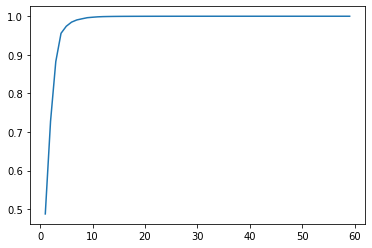

In [149]:
plt.plot(n_comp, ex_var), ex_var[1]

In [150]:
svd = TruncatedSVD(n_components=2)
X_graph = svd.fit_transform(X)
X_graph, X_graph.shape, svd.explained_variance_ratio_.sum()

(array([[11.29523996, -0.56599148],
        [16.78668278, -0.1296763 ],
        [ 9.51454909, -1.96495176],
        ...,
        [ 3.39383495, -6.03696574],
        [ 7.12672462, -4.95937341],
        [ 5.71616668, -5.17350213]]),
 (11690, 2),
 0.7275934799082445)

если вглядываться в данные то вообще не понятно как их делить если честно

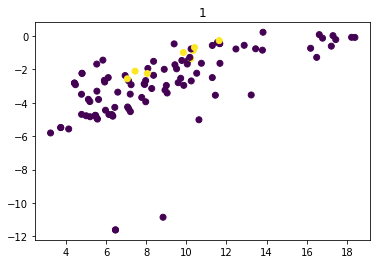

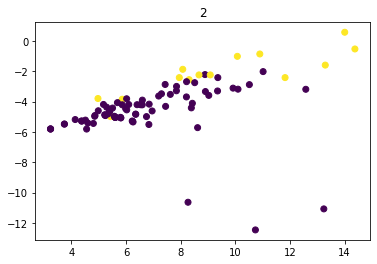

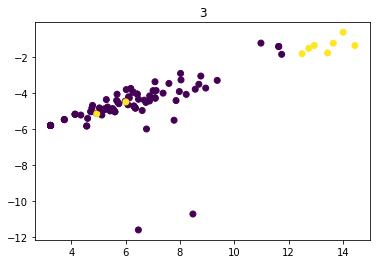

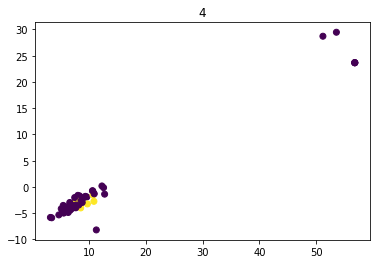

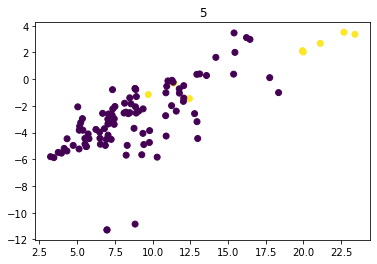

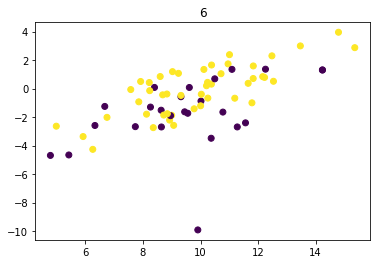

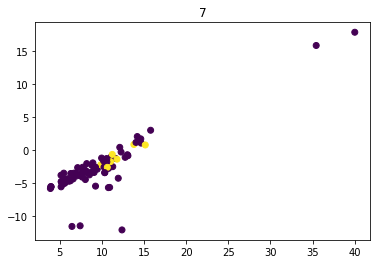

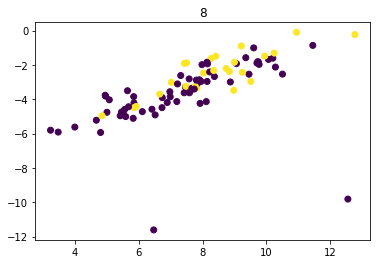

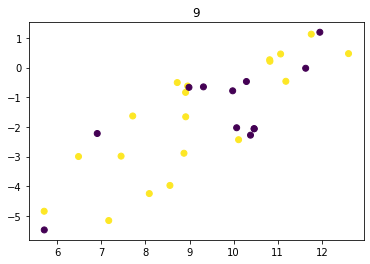

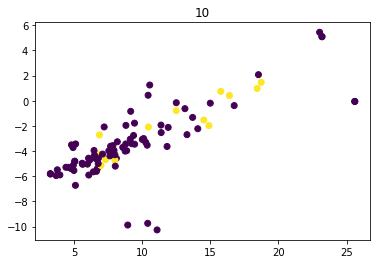

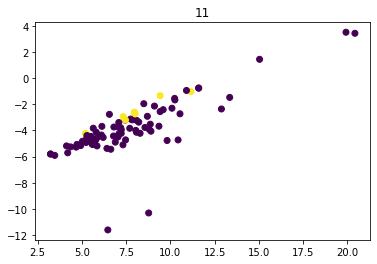

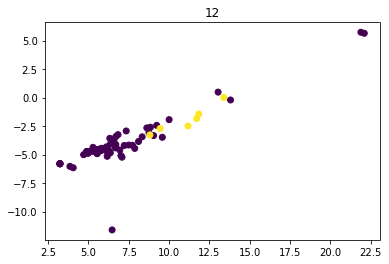

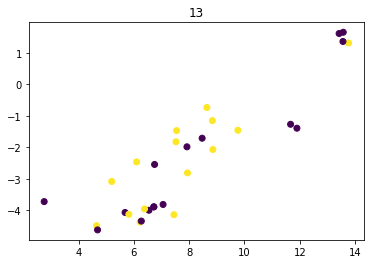

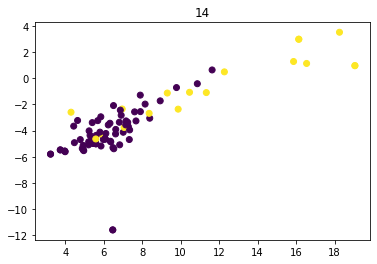

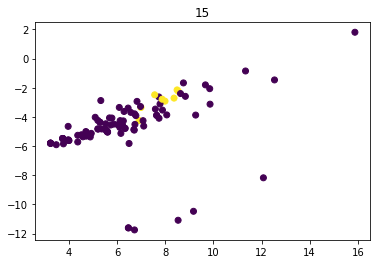

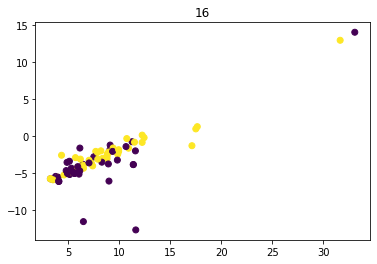

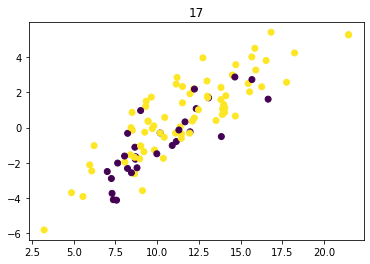

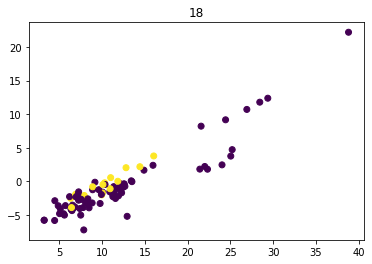

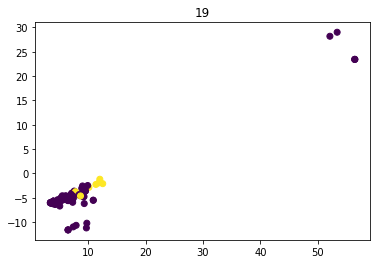

In [151]:
for i in range(1, 20):
    g = X_graph[groups_train == i]

    #clustering = DBSCAN(eps=1.35, min_samples=16).fit(g)

    plt.scatter(g[:, 0], g[:, 1], c=y[groups_train == i])
    plt.title(i)
    plt.show()

In [ ]:
plt.figure(figsize=(30, 30))
plt.scatter(X_graph[:, 0], X_graph[:, 1], c=y)
plt.title(i)
plt.show()

In [188]:
from sklearn.metrics.cluster import adjusted_rand_score

arr = np.arange(128) + 1

epss = np.linspace(0.95, 1, 50)
sampless = np.arange(5) + 5
scores_main = []
params = []

for n in sampless:
    print(n)
    for eps in epss:
        scores = []
        for i in arr:
            docs = traingroups_data_stem[i]
            df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr', 'target_id'])

            titles = np.array(df['title'])
            G = vectorizer.transform(titles).toarray()
            
            
            clustering = DBSCAN(eps=eps, min_samples=n).fit(G)

            """
            plt.scatter(g[:, 0], g[:, 1], c=(clustering.labels_))
            plt.title("clustering " + str(i))
            plt.show()

            plt.scatter(g[:, 0], g[:, 1], c=y[groups_train == i])
            plt.title(i)
            plt.show()
            """
            scores.append(adjusted_rand_score(y[groups_train == i], clustering.labels_))
        scores_main.append(np.array(scores).mean())
        params.append((n, eps))
    print(np.array(scores_main).max(), params[np.array(scores_main).argmax()])

5


TypeError: only integer scalar arrays can be converted to a scalar index

In [223]:
y = []
X = []

groups_train = []
for new_group in traingroups_data_stem:
    docs = traingroups_data_stem[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr', 'target_id'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    clustering = DBSCAN(eps=0.98, min_samples=5).fit(G)
    
    descrs = np.array(df['descr'])
    G2 = vectorizer2.transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2)
    
    for k, (doc_id, title, descr, target_id) in enumerate(docs):
        y.append(target_id)
        groups_train.append(new_group)
        
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j, target_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        all_dist_title_cos = sorted(all_dist_title_cos)[1:]
        all_dist_descrs_cos = sorted(all_dist_descrs_cos)[1:]
        a = all_dist_title_cos[0:20] + all_dist_descrs_cos[0:20]
        a = np.array(a)
        a = np.append(a, sorted(all_dist_title_int, reverse=True)[0:5])
        a = np.append(a, sorted(all_dist_descrs_int, reverse=True)[0:5])
        arr = [90, 70, 50, 30, 10]
        for l in arr:
            a = np.append(a, np.percentile(all_dist_title_cos, l))
        for l in arr:
            a = np.append(a, np.percentile(all_dist_descrs_cos, l))
        a = np.append(a, clustering.labels_[j] + 3)
        X.append(a)
X = np.array(X)
y = np.array(y)
groups_train = np.array(groups_train)
print (X.shape, y.shape, groups_train.shape)

(11690, 63) (11690,) (11690,)


In [224]:
clf = ExtraTreesClassifier(n_estimators=250, max_depth=1000)
clf = clf.fit(X, y)
clf.feature_importances_

array([0.01367595, 0.01963242, 0.03034378, 0.01751708, 0.02174901,
       0.0186778 , 0.01686727, 0.02485251, 0.01687478, 0.01559426,
       0.0150318 , 0.01596112, 0.01362431, 0.01459498, 0.01104701,
       0.01199707, 0.0154359 , 0.01101708, 0.0094642 , 0.01574389,
       0.01640921, 0.02004365, 0.02417239, 0.02565759, 0.01819535,
       0.01544073, 0.01530646, 0.02016353, 0.0135718 , 0.01239948,
       0.01116025, 0.01478202, 0.01354899, 0.01618668, 0.01483045,
       0.01401463, 0.0143676 , 0.01122781, 0.01011642, 0.00926902,
       0.0134125 , 0.01565859, 0.01160441, 0.01593319, 0.01463157,
       0.01630575, 0.01436145, 0.01437069, 0.01422668, 0.01346123,
       0.01188349, 0.01805541, 0.01745556, 0.01336749, 0.01581544,
       0.01725794, 0.0120588 , 0.01828335, 0.01368645, 0.01544063,
       0.02487778, 0.01774676, 0.01953855])

In [395]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:10]:
    print(n)
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=1200, learning_rate=0.01, 
                                     max_depth=1, subsample=0.8, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

21
31
41
51
61
71
81
91
101
111
121


0.7261581299275305

In [227]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [235]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:10]:
    print(n)
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[mask1]
    y_test = y[mask1]
    
    clf = RandomForestClassifier(n_estimators=400, max_depth= 9, max_features='auto').fit(X_train, y_train)
    #clf = SVC(C=4.6, degree=3, gamma='scale', kernel='rbf', probability=True).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    #y_ans = clf.predict(X_test)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

21
31
41
51
61
71
81
91
101
111
121


0.7091625101313861

In [153]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
train_scale = scaler.transform(X)

In [169]:
crossN = np.unique(groups_train)
scores = []

for n in crossN[20:-1:10]:
    print(n)
    mask = np.logical_and(groups_train <= n, groups_train >= n - 10)
    mask1 = ~mask
    X_train = train_scale[mask]
    y_train = y[mask]
    X_test = train_scale[mask1]
    y_test = y[mask1]
    
    clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(X_train, y_train)
    y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)
    scores.append(f1_score(y_ans, y_test))
np.array(scores).mean()

21
31
41
51
61
71
81
91
101
111
121


0.7255720524974661

In [180]:
X_test = []

for new_group in test_data_stem:
    docs = test_data_stem[new_group]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    gdist = cdist(G, G, metric='cosine')
    gdist = np.nan_to_num(gdist, nan=2)
    
    clustering = DBSCAN(eps=0.98, min_samples=5).fit(G)
    
    descrs = np.array(df['descr'])
    G2 = vectorizer2.transform(descrs).toarray()
    #print(G.shape, G2.shape)
    gdist2 = cdist(G2, G2, metric='cosine')
    gdist2 = np.nan_to_num(gdist2)
    
    
    for k, (doc_id, title, descr) in enumerate(docs):
        all_dist_title_cos = gdist[k]
        all_dist_title_int = []
        
        all_dist_descrs_cos = gdist[k]
        all_dist_descrs_int = []
        
        words_title = set(title.strip().split())
        words_descr = set(descr.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, descr_j = docs[j]
            words_title_j = set(title_j.strip().split())
            words_descr_j = set(descr_j.strip().split())
            
            all_dist_title_int.append(len(words_title.intersection(words_title_j)))
            all_dist_descrs_int.append(len(words_descr.intersection(words_descr_j)))
        all_dist_title_cos = sorted(all_dist_title_cos)[1:]
        all_dist_descrs_cos = sorted(all_dist_descrs_cos)[1:]
        a = all_dist_title_cos[0:25] + all_dist_descrs_cos[0:25]
        a = np.array(a)
        a = np.append(a, sorted(all_dist_title_int, reverse=True)[0:5])
        a = np.append(a, sorted(all_dist_descrs_int, reverse=True)[0:5])
        arr = [90, 70, 50, 30, 10]
        for l in arr:
            a = np.append(a, np.percentile(all_dist_title_cos, l))
        for l in arr:
            a = np.append(a, np.percentile(all_dist_descrs_cos, l))
        a = np.append(a, clustering.labels_[j] + 3)
        X_test.append(a)
X_test = np.array(X_test)
print (X_test.shape)

(16627, 71)


In [185]:
clf = GradientBoostingClassifier(n_estimators=1200, learning_rate=0.01, 
                                     max_depth=1, random_state=0).fit(X, y)
y_ans = np.where(clf.predict_proba(X_test)[:,1] >= 0.3, 1, 0)

In [186]:
np.bincount(y_ans)

array([10866,  5761])

In [187]:
df = pd.DataFrame({ 'pair_id': np.arange(11691, 28318),
                    'target': y_ans
})

df.to_csv("GoodAllSub3.csv", index=False)

CLASTER

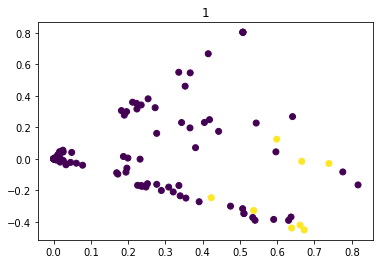

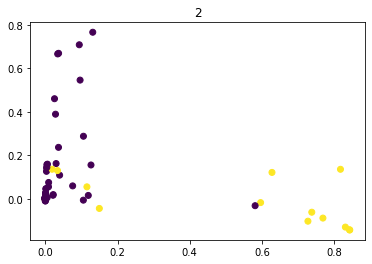

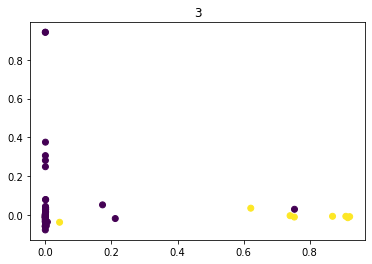

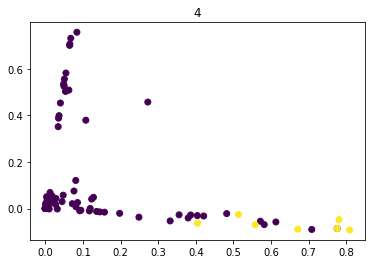

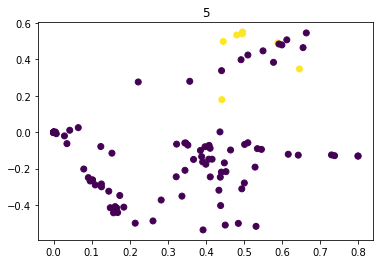

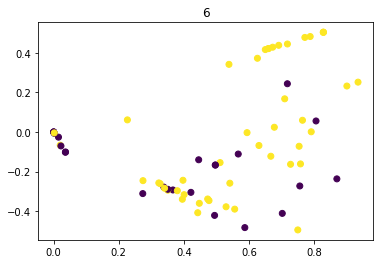

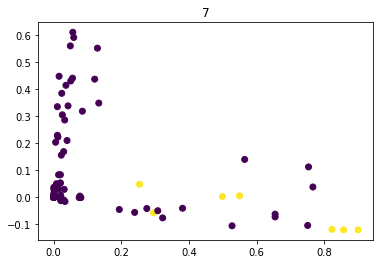

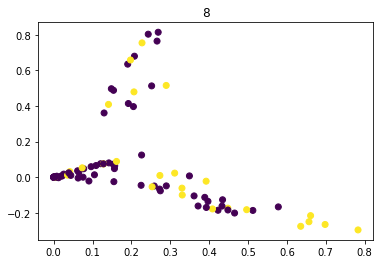

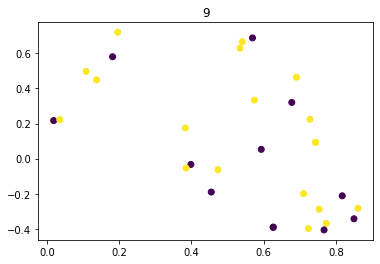

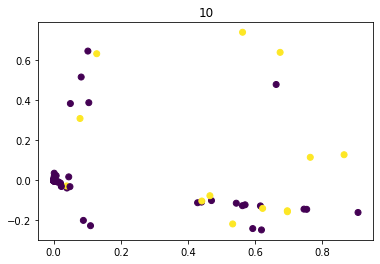

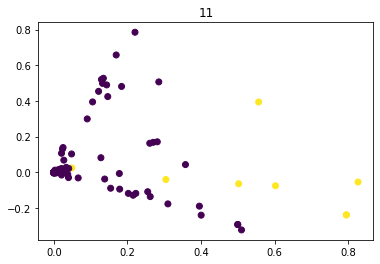

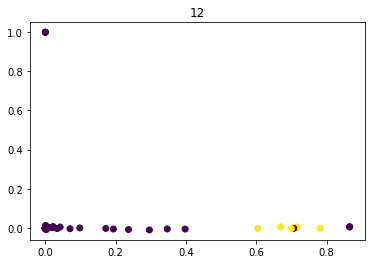

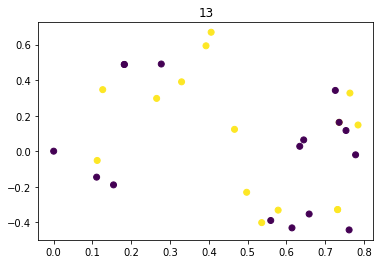

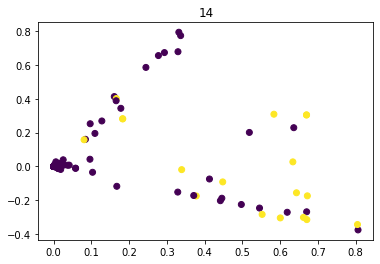

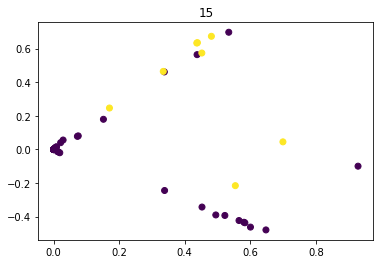

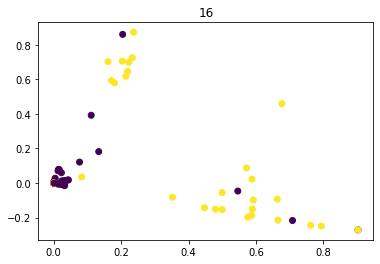

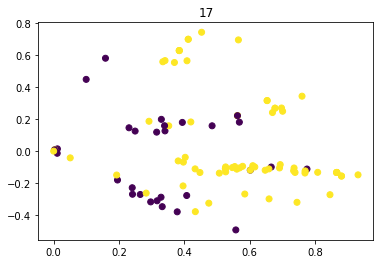

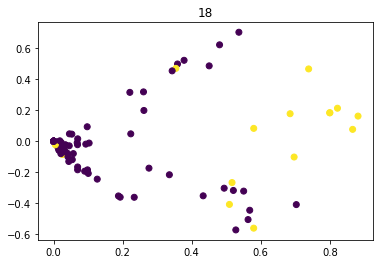

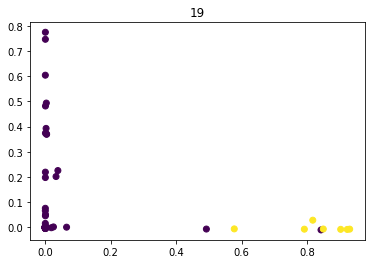

In [368]:
for i in range(1, 20):
    docs = traingroups_data_stem[i]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr', 'target_id'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    
    svd = TruncatedSVD(n_components=2)
    G_ = svd.fit_transform(G)
    
    plt.scatter(G_[:, 0], G_[:, 1], c=y[groups_train == i])
    plt.title(i)
    plt.show()

In [371]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [392]:
scores = []

for i in range(1, 28):
    docs = traingroups_data_stem[i]
    df = pd.DataFrame(docs, columns=['doc_id', 'title', 'descr', 'target_id'])
    
    titles = np.array(df['title'])
    G = vectorizer.transform(titles).toarray()
    
    cluster = DBSCAN(eps=0.98, min_samples=5).fit(G)
    #kmeans = KMeans(n_clusters=2, random_state=0).fit(G)
    
    pca = PCA(n_components=2)
    G_ = pca.fit_transform(G)
    
    #plt.scatter(G_[:, 0], G_[:, 1], c=y[groups_train == i])
    #plt.title(i)
    #plt.show()
    
    scores.append(adjusted_rand_score(y[groups_train == i], cluster.labels_))
    
    #plt.scatter(G_[:, 0], G_[:, 1], c=kmeans.labels_)
    #plt.title("clastering " + str(i) + " " + str(adjusted_rand_score(y[groups_train == i], kmeans.labels_)))
    #plt.show()

In [393]:
np.array(scores).mean()

0.24880635811404075